In [27]:
! pip install mutagen
! pip install pydub
! pip install kaggle
! pip install python-dotenv
! pip install wandb
! pip install optuna
! pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=7cf5903b00acc7b23496ce13b126976e52936571f73e9ea72431566a29c0ea7b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [28]:
%matplotlib inline

import re
import os
import sys
import h5py
import time
import json
import math
import random
import logging
import librosa
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from mutagen.mp3 import MP3
from pydub import AudioSegment

import IPython.display as ipd
from tqdm import tqdm
from tqdm import tqdm_notebook

import torch
import torchaudio
from torchaudio.transforms import TimeMasking, FrequencyMasking, Fade
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, ToPILImage
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from torch.nn import Module, Sequential, Conv1d, Conv2d, BatchNorm1d, BatchNorm2d, ReLU, LeakyReLU, MaxPool1d, MaxPool2d, AvgPool2d, Linear, Dropout

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, RocCurveDisplay, classification_report, multilabel_confusion_matrix

import wandb
import optuna

Weights & Biases (Wandb) has been integrated throughout the entire notebook. Wandb helps to build better models faster: it quickly tracks experiments, evaluates model performance, reproduces models, and manages ML workflows end-to-end. 

As can be seen in the following cell, in order to use this service one needs to log in to the server API (See https://docs.wandb.ai/guides/track/jupyter).

In [132]:
# IF ERROR: A UTF-8 locale is required. Got ANSI_X3.4-1968. USE:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

! wandb login

wandb: Currently logged in as: filippo_festa. Use `wandb login --relogin` to force relogin


# Import & preprocess dataset

In the this block of code, one can find out how the original data was imported and preprocessed: most of the lines of code are commented out, in order to avoid downloading the original dataset and reprocessing it each time. In fact what happens is the download of the already processed dataset saved on the 'Kaggle' platform.

In any case, it is possible to uncomment all the cells and run the entire block from the original dataset.

<br>

## Download and extract dataset

In [29]:
# ! wget https://www.dropbox.com/s/ntjl5aptgg5dqf9/kaggle.json

In [30]:
# ! mkdir ~/.kaggle

In [31]:
# ! cp kaggle.json ~/.kaggle/

In [32]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [33]:
# fma-small
# ! kaggle datasets download -d filippoorlando11/fma-small

In [34]:
# unzip small
# ! unzip /content/fma-small.zip

## Download metadata

In [35]:
! wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

--2023-09-13 00:03:21--  https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358412441 (342M) [application/zip]
Saving to: ‘fma_metadata.zip’

fma_metadata.zip    100%[===================>] 341.81M  26.7MB/s    in 14s     

2023-09-13 00:03:40 (24.9 MB/s) - ‘fma_metadata.zip’ saved [358412441/358412441]



In [36]:
! wget https://www.dropbox.com/s/ev14sud5qu2s2fs/utils.py

--2023-09-13 00:03:41--  https://www.dropbox.com/s/ev14sud5qu2s2fs/utils.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ev14sud5qu2s2fs/utils.py [following]
--2023-09-13 00:03:41--  https://www.dropbox.com/s/raw/ev14sud5qu2s2fs/utils.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca1ff354138d4e94b7de33a10bd.dl.dropboxusercontent.com/cd/0/inline/CDlAsqiMCVULnkbKj6CcfVj3YFQlDN4I69z5x7Pmh1lDRMQs2eqgsquM9R-9saklv-yFMYrGHItSUYKkYcj2RPvt5a459aDNxs6xcOZ2npDVZgKdkh0kTRz-zxOCjO6FEvWTjKG4i8STl0W6cEmJsd6q/file# [following]
--2023-09-13 00:03:41--  https://uca1ff354138d4e94b7de33a10bd.dl.dropboxusercontent.com/cd/0/inline/CDlAsqiMCVULnkbKj6CcfVj3YFQlDN4I69z5x7Pmh1lDRMQs2eqgsquM9R-9saklv-yFMYrGHItSUYKkYcj2RPvt5a459aDNxs6xcOZ2npDVZgKdkh

In [37]:
! 7z x /content/fma_metadata.zip -o/content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 358412441 bytes (342 MiB)

Extracting archive: /content/fma_metadata.zip
--
Path = /content/fma_metadata.zip
Type = zip
Physical Size = 358412441

  0%      0% 4 - fma_metadata/raw_albums.csv                                      1% 4 - fma_metadata/raw_albums.csv                                      1% 5        1% 5 - fma_metadata/raw_artists.csv                                       2% 5 - fma_metadata/raw_artists.csv

## Explore & extract metadata

In [38]:
import utils     # load the file utils.py

# Load metadata and features.
tracks = utils.load('/content/fma_metadata/tracks.csv')
genres = utils.load('/content/fma_metadata/genres.csv')
features = utils.load('/content/fma_metadata/features.csv')
echonest = utils.load('/content/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [39]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

bit_rate  comments   composer        date_created date_recorded  \
track_id                                                                    
2           256000         0        NaN 2008-11-26 01:48:12    2008-11-26   
3           256000         0        NaN 2008-11-26 01:48:14    2008-11-26   
5           256000         0        NaN 2008-11-26 01:48:20    2008-11-26   
10          192000         0  Kurt Vile 2008-11-25 17:49:06    2008-11-26   
20          256000         0        NaN 2008-11-26 01:48:56    2008-01-01   

          duration  favorites genre_top     genres         genres_all  \
track_id                                                                
2              168          2   Hip-Hop       [21]               [21]   
3              237          1   Hip-Hop       [21]               [21]   
5              206          6   Hip-Hop       [21]               [21]   
10             161        178       Pop       [10]               [10]   
20             311          0       NaN  [76, 103]  [17, 10, 76, 103]   

         information  interest language_code  \
track_id                                       
2                NaN      4656            en   
3                NaN      1470            en   
5                NaN      1933            en   
10               NaN     54881            en   
20               NaN       978            en   

                                                    license  listens lyricist  \
track_id                                                                        
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...     1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...      514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...     1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...    50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...      361      NaN   

          number publisher tags            title  
track_id                                          
2              3       NaN   []             Food  
3              4       NaN   []     Electric Ave  
5              6       NaN   []       This World  
10             1       NaN   []          Freeway  
20             3       NaN   []  Spiritual Level

comments        date_created date_released engineer  favorites  id  \
track_id                                                                       
2                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
3                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
5                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
10               0 2008-11-26 01:45:08    2008-02-06      NaN          4   6   
20               0 2008-11-26 01:45:05    2009-01-06      NaN          2   4   

                                        information  listens producer tags  \
track_id                                                                     
2                                           <p></p>     6073      NaN   []   
3                                           <p></p>     6073      NaN   []   
5                                           <p></p>     6073      NaN   []   
10                                              NaN    47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>     2710      NaN   []   

                         title  tracks   type  
track_id                                       
2         AWOL - A Way Of Life       7  Album  
3         AWOL - A Way Of Life       7  Album  
5         AWOL - A Way Of Life       7  Album  
10           Constant Hitmaker       2  Album  
20                       Niris      13  Album

active_year_begin active_year_end  \
track_id                                     
2               2006-01-01             NaT   
3               2006-01-01             NaT   
5               2006-01-01             NaT   
10                     NaT             NaT   
20              1990-01-01      2011-01-01   

                                          associated_labels  \
track_id                                                      
2                                                       NaN   
3                                                       NaN   
5                                                       NaN   
10        Mexican Summer, Richie Records, Woodsist, Skul...   
20                                                      NaN   

                                                        bio  comments  \
track_id                                                                
2         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
3         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
5         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
10        <p><span style="font-family:Verdana, Geneva, A...         3   
20        <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...         2   

                date_created  favorites  id   latitude            location  \
track_id                                                                     
2        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
3        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
5        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
10       2008-11-26 01:42:55         74   6        NaN                 NaN   
20       2008-11-26 01:42:52         10   4  51.895927  Colchester England   

          longitude                                            members  \
track_id                                                                 
2        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
3        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
5        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
10              NaN                           Kurt Vile, the Violators   
20         0.891874                                       Nicky Cook\n   

                name                                   related_projects  \
track_id                                                                  
2               AWOL  The list of past projects is 2 long but every1...   
3               AWOL  The list of past projects is 2 long but every1...   
5               AWOL  The list of past projects is 2 long but every1...   
10         Kurt Vile                                                NaN   
20        Nicky Cook                                                NaN   

                                                       tags  \
track_id                                                      
2                                                    [awol]   
3                                                    [awol]   
5                                                    [awol]   
10                                      [philly, kurt vile]   
20        [instrumentals, experimental pop, post punk, e...   

                                          website wikipedia_page  
track_id                                                          
2         http://www.AzillionRecords.blogspot.com            NaN  
3         http://www.AzillionRecords.blogspot.com            NaN  
5         http://www.AzillionRecords.blogspot.com            NaN  
10                            http://kurtvile.com            NaN  
20                                            NaN            NaN

split  subset
track_id                  
2         training   small
3         training  medium
5         training   small
10        training   small
20        training   large

In [40]:
small = tracks[tracks['set', 'subset'] == 'small']
small.shape

(8000, 52)

In [41]:
small.head(2)

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   

                                            ...       track           \
         information listens producer tags  ... information interest   
track_id                                    ...                        
2            <p></p>    6073      NaN   []  ...         NaN     4656   
5            <p></p>    6073      NaN   []  ...         NaN     1933   

                                                                           \
         language_code                                            license   
track_id                                                                    
2                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
5                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   

                                                             
         listens lyricist number publisher tags       title  
track_id                                                     
2           1293      NaN      3       NaN   []        Food  
5           1151      NaN      6       NaN   []  This World  

[2 rows x 52 columns]

In [42]:
all_small = all(small['set', 'subset']=='small')
print(all_small)

small['set']

True


split subset
track_id                 
2         training  small
5         training  small
10        training  small
140       training  small
141       training  small
...            ...    ...
154308        test  small
154309        test  small
154413    training  small
154414    training  small
155066    training  small

[8000 rows x 2 columns]

<br><br>

Creation of the one hot encoding dataframes.

In [43]:
# track id of all songs from the small fma dataset
subset = tracks.index[tracks['set', 'subset'] <= 'small']
print(subset)

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

tracks = tracks.loc[subset]
print('\n', tracks.shape)

Int64Index([     2,      5,     10,    140,    141,    148,    182,    190,
               193,    194,
            ...
            153956, 154303, 154305, 154306, 154307, 154308, 154309, 154413,
            154414, 155066],
           dtype='int64', name='track_id', length=8000)

 (8000, 52)


In [44]:
# track index of train, test and validation set
train_idx = tracks.index[tracks['set', 'split'] == 'training']
val_idx = tracks.index[tracks['set', 'split'] == 'validation']
test_idx = tracks.index[tracks['set', 'split'] == 'test']
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train_idx, val_idx, test_idx])))

genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('\nAll genres ({}): {}'.format(len(genres), genres))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
print('\nTop genres ({}): {}'.format(len(genres), genres))

6400 training examples, 800 validation examples, 800 testing examples

All genres (114): [1, 2, 6, 10, 12, 15, 16, 17, 18, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 38, 41, 42, 45, 46, 47, 49, 53, 58, 64, 66, 70, 71, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 167, 171, 172, 174, 177, 180, 181, 182, 183, 184, 185, 186, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 314, 337, 359, 360, 361, 362, 400, 401, 404, 439, 440, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 695, 741, 763, 808, 811, 1032, 1060, 1193, 1235]

Top genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


In [45]:
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)
labels_onehot

0  1  2  3  4  5  6  7
track_id                        
2         0  0  0  1  0  0  0  0
5         0  0  0  1  0  0  0  0
10        0  0  0  0  0  0  1  0
140       0  0  1  0  0  0  0  0
141       0  0  1  0  0  0  0  0
...      .. .. .. .. .. .. .. ..
154308    0  0  0  1  0  0  0  0
154309    0  0  0  1  0  0  0  0
154413    0  0  0  0  0  0  1  0
154414    0  0  0  0  0  0  1  0
155066    0  0  0  1  0  0  0  0

[8000 rows x 8 columns]

In [46]:
labels_onehot_train = pd.DataFrame(labels_onehot, index=train_idx)
labels_onehot_test = pd.DataFrame(labels_onehot, index=test_idx)
labels_onehot_val = pd.DataFrame(labels_onehot, index=val_idx)
labels_onehot_train.shape, labels_onehot_test.shape, labels_onehot_val.shape

((6400, 8), (800, 8), (800, 8))

## Duration Analysis

We conducted a duration analysis and identified anomalous tracks of varying lengths, including some that are exceptionally short. To address this issue, we have decided to replace the shorter tracks.

In [47]:
# durations = small['track', 'duration']
# durations

In [48]:
# fma_small/098/098567.mp3 file lungo meno di 30 sec.
# Ignoring /content/fma_small/098/098567.mp3 (error: could not broadcast input array from shape (8167,) into shape (479625,)).

# tracks[tracks['track', 'title']=='Fuck The World']['track', 'duration']

In [49]:
# max_dur = small['track', 'duration'].max()

# durations = small['track', 'duration']
# plt.figure(figsize=(10, 4))  # Poster: (7, 3)
# p = sns.distplot(durations[durations.values < max_dur], kde=False, rug=False, color='k', hist_kws=dict(alpha=0.4))
# p.set_xlabel('duration [seconds]')
# p.set_ylabel('#tracks')
# p.set_xlim(0, max_dur)  # Poster: 500
# plt.tight_layout()

# durations[durations.values < max_dur].describe()

In [50]:
# rootdir = '/content/fma_small'   # os.path.abspath(os.getcwd())

# durs = []
# ids = []
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#       path = os.path.join(subdir, file)
#       if path=='/content/fma_small/README.txt' or path=='/content/fma_small/checksums':
#         None
#       else:
#         dur = MP3(path).info.length
#         durs.append(dur)
#         ids.append(path[-10:-4])

# durs_df = pd.DataFrame({'track_id':ids, 'Duration[s]':durs})
# durs_df.describe()

In [51]:
# durs_pd_g29 = durs_df[durs_df['Duration[s]']>=29]
# durs_pd_g29.describe()

In [52]:
# ax = durs_pd_g29.hist(column='Duration[s]', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

# ax = ax[0]
# for x in ax:
#     # Despine
#     x.spines['right'].set_visible(False)
#     x.spines['top'].set_visible(False)
#     x.spines['left'].set_visible(False)

#     # Switch off ticks
#     x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

#     # Draw horizontal axis lines
#     vals = x.get_yticks()
#     for tick in vals:
#         x.axhline(y=tick, linestyle='dashed', alpha=0.6, color='#eeeeee', zorder=1)

#     # Remove title
#     x.set_title("Track durations of FMA small $(\geq 29s)$")

#     # Set x-axis label
#     x.set_xlabel("Track Duration [Seconds]", labelpad=20, weight='bold', size=12)

#     # Set y-axis label
#     x.set_ylabel("Counts", labelpad=20, weight='bold', size=12)

#     # Format y-axis label
#     x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [53]:
# durs_pd_l29 = durs_df[durs_df['Duration[s]']<29]
# durs_pd_l29

In [54]:
# ax = durs_pd_l29.hist(column='Duration[s]', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

# ax = ax[0]
# for x in ax:
#     # Despine
#     x.spines['right'].set_visible(False)
#     x.spines['top'].set_visible(False)
#     x.spines['left'].set_visible(False)

#     # Switch off ticks
#     x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

#     # Draw horizontal axis lines
#     vals = x.get_yticks()
#     for tick in vals:
#         x.axhline(y=tick, linestyle='dashed', alpha=0.6, color='#eeeeee', zorder=1)

#     # Remove title
#     x.set_title("Track durations of FMA small $(< 29s)$")

#     # Set x-axis label
#     x.set_xlabel("Track Duration [Seconds]", labelpad=20, weight='bold', size=12)

#     # Set y-axis label
#     x.set_ylabel("Counts", labelpad=20, weight='bold', size=12)

#     # Format y-axis label
#     x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [55]:
# # Download the fixed track -> fixed_track folder
# ! wget https://www.dropbox.com/s/5tfzu9mb655pnn1/fixed_track.zip
# ! 7z x /content/fixed_track.zip -o/content/

# rootdir = '/content/fixed_track'

# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#       path = os.path.join(subdir, file)
#       dir = path[-10:-7]
#       fil = path[-10:]

#       song = AudioSegment.from_mp3(path)
#       center = round(len(song)/2)
#       duration = 30

#       # pydub does things in milliseconds
#       step = (duration/2) * 1000
#       new_path = f'/content/fma_small/{dir}/{fil}'
#       track_30 = song[center-step:center+step]
#       track_30.export(new_path, format="mp3")

#       print(MP3(new_path).info.length)

In [56]:
# rootdir = '/content/fma_small'   # os.path.abspath(os.getcwd())

# durs = []
# ids = []
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#       path = os.path.join(subdir, file)
#       if path=='/content/fma_small/README.txt' or path=='/content/fma_small/checksums':
#         None
#       else:
#         dur = librosa.get_duration(path=path)     #MP3(path).info.length
#         durs.append(dur)
#         ids.append(path[-10:-4])

# durs_df = pd.DataFrame({'track_id':ids, 'Duration[s]':durs})
# durs_df.describe()

In [57]:
# durs_pd_l30 = durs_df[durs_df['Duration[s]']<29.97]
# durs_pd_l30

In [58]:
# Tmin = durs_df['Duration[s]'].min()    # 29.964580498866212
# Tmin

## Create chunks

The audio clips are segmented into 4-second chunks with a 50% overlap, resulting in 13 chunks per track. The resulting dataset is then uploaded to 'Kaggle' to avoid having to repeat this process each time.

In [61]:
# duration=28*1000      # pydub does things in milliseconds
# window=4*1000
# overlap=0.5           # number between [0,1] -> 0.5 means 50% overlap between subsequent chunks
#                       #                      -> 0.75 means 25% and so on...
#                       #                      -> overlap% = (1-overlap)*100%

# rootdir = '/content/fma_small/'
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#       path = os.path.join(subdir, file)
#       if path=='/content/fma_small/README.txt' or path=='/content/fma_small/checksums':
#         None
#       else:
#         # print('\n', path)
#         dir = path[-10:-7]
#         fil = path[-10:-4]

#         song = AudioSegment.from_mp3(path)
#         song = song[:duration]
#         for i, chunk in enumerate(np.arange(0, duration, window*(1-overlap))):
#           if chunk + window <= duration:
#             new_path = f'/content/fma_small/{dir}/{fil}_{i}.mp3'
#             # print(new_path, chunk, chunk+window)
#             track_chunk = song[chunk:chunk+window]
#             track_chunk.export(new_path, format="mp3")
#         os.remove(path)

In [63]:
# rootdir = '/content/fma_small'   # os.path.abspath(os.getcwd())

# durs, ids = [], []
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#       path = os.path.join(subdir, file)
#       if path=='/content/fma_small/README.txt' or path=='/content/fma_small/checksums':
#         None
#       else:
#         dur = librosa.get_duration(path=path)     #MP3(path).info.length
#         durs.append(dur)
#         ids.append(path[-12:-4])

# durs_chunk_df = pd.DataFrame({'track_id':ids, 'Duration[s]':durs})
# durs_chunk_df.describe()

In [64]:
# ! kaggle datasets init -p /content/fma_small

In [65]:
# metadata = {
#   "title": "fma-small-4s",
#   "id": "filippoorlando11/fma-small-4s",
#   "licenses": [{"name": "CC0-1.0"}]
# }

# json_object =json.dumps(metadata, indent=4)
# with open("/content/fma_small/dataset-metadata.json", "w") as outfile:
#     outfile.write(json_object)

In [66]:
# ! kaggle datasets create -p /content/fma_small --dir-mode zip

## Download and extract chunk dataset

In [67]:
! wget https://www.dropbox.com/s/ntjl5aptgg5dqf9/kaggle.json

--2023-09-13 00:05:57--  https://www.dropbox.com/s/ntjl5aptgg5dqf9/kaggle.json
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ntjl5aptgg5dqf9/kaggle.json [following]
--2023-09-13 00:05:57--  https://www.dropbox.com/s/raw/ntjl5aptgg5dqf9/kaggle.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8e091f1a980e3a315842d856fa.dl.dropboxusercontent.com/cd/0/inline/CDl77UNO6J-gru9L_XQyV9Rk-KN90vnLWpI4ICluTjuec2Jy68BiYlxt21DKBBJJyMxmHYFNAkeer92EexRe6PIYaany-iLq6JDVpGsPX0sm1StPb5WcsAjdZcaRcfzxXuuQRN1VGcYjM9sgo1Vv-De6/file# [following]
--2023-09-13 00:05:58--  https://uc8e091f1a980e3a315842d856fa.dl.dropboxusercontent.com/cd/0/inline/CDl77UNO6J-gru9L_XQyV9Rk-KN90vnLWpI4ICluTjuec2Jy68BiYlxt21DKBBJJyMxmHYFNAkeer92EexRe6PIYaany-iLq6JDVpGsPX

In [68]:
! mkdir ~/.kaggle

In [69]:
! cp kaggle.json ~/.kaggle/

In [70]:
! chmod 600 ~/.kaggle/kaggle.json

In [71]:
# fma-small-4s chunks dataset
! kaggle datasets download -d filippoorlando11/fma-small-4s

100% 6.17G/6.18G [01:21<00:00, 73.0MB/s]
100% 6.18G/6.18G [01:22<00:00, 80.9MB/s]


In [72]:
# create fma-small-4s dataset folder
! mkdir /content/fma-small-4s

# unzip small-4s chunks dataset
! unzip /content/fma-small-4s.zip -d /content/fma-small-4s/

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/fma-small-4s/144/144213_4.mp3  
  inflating: /content/fma-small-4s/144/144213_5.mp3  
  inflating: /content/fma-small-4s/144/144213_6.mp3  
  inflating: /content/fma-small-4s/144/144213_7.mp3  
  inflating: /content/fma-small-4s/144/144213_8.mp3  
  inflating: /content/fma-small-4s/144/144213_9.mp3  
  inflating: /content/fma-small-4s/144/144214_0.mp3  
  inflating: /content/fma-small-4s/144/144214_1.mp3  
  inflating: /content/fma-small-4s/144/144214_10.mp3  
  inflating: /content/fma-small-4s/144/144214_11.mp3  
  inflating: /content/fma-small-4s/144/144214_12.mp3  
  inflating: /content/fma-small-4s/144/144214_2.mp3  
  inflating: /content/fma-small-4s/144/144214_3.mp3  
  inflating: /content/fma-small-4s/144/144214_4.mp3  
  inflating: /content/fma-small-4s/144/144214_5.mp3  
  inflating: /content/fma-small-4s/144/144214_6.mp3  
  inflating: /content/fma-small-4s/144/144214_7.mp3  
  inflating: /content/fma-sma

In [73]:
# rootdir = '/content/fma-small-4s'   # os.path.abspath(os.getcwd())

# durs, ids = [], []
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#       path = os.path.join(subdir, file)
#       if path=='/content/fma-small-4s/README.txt' or path=='/content/fma-small-4s/checksums':
#         None
#       else:
#         dur = librosa.get_duration(path=path)     #MP3(path).info.length
#         durs.append(dur)
#         ids.append(path[-12:-4])

# durs_chunk_df = pd.DataFrame({'track_id':ids, 'Duration[s]':durs})
# durs_chunk_df.describe()          # Abbiamo 8000*13=104000 tracce da 4s

# FMA dataset class

In [74]:
# Songs are 28s long, we have chunks 4s long with 50% overlap between successive segments
numchunk=13

Creation of the one hot encoding dataframes for the chunk dataset.

In [75]:
tr = pd.DataFrame(tracks['track', 'genre_top'], index=train_idx)
tr['song'] = (tr.index.astype(str).str.zfill(6) + '.mp3').astype(str)
tr['fold'] = tr['song'].str[:3]
tr['genre'] = tr['track']['genre_top']
tr_ = tr.drop('track', axis=1)

tr = pd.DataFrame(np.repeat(tr_.reset_index().values, numchunk, axis=0))
tr.columns = tr_.reset_index().columns
tr.song = [tr.song.iloc[x][:-4]+'_'+str(x%numchunk)+tr.song.iloc[x][-4:] for x in range(len(tr.song))]

In [76]:
va = pd.DataFrame(tracks['track', 'genre_top'], index=val_idx)
va['song'] = (va.index.astype(str).str.zfill(6) + '.mp3').astype(str)
va['fold'] = va['song'].str[:3]
va['genre'] = va['track']['genre_top']
va_ = va.drop('track', axis=1)

va = pd.DataFrame(np.repeat(va_.reset_index().values, numchunk, axis=0))
va.columns = va_.reset_index().columns
va.song = [va.song.iloc[x][:-4]+'_'+str(x%numchunk)+va.song.iloc[x][-4:] for x in range(len(va.song))]

In [77]:
te = pd.DataFrame(tracks['track', 'genre_top'],index = test_idx)
te['song'] = (te.index.astype(str).str.zfill(6) + '.mp3').astype(str)
te['fold'] = te['song'].str[:3]
te['genre'] = te['track']['genre_top']
te_ = te.drop('track', axis=1)

te = pd.DataFrame(np.repeat(te_.reset_index().values, numchunk, axis=0))
te.columns = te_.reset_index().columns
te.song = [te.song.iloc[x][:-4]+'_'+str(x%numchunk)+te.song.iloc[x][-4:] for x in range(len(te.song))]

In [78]:
class FMA_Dataset(Dataset):
    def __init__(self, annotations_file, labels_file, audio_dir, transformation, augmentation, img, target_sample_rate, mono, offset):
        self.annotations = annotations_file
        self.label = labels_file
        self.audio_dir = audio_dir

        if transformation is not None:
          self.transformation = transformation
        else:
          self.transformation = transformation

        self.augmentation = augmentation
        self.img = img
        self.target_sample_rate = target_sample_rate
        self.mono = mono
        self.offset = offset
        self.duration = 4                                    


    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, index):
        audio_sample_path, track_id = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(track_id)

        signal, sr = librosa.load(audio_sample_path, sr=self.target_sample_rate, mono=self.mono, offset=self.offset, duration=self.duration)
        signal = torch.from_numpy(signal)
        if self.mono: signal = torch.reshape(signal, (1,-1))

        if self.transformation is not None:
          signal = self.transformation(signal)
          if self.img is None:
            signal = torchaudio.transforms.AmplitudeToDB()(signal)                 # Convert the spectrogram to dB scale for better visualization
            signal = (signal - signal.mean()) / (signal.std() + 1e-10)             # Normalize the spectrogram with mean zero and variance one
          if self.img is not None:
            cmap = plt.get_cmap('viridis')
            signal = cmap(signal[0].cpu())
            signal = torch.from_numpy(signal).permute(2, 0, 1).contiguous()

        if self.augmentation is not None:
            signal = self.augmentation(signal)
        return signal, label, track_id


    def _get_audio_sample_path(self, index):
        fold = f"{self.annotations.iloc[index, 2]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[index, 1])
        id = self.annotations.iloc[index, 0]
        return path, id


    def _get_audio_sample_label(self, id):
        return self.label.loc[id].values

In [79]:
AUDIO_DIR = '/content/fma-small-4s/'
mono, offset = True, 0.0
target_sample_rate = 22050
p = 0.5                        # probability of the single augmentation



# Transformations
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=target_sample_rate, n_fft=1024, hop_length=512, n_mels=128)


# add Gaussian noise to the waveform
def add_gaussian_noise(waveform, scale=0.01):
        noise = torch.randn_like(waveform) * scale
        return waveform + noise

# Augmentations
augmentation_img = Compose([
    ToPILImage(),
    ToTensor(),
    lambda x: RandomAffine((0.05, 0.05))(x) if random.random() < p else x,
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])
augmentation_wave = Compose([
    lambda x: Fade(fade_in_len=75000, fade_out_len=75000)(x) if random.random() < p else x,  # Apply fade-in and fade-out
    lambda x: add_gaussian_noise(x, scale=0.5) if random.random() < p else x
])
augmentation_spect = Compose([
    lambda x: TimeMasking(time_mask_param=80)(x) if random.random() < p else x,
    lambda x: FrequencyMasking(freq_mask_param=60)(x) if random.random() < p else x
])


train_wave = FMA_Dataset(tr, labels_onehot_train, AUDIO_DIR, None, augmentation_wave, None, target_sample_rate, mono, offset)
val_wave = FMA_Dataset(va, labels_onehot_val, AUDIO_DIR, None, None, None, target_sample_rate, mono, offset)
test_wave = FMA_Dataset(te, labels_onehot_test, AUDIO_DIR, None, None, None, target_sample_rate, mono, offset)

train_spect = FMA_Dataset(tr, labels_onehot_train, AUDIO_DIR, mel_spectrogram, augmentation_spect, None, target_sample_rate, mono, offset)
val_spect = FMA_Dataset(va, labels_onehot_val, AUDIO_DIR, mel_spectrogram, None, None, target_sample_rate, mono, offset)
test_spect = FMA_Dataset(te, labels_onehot_test, AUDIO_DIR, mel_spectrogram, None, None, target_sample_rate, mono, offset)

img = True
train_spect_img = FMA_Dataset(tr, labels_onehot_train, AUDIO_DIR, mel_spectrogram, augmentation_img, img, target_sample_rate, mono, offset)
val_spect_img = FMA_Dataset(va, labels_onehot_val, AUDIO_DIR, mel_spectrogram, None, img, target_sample_rate, mono, offset)
test_spect_img = FMA_Dataset(te, labels_onehot_test, AUDIO_DIR, mel_spectrogram, None, img, target_sample_rate, mono, offset)

In [80]:
print(f"There are {len(train_wave)} samples in the dataset.")

There are 83200 samples in the dataset.


In [81]:
signal, label, track_id = train_wave[0]
print(signal.shape, label.shape, track_id)

signal, label, track_id = train_spect[0]
print(signal.shape, label.shape, track_id)

signal, label, track_id = train_spect_img[0]
print(signal.shape, label.shape, track_id)

torch.Size([1, 88200]) (8,) 2
torch.Size([1, 128, 173]) (8,) 2
torch.Size([4, 128, 173]) (8,) 2


# Visualize Data

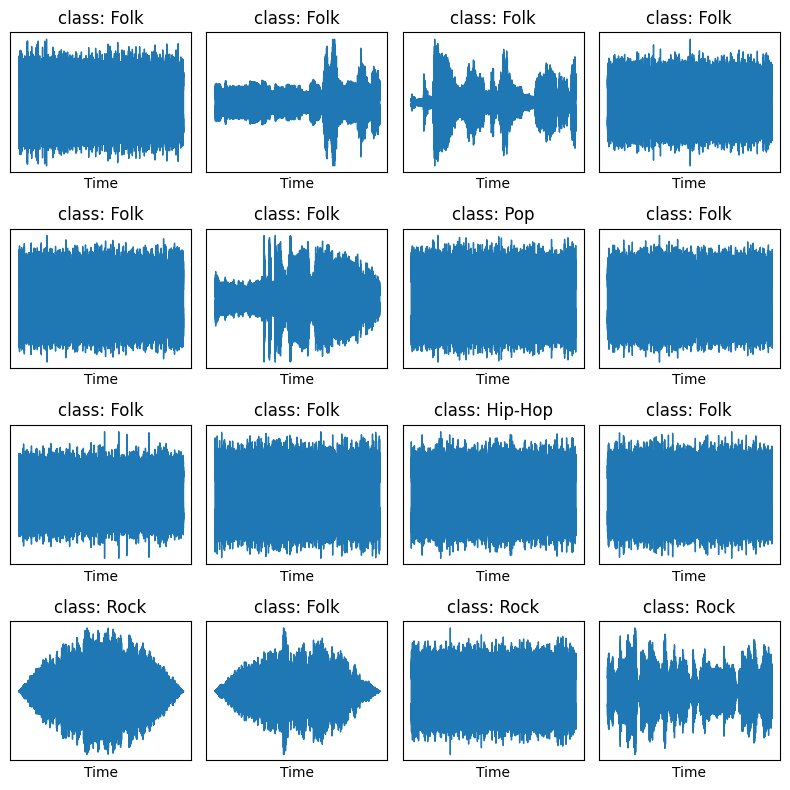

In [118]:
fig, axs = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    rr = random.randint(20, 500)
    librosa.display.waveshow(train_wave[i+rr][0].numpy(), sr=target_sample_rate, ax=axs[i//4][i%4])
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"class: {genres[np.where(train_wave[i+rr][1]==1)[0][0]]}")
plt.tight_layout()
plt.show()

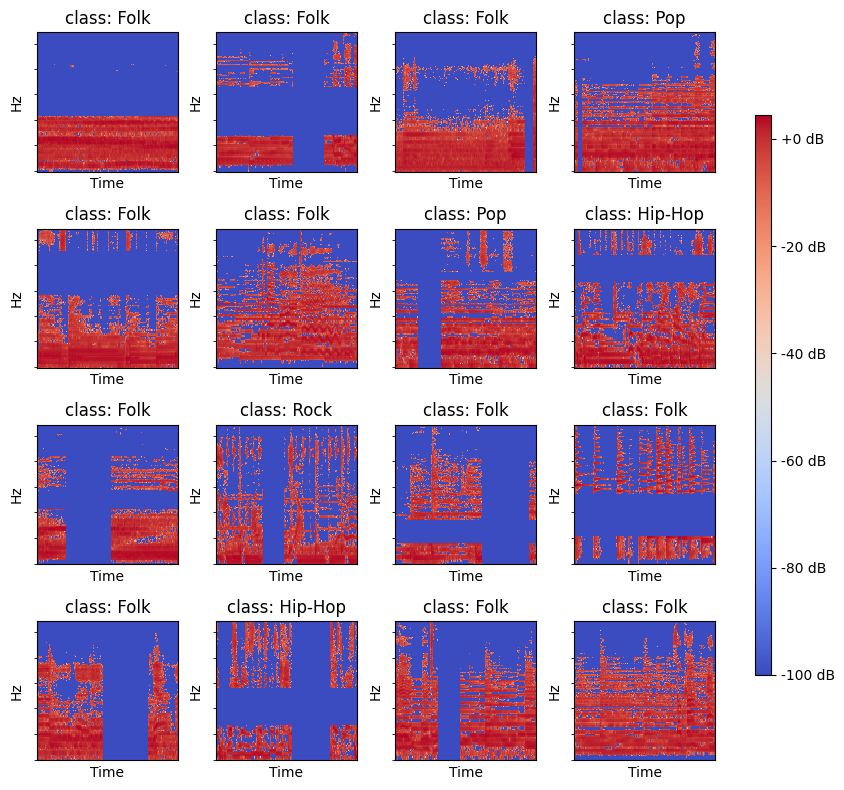

In [119]:
transform = torchaudio.transforms.AmplitudeToDB()

fig, axs = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    rr = random.randint(20, 500)
    img = librosa.display.specshow(transform(train_spect[i+rr][0][0]).numpy(), x_axis='time', y_axis='mel', ax=axs[i//4][i%4])
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"class: {genres[np.where(train_spect[i+rr][1]==1)[0][0]]}")

plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB')
plt.show()

# Blocks

## Max + Average pooling

In [186]:
class MixedPooling1d(Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MixedPooling1d, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size, stride=stride, padding=padding)
        self.max_pool = nn.MaxPool1d(kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        avg_pooled = self.avg_pool(x)
        max_pooled = self.max_pool(x)
        return avg_pooled + max_pooled

In [187]:
class MixedPooling2d(Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MixedPooling2d, self).__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size, stride=stride, padding=padding)
        self.max_pool = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        avg_pooled = self.avg_pool(x)
        max_pooled = self.max_pool(x)
        return avg_pooled + max_pooled

## Temporal convolution

In [188]:
class TemporalConv1d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1, bias=False):
        super(TemporalConv1d, self).__init__()
        self.__padding = (kernel_size - 1) * dilation
        self.dilat_conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, dilation=dilation, groups=groups, bias=bias)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):
        x = F.pad(x, (self.__padding, 0))
        x = self.dilat_conv(x)
        return x

In [189]:
class TemporalConv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=False):
        super(TemporalConv2d, self).__init__()
        if type(kernel_size) is not tuple: raise Exception("kernel_size is not a tuple")
        self.__padding = (kernel_size[1] - 1) * dilation
        self.dilat_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=(stride,1), dilation=(1,dilation), groups=groups, bias=bias)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):
        x = F.pad(x, (self.__padding, 0))
        x = self.dilat_conv(x)
        return x

## 1D blocks - Waveform

### Residual blocks

#### Identity block

In [190]:
class MainPath1d(Module):
    def __init__(self, in_channels, filters, kernel_size=1, stride=1, bias=False):
        super().__init__()
        F1, F2 = filters
        self.main_path = Sequential(
            Conv1d(in_channels, F1, kernel_size=kernel_size, stride=stride, bias=bias),
            BatchNorm1d(F1),
            LeakyReLU(),
            Conv1d(F1, F2, kernel_size=kernel_size, stride=stride, bias=bias),
            BatchNorm1d(F2),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y


class IdentityBlock1d(MainPath1d):
    def __init__(self, in_channels, filters, kernel_size, stride=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, stride, bias)
        self.Leaky_relu = LeakyReLU()

    def forward(self, x):
        y = self.main_path(x)
        pad_time = x.shape[-1]-y.shape[-1]
        left_pad_time = pad_time//2
        right_pad_time = pad_time-left_pad_time
        y = F.pad(y, (left_pad_time, right_pad_time))
        y = self.Leaky_relu(x + y)
        return y

#### Convolutional block

In [192]:
class ConvoltuionalBlock1d(MainPath1d):
    def __init__(self, in_shape, in_channels, filters, kernel_size, stride=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, stride, bias)
        _, F2 = filters
        self.kernel_shortcut = np.ceil(in_shape*(1-1/stride**2) + (kernel_size-1)/stride + kernel_size/stride**2).astype('int')
        self.Leaky_relu = LeakyReLU()
        self.shortcut_path = Sequential(
            Conv1d(in_channels, F2, kernel_size=self.kernel_shortcut, stride=1, bias=bias),
            BatchNorm1d(F2)
        )
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()


    def forward(self, x):            
        y = self.Leaky_relu(self.main_path(x) + self.shortcut_path(x))
        return y

#### Temporal identity block

In [194]:
class Temporal_MainPath1d(Module):
    def __init__(self, in_channels, filters, kernel_size=1, dilation=1, bias=False):
        super().__init__()
        F1, F2 = filters
        self.main_path = Sequential(
            TemporalConv1d(in_channels, F1, kernel_size=kernel_size, dilation=dilation, bias=False),
            BatchNorm1d(F1),
            LeakyReLU(),
            TemporalConv1d(F1, F2, kernel_size=kernel_size, dilation=dilation, bias=False),
            BatchNorm1d(F2),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y


class Temporal_IdentityBlock1d(Temporal_MainPath1d):
    def __init__(self, in_channels, filters, kernel_size=1, dilation=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, dilation, bias)
        self.Leaky_relu = LeakyReLU()

    def forward(self, x):
        x_main_path = self.main_path(x)
        y = self.Leaky_relu(x_main_path + x)
        return y

#### Temporal Convolutional block

In [196]:
class Temporal_ConvolutionalBlock1d(Temporal_MainPath1d):
    def __init__(self, in_channels, filters, kernel_size=1, dilation=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, dilation, bias)
        _, F2 = filters
        self.Leaky_relu = LeakyReLU()
        self.shortcut_path = Sequential(
            Conv1d(in_channels, F2, kernel_size=1, stride=1, bias=bias),
            BatchNorm1d(F2)
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):            
        y = self.Leaky_relu(self.main_path(x) + self.shortcut_path(x))
        return y

### Bottleneck blocks

#### Temporal identity block

In [198]:
class Temporal_BottleneckMainPath1d(Module):
    def __init__(self, in_channels, filters, kernel_size=1, dilation=1, bias=False):
        super().__init__()
        F1, F2 = filters
        self.main_path = Sequential(
            Conv1d(in_channels, F1, kernel_size=1, stride=1, bias=bias),
            BatchNorm1d(F1),
            LeakyReLU(),
            TemporalConv1d(F1, F1, kernel_size=kernel_size, dilation=dilation, bias=bias),
            BatchNorm1d(F1),
            LeakyReLU(),
            Conv1d(F1, F2, kernel_size=1, stride=1, bias=bias),
            BatchNorm1d(F2),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y


class Temporal_BottleneckIdentityBlock1d(Temporal_BottleneckMainPath1d):
    def __init__(self, in_channels, filters, kernel_size=1, dilation=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, dilation, bias)
        self.Leaky_relu = LeakyReLU()

    def forward(self, x):
        x_main_path = self.main_path(x)
        y = self.Leaky_relu(x_main_path + x)
        return y

#### Temporal Convolutional block

In [200]:
class Temporal_BottleneckConvolutionalBlock1d(Temporal_BottleneckMainPath1d):
    def __init__(self, in_channels, filters, kernel_size=1, dilation=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, dilation, bias)
        _, F2 = filters
        self.Leaky_relu = LeakyReLU()
        self.shortcut_path = Sequential(
            Conv1d(in_channels, F2, kernel_size=1, stride=1, bias=bias),
            BatchNorm1d(F2)
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):            
        y = self.Leaky_relu(self.main_path(x) + self.shortcut_path(x))
        return y

## 2D Residual blocks - Mel spectrogram

### Residual blocks

#### Identity block

In [202]:
class MainPath2d(Module):
    def __init__(self, in_channels, filters, kernel_size=1, stride=1, bias=False):
        super().__init__()
        F1, F2 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=kernel_size, stride=stride, bias=bias),
            BatchNorm2d(F1),
            LeakyReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, stride=stride, bias=bias),
            BatchNorm2d(F2),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y


class IdentityBlock2d(MainPath2d):
    def __init__(self, in_channels, filters, kernel_size, stride=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, stride, bias)
        self.Leaky_relu = LeakyReLU()

    def forward(self, x):
        y = self.main_path(x)
        pad_time, pad_freq = x.shape[-1]-y.shape[-1], x.shape[-2]-y.shape[-2]
        left_pad_time, left_pad_freq = pad_time//2, pad_freq//2
        right_pad_time, right_pad_freq = pad_time-left_pad_time, pad_freq-left_pad_freq
        y = F.pad(y, (left_pad_time, right_pad_time, left_pad_freq, right_pad_freq))
        y = self.Leaky_relu(x + y)
        return y

#### Convolutional block

In [204]:
class ConvoltuionalBlock2d(MainPath2d):
    def __init__(self, in_shape, in_channels, filters, kernel_size, stride=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, stride, bias)
        if (type(kernel_size) is not tuple) or (type(stride) is not tuple): raise Exception("kernel_size or stride is not a tuple")
        _, F2 = filters
        self.kernel_shortcut = (np.ceil(in_shape[0]*(1-1/stride[0]**2) + (kernel_size[0]-1)/stride[0] + kernel_size[0]/stride[0]**2).astype('int') , np.ceil(in_shape[1]*(1-1/stride[1]**2) + (kernel_size[1]-1)/stride[1] + kernel_size[1]/stride[1]**2).astype('int'))
        self.Leaky_relu = LeakyReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, F2, kernel_size=self.kernel_shortcut, stride=1, bias=bias),
            BatchNorm2d(F2)
        )
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()


    def forward(self, x):             
        y = self.Leaky_relu(self.main_path(x) + self.shortcut_path(x))
        return y

#### Temporal identity block

In [206]:
class Temporal_MainPath2d(Module):
    def __init__(self, in_channels, filters, kernel_size=(1,1), stride=1, dilation=1, bias=False):
        super().__init__()
        F1, F2 = filters
        self.main_path = Sequential(
            TemporalConv2d(in_channels, F1, kernel_size=kernel_size, stride=stride, dilation=dilation, bias=bias),
            BatchNorm2d(F1),
            LeakyReLU(),
            TemporalConv2d(F1, F2, kernel_size=kernel_size, stride=stride, dilation=dilation, bias=bias),
            BatchNorm2d(F2),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y


class Temporal_IdentityBlock2d(Temporal_MainPath2d):
    def __init__(self, in_channels, filters, kernel_size=(1,1), stride=1, dilation=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, stride, dilation, bias)
        self.Leaky_relu = LeakyReLU()


    def forward(self, x):                    
        y = self.main_path(x)
        pad_freq = x.shape[-2]-y.shape[-2]
        left_pad_freq = pad_freq//2
        right_pad_freq = pad_freq-left_pad_freq
        y = F.pad(y, (0, 0, left_pad_freq, right_pad_freq))
        y = self.Leaky_relu(x + y)
        return y

#### Temporal convolutional block

In [208]:
class Temporal_ConvolutionalBlock2d(Temporal_MainPath2d):
    def __init__(self, in_freq_shape, in_channels, filters, kernel_size=(1,1), stride=1, dilation=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, stride, dilation, bias)
        _, F2 = filters
        self.kernel_shortcut = (np.ceil(in_freq_shape*(1-1/stride**2) + (kernel_size[0]-1)/stride + kernel_size[0]/stride**2).astype('int') , 1)
        self.Leaky_relu = LeakyReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, F2, kernel_size=self.kernel_shortcut, stride=1, bias=bias),
            BatchNorm2d(F2)
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):             
        y = self.Leaky_relu(self.main_path(x) + self.shortcut_path(x))
        return y

### Bottleneck blocks

#### Temporal identity block

In [210]:
class Temporal_BottleneckMainPath2d(Module):
    def __init__(self, in_channels, filters, kernel_size=(1,1), stride=1, dilation=1, bias=False):
        super().__init__()
        F1, F2 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=1, bias=bias),
            BatchNorm2d(F1),
            LeakyReLU(),
            TemporalConv2d(F1, F1, kernel_size=kernel_size, stride=stride, dilation=dilation, bias=bias),
            BatchNorm2d(F1),
            LeakyReLU(),
            Conv2d(F1, F2, kernel_size=1, stride=1, bias=bias),
            BatchNorm2d(F2),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y



class Temporal_BottleneckIdentityBlock2d(Temporal_BottleneckMainPath2d):
    def __init__(self, in_channels, filters, kernel_size=(1,1), stride=1, dilation=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, stride, dilation, bias)
        self.Leaky_relu = LeakyReLU()

    def forward(self, x):           
        y = self.main_path(x)
        pad_freq = x.shape[-2]-y.shape[-2]
        left_pad_freq = pad_freq//2
        right_pad_freq = pad_freq-left_pad_freq
        y = F.pad(y, (0, 0, left_pad_freq, right_pad_freq))
        y = self.Leaky_relu(x + y)
        return y

#### Temporal convolutional block

In [212]:
class Temporal_BottleneckConvolutionalBlock2d(Temporal_BottleneckMainPath2d):
    def __init__(self, in_freq_shape, in_channels, filters, kernel_size=(1,1), stride=1, dilation=1, bias=False):
        super().__init__(in_channels, filters, kernel_size, stride, dilation, bias)
        _, F2 = filters
        self.kernel_shortcut = (np.ceil(in_freq_shape*(1-1/stride) + kernel_size[0]/stride).astype('int') , 1)
        self.Leaky_relu = LeakyReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, F2, kernel_size=self.kernel_shortcut, stride=1, bias=bias),
            BatchNorm2d(F2)
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

    def forward(self, x):         
        y = self.Leaky_relu(self.main_path(x) + self.shortcut_path(x))
        return y

# Evaluation functions, Metrics & Testing

In [87]:
def plot_confusion_matrix(y_true, y_pred, labels, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=figsize)
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [88]:
def plot_multiRoc(true, pred, labels, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    colors = ["aqua", "darkorange", "cornflowerblue", "deeppink", "forestgreen", "navy", "gold", "red"]
    for class_id, color in zip(range(len(labels)), colors):
        if color=="red":
          RocCurveDisplay.from_predictions(
            true[:, class_id],
            pred[:, class_id],
            name=f"ROC curve for {labels[class_id]}",
            plot_chance_level=True,
            color=color,
            ax=ax)
        else:
          RocCurveDisplay.from_predictions(
              true[:, class_id],
              pred[:, class_id],
              name=f"ROC curve for {labels[class_id]}",
              color=color,
              ax=ax)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for multi-class classification')
    plt.show()

In [89]:
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR)
             }
    return report

def multi_classification_report(y_true, y_pred, labels=None, encoded_labels=True, as_frame=False):
    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_true, y_pred, labels=list(range(len(conf_labels))))
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report


def summarized_classification_report(y_true, y_pred, as_frame=False):
    report = dict()

    avg_list = ['micro', 'macro', 'weighted']
    for avg in avg_list:
        pre = precision_score(y_true, y_pred, average=avg)
        re = recall_score(y_true, y_pred, average=avg)
        f1 = f1_score(y_true, y_pred, average=avg)
        report[avg] = {'Precision': pre,
                       'Recall': re,
                       'F1 Score': f1}
    if as_frame:
        return pd.DataFrame(report)
    return report

In [236]:
def evaluate_network(dataloader, model, data_split, batch_size, major_vote, true, labels, figsize1=(5,4), figsize2=(7,6)):
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y, batch_id in tqdm(dataloader):
            batch_x, batch_y, batch_id = batch_x.float().to(device), batch_y.float().to(device), batch_id.to(device)

            y_pred = model(batch_x)
            for i in range(batch_size): major_vote[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()    # Majority voting
        pred = torch.tensor(pd.DataFrame(major_vote).T.values)
        y_true, y_pred = torch.argmax(true, axis=1).tolist(), torch.argmax(pred, axis=1).tolist()

        # Compute accuracy
        acc = accuracy_score(y_true, y_pred)
        print(f"\n\n\t\t\t\t\t\t\t\t ------- {data_split} ------- \n\t\t\t\t\t\t\t\t   ------- Accuracy: {acc} ------- \n\n")

        # Classification report dataframes
        print(classification_report(y_true, y_pred, labels=list(range(len(labels))), target_names=labels))

        # Classification report dataframes
        multi_report = multi_classification_report(y_true, y_pred, labels=labels, encoded_labels=False, as_frame=True)
        summarized_report = summarized_classification_report(y_true, y_pred, as_frame=True)
        display(multi_report)
        print('\n\n')
        display(summarized_report)
        print('\n\n')

        # Display confusion matrix & roc curves
        plot_confusion_matrix(y_true, y_pred, labels, figsize=figsize1)
        print('\n\n')
        plot_multiRoc(true, pred, labels, figsize=figsize2)

# ResNet1d

In [249]:
class ResNet1d(Module):
    def __init__(self, drop=0.5, bias=False):
        super().__init__()
        self.network = Sequential(
            Conv1d(1, 128, kernel_size=3, stride=3, bias=bias),
            BatchNorm1d(128),

            IdentityBlock1d(in_channels=128, filters=[128,128], kernel_size=3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            IdentityBlock1d(in_channels=128, filters=[128,128], kernel_size=3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),

            ConvoltuionalBlock1d(in_shape=3266, in_channels=128, filters=[128,256], kernel_size=3, stride=1, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),

            ConvoltuionalBlock1d(in_shape=4, in_channels=256, filters=[256,512], kernel_size=1, stride=1, bias=bias), # kernel = 1 to obtain the same output of the Temporal
            MixedPooling1d(kernel_size=3, stride=3),

            Conv1d(512, 8, kernel_size=1, stride=1, bias=bias),
            Dropout(drop)
        )

    def forward(self, x):
        y = self.network(x)
        y = y.reshape((y.shape[0], -1))
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

## Training

In [250]:
run = wandb.init(project="NN&DL_project", entity="festaorlando", group="ResNet1d")

config = dict(
    epochs=20,
    batch_size=50,
    learning_rate=0.004,
    weight_decay=1e-5,
    architecture="ResNet1d")
wandb.config = config

In [251]:
# Wave data loader
train_dataloader = DataLoader(train_wave, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_wave, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_wave, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate the model, define the loss function and optimizer
model = ResNet1d()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# true label tensors
true_tr = torch.tensor(labels_onehot_train.values)
true_val = torch.tensor(labels_onehot_val.values)
true_test = torch.tensor(labels_onehot_test.values)

cuda


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


best_val = 0
wandb.watch(model, log="all")   
for epoch in range(config['epochs']):
    print(f"\n\nEpoch: {epoch+1}")
    major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
    major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

    # Training
    model.train()
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_id in iterator:
        batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)
        wandb.log({'Running training loss':loss})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
        for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
    tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
    print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')
    wandb.log({'Training accuracy':tr_acc, 'Training error':1-tr_acc, 'Epoch':epoch+1})


    # Validation
    model.eval()
    with torch.no_grad():
        iterator = tqdm(val_dataloader)
        for batch_x, batch_y, batch_id in iterator:
            batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
            for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
    val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
    wandb.log({'Validation accuracy':val_acc, 'Validation error':1-val_acc, 'Epoch':epoch+1})
    print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

    if val_acc > best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "ResNet1d.pt")
        best_val = val_acc

artifact = wandb.Artifact('ResNet1d', type='model')
artifact.add_file('ResNet1d.pt')
run.log_artifact(artifact)
run.finish()



Epoch: 1


Running training loss: 1.9025384187698364: 100%|██████████| 1664/1664 [08:04<00:00,  3.44it/s]


Training accuracy:0.30671873688697815   Training error:0.6932812929153442


Running validation loss: 2.2653446197509766: 100%|██████████| 208/208 [00:23<00:00,  8.76it/s]


Validation accuracy:0.27250000834465027   Validation error:0.7274999618530273
Saved Model


Epoch: 2


Running training loss: 1.8795348405838013: 100%|██████████| 1664/1664 [07:58<00:00,  3.48it/s]


Training accuracy:0.38468751311302185   Training error:0.6153124570846558


Running validation loss: 2.06117582321167: 100%|██████████| 208/208 [00:26<00:00,  7.72it/s]


Validation accuracy:0.3499999940395355   Validation error:0.6499999761581421
Saved Model


Epoch: 3


Running training loss: 1.8687087297439575: 100%|██████████| 1664/1664 [07:58<00:00,  3.47it/s]


Training accuracy:0.43046873807907104   Training error:0.569531261920929


Running validation loss: 1.9148348569869995: 100%|██████████| 208/208 [00:24<00:00,  8.63it/s]


Validation accuracy:0.35499998927116394   Validation error:0.6449999809265137
Saved Model


Epoch: 4


Running training loss: 1.793839693069458: 100%|██████████| 1664/1664 [07:56<00:00,  3.49it/s]


Training accuracy:0.4554687440395355   Training error:0.5445312261581421


Running validation loss: 2.341370105743408: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Validation accuracy:0.4749999940395355   Validation error:0.5249999761581421
Saved Model


Epoch: 5


Running training loss: 1.768136978149414: 100%|██████████| 1664/1664 [07:57<00:00,  3.49it/s]


Training accuracy:0.47562500834465027   Training error:0.5243749618530273


Running validation loss: 2.220444917678833: 100%|██████████| 208/208 [00:23<00:00,  8.82it/s]


Validation accuracy:0.45500001311302185   Validation error:0.5449999570846558


Epoch: 6


Running training loss: 1.818131923675537: 100%|██████████| 1664/1664 [07:56<00:00,  3.49it/s]


Training accuracy:0.49531251192092896   Training error:0.504687488079071


Running validation loss: 2.145253896713257: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Validation accuracy:0.4675000011920929   Validation error:0.5325000286102295


Epoch: 7


Running training loss: 1.8765760660171509: 100%|██████████| 1664/1664 [07:56<00:00,  3.49it/s]


Training accuracy:0.5064062476158142   Training error:0.4935937523841858


Running validation loss: 2.2383880615234375: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Validation accuracy:0.45375001430511475   Validation error:0.5462499856948853


Epoch: 8


Running training loss: 1.762974500656128: 100%|██████████| 1664/1664 [07:56<00:00,  3.49it/s]


Training accuracy:0.5206249952316284   Training error:0.4793750047683716


Running validation loss: 1.7324665784835815: 100%|██████████| 208/208 [00:23<00:00,  8.75it/s]


Validation accuracy:0.46000000834465027   Validation error:0.5399999618530273


Epoch: 9


Running training loss: 1.6878471374511719: 100%|██████████| 1664/1664 [07:56<00:00,  3.49it/s]


Training accuracy:0.5446875095367432   Training error:0.45531249046325684


Running validation loss: 2.143156051635742: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Validation accuracy:0.48249998688697815   Validation error:0.5175000429153442
Saved Model


Epoch: 10


Running training loss: 1.9047656059265137: 100%|██████████| 1664/1664 [07:56<00:00,  3.49it/s]


Training accuracy:0.5470312237739563   Training error:0.4529687762260437


Running validation loss: 1.7067495584487915: 100%|██████████| 208/208 [00:23<00:00,  9.04it/s]


Validation accuracy:0.4975000023841858   Validation error:0.5024999976158142
Saved Model


Epoch: 11


Running training loss: 1.9030817747116089: 100%|██████████| 1664/1664 [07:55<00:00,  3.50it/s]


Training accuracy:0.546093761920929   Training error:0.45390623807907104


Running validation loss: 2.0232760906219482: 100%|██████████| 208/208 [00:23<00:00,  8.89it/s]


Validation accuracy:0.5037500262260437   Validation error:0.4962499737739563
Saved Model


Epoch: 12


Running training loss: 1.8622924089431763: 100%|██████████| 1664/1664 [07:55<00:00,  3.50it/s]


Training accuracy:0.55859375   Training error:0.44140625


Running validation loss: 1.9613960981369019: 100%|██████████| 208/208 [00:22<00:00,  9.06it/s]


Validation accuracy:0.5062500238418579   Validation error:0.4937499761581421
Saved Model


Epoch: 13


Running training loss: 1.9869811534881592: 100%|██████████| 1664/1664 [07:55<00:00,  3.50it/s]


Training accuracy:0.5712500214576721   Training error:0.4287499785423279


Running validation loss: 1.842037320137024: 100%|██████████| 208/208 [00:23<00:00,  8.82it/s]


Validation accuracy:0.4962500035762787   Validation error:0.5037499666213989


Epoch: 14


Running training loss: 1.7180225849151611: 100%|██████████| 1664/1664 [07:55<00:00,  3.50it/s]


Training accuracy:0.5682812333106995   Training error:0.43171876668930054


Running validation loss: 1.986294150352478: 100%|██████████| 208/208 [00:24<00:00,  8.38it/s]


Validation accuracy:0.5149999856948853   Validation error:0.48500001430511475
Saved Model


Epoch: 15


Running training loss: 1.796531319618225: 100%|██████████| 1664/1664 [07:56<00:00,  3.49it/s]


Training accuracy:0.578906238079071   Training error:0.42109376192092896


Running validation loss: 1.8194096088409424: 100%|██████████| 208/208 [00:24<00:00,  8.59it/s]


Validation accuracy:0.4937500059604645   Validation error:0.5062500238418579


Epoch: 16


Running training loss: 1.8065499067306519: 100%|██████████| 1664/1664 [07:56<00:00,  3.50it/s]


Training accuracy:0.5754687786102295   Training error:0.4245312213897705


Running validation loss: 1.4964157342910767: 100%|██████████| 208/208 [00:24<00:00,  8.51it/s]


Validation accuracy:0.46875   Validation error:0.53125


Epoch: 17


Running training loss: 1.5918993949890137: 100%|██████████| 1664/1664 [07:55<00:00,  3.50it/s]


Training accuracy:0.5865625143051147   Training error:0.41343748569488525


Running validation loss: 1.61469566822052: 100%|██████████| 208/208 [00:24<00:00,  8.49it/s]


Validation accuracy:0.46875   Validation error:0.53125


Epoch: 18


Running training loss: 1.4766508340835571: 100%|██████████| 1664/1664 [07:55<00:00,  3.50it/s]


Training accuracy:0.5835937261581421   Training error:0.4164062738418579


Running validation loss: 1.850043773651123: 100%|██████████| 208/208 [00:24<00:00,  8.63it/s]


Validation accuracy:0.48875001072883606   Validation error:0.5112500190734863


Epoch: 19


Running training loss: 1.6702169179916382: 100%|██████████| 1664/1664 [07:53<00:00,  3.51it/s]


Training accuracy:0.5892187356948853   Training error:0.41078126430511475


Running validation loss: 2.038606643676758: 100%|██████████| 208/208 [00:23<00:00,  8.87it/s]


Validation accuracy:0.48750001192092896   Validation error:0.512499988079071


Epoch: 20


Running training loss: 1.8804162740707397: 100%|██████████| 1664/1664 [07:54<00:00,  3.51it/s]


Training accuracy:0.5860937237739563   Training error:0.4139062762260437


Running validation loss: 1.848978042602539: 100%|██████████| 208/208 [00:24<00:00,  8.60it/s]


Validation accuracy:0.5199999809265137   Validation error:0.48000001907348633
Saved Model


## Evaluate & Testing

In [252]:
model = ResNet1d()
model.to(device)
model.load_state_dict(torch.load("ResNet1d.pt"))

major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))
major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))
major_vote_test = dict(zip(labels_onehot_test.reset_index().track_id, torch.zeros(labels_onehot_test.shape[0], len(genres))))

100%|██████████| 1664/1664 [03:47<00:00,  7.30it/s]




								 ------- Training Dataset ------- 
								   ------- Accuracy: 0.5996875 ------- 


               precision    recall  f1-score   support

   Electronic       0.64      0.67      0.65       800
 Experimental       0.56      0.42      0.48       800
         Folk       0.56      0.70      0.62       800
      Hip-Hop       0.80      0.83      0.81       800
 Instrumental       0.57      0.49      0.53       800
International       0.64      0.69      0.66       800
          Pop       0.51      0.23      0.32       800
         Rock       0.51      0.77      0.61       800

     accuracy                           0.60      6400
    macro avg       0.60      0.60      0.59      6400
 weighted avg       0.60      0.60      0.59      6400



Electronic  Experimental         Folk      Hip-Hop  \
TP            535.000000    334.000000   563.000000   662.000000   
TN           5300.000000   5337.000000  5150.000000  5435.000000   
FP            300.000000    263.000000   450.000000   165.000000   
FN            265.000000    466.000000   237.000000   138.000000   
TPR             0.668750      0.417500     0.703750     0.827500   
Recall          0.668750      0.417500     0.703750     0.827500   
Sensitivity     0.668750      0.417500     0.703750     0.827500   
TNR             0.946429      0.953036     0.919643     0.970536   
Specificity     0.946429      0.953036     0.919643     0.970536   
FPR             0.053571      0.046964     0.080357     0.029464   
FNR             0.331250      0.582500     0.296250     0.172500   
PPV             0.640719      0.559464     0.555775     0.800484   
Precision       0.640719      0.559464     0.555775     0.800484   
F1 Score        0.654434      0.478168     0.621070     0.813768   

             Instrumental  International          Pop         Rock  
TP             396.000000     548.000000   187.000000   613.000000  
TN            5304.000000    5290.000000  5422.000000  5000.000000  
FP             296.000000     310.000000   178.000000   600.000000  
FN             404.000000     252.000000   613.000000   187.000000  
TPR              0.495000       0.685000     0.233750     0.766250  
Recall           0.495000       0.685000     0.233750     0.766250  
Sensitivity      0.495000       0.685000     0.233750     0.766250  
TNR              0.947143       0.944643     0.968214     0.892857  
Specificity      0.947143       0.944643     0.968214     0.892857  
FPR              0.052857       0.055357     0.031786     0.107143  
FNR              0.505000       0.315000     0.766250     0.233750  
PPV              0.572254       0.638695     0.512329     0.505359  
Precision        0.572254       0.638695     0.512329     0.505359  
F1 Score         0.530831       0.661037     0.321030     0.609041

micro     macro  weighted
Precision  0.599688  0.598135  0.598135
Recall     0.599688  0.599687  0.599688
F1 Score   0.599688  0.586172  0.586172

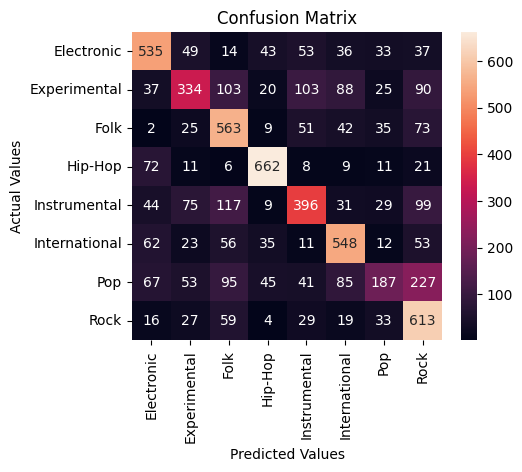

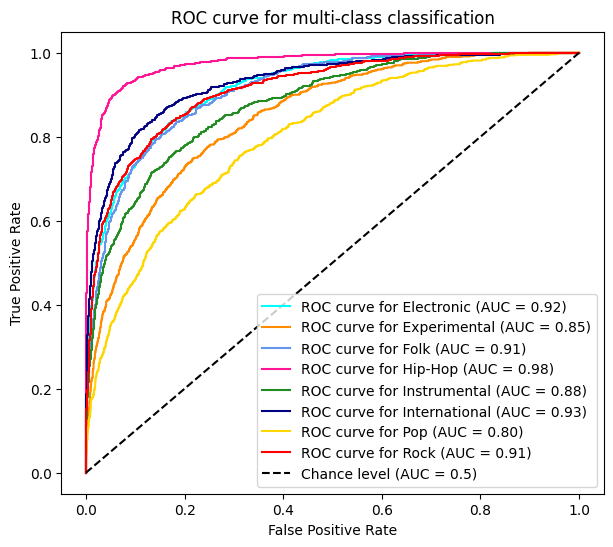

In [253]:
evaluate_network(train_dataloader, model, 'Training Dataset', config['batch_size'], major_vote_tr, true_tr, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:27<00:00,  7.50it/s]




								 ------- Validation Dataset ------- 
								   ------- Accuracy: 0.52 ------- 


               precision    recall  f1-score   support

   Electronic       0.48      0.67      0.56       100
 Experimental       0.44      0.57      0.50       100
         Folk       0.53      0.64      0.58       100
      Hip-Hop       0.69      0.63      0.66       100
 Instrumental       0.36      0.26      0.30       100
International       0.82      0.51      0.63       100
          Pop       0.16      0.08      0.11       100
         Rock       0.60      0.80      0.68       100

     accuracy                           0.52       800
    macro avg       0.51      0.52      0.50       800
 weighted avg       0.51      0.52      0.50       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            67.000000     57.000000   64.000000   63.000000     26.000000   
TN           628.000000    627.000000  644.000000  672.000000    653.000000   
FP            72.000000     73.000000   56.000000   28.000000     47.000000   
FN            33.000000     43.000000   36.000000   37.000000     74.000000   
TPR            0.670000      0.570000    0.640000    0.630000      0.260000   
Recall         0.670000      0.570000    0.640000    0.630000      0.260000   
Sensitivity    0.670000      0.570000    0.640000    0.630000      0.260000   
TNR            0.897143      0.895714    0.920000    0.960000      0.932857   
Specificity    0.897143      0.895714    0.920000    0.960000      0.932857   
FPR            0.102857      0.104286    0.080000    0.040000      0.067143   
FNR            0.330000      0.430000    0.360000    0.370000      0.740000   
PPV            0.482014      0.438462    0.533333    0.692308      0.356164   
Precision      0.482014      0.438462    0.533333    0.692308      0.356164   
F1 Score       0.560669      0.495652    0.581818    0.659686      0.300578   

             International         Pop        Rock  
TP               51.000000    8.000000   80.000000  
TN              689.000000  657.000000  646.000000  
FP               11.000000   43.000000   54.000000  
FN               49.000000   92.000000   20.000000  
TPR               0.510000    0.080000    0.800000  
Recall            0.510000    0.080000    0.800000  
Sensitivity       0.510000    0.080000    0.800000  
TNR               0.984286    0.938571    0.922857  
Specificity       0.984286    0.938571    0.922857  
FPR               0.015714    0.061429    0.077143  
FNR               0.490000    0.920000    0.200000  
PPV               0.822581    0.156863    0.597015  
Precision         0.822581    0.156863    0.597015  
F1 Score          0.629630    0.105960    0.683761

micro     macro  weighted
Precision   0.52  0.509842  0.509842
Recall      0.52  0.520000  0.520000
F1 Score    0.52  0.502219  0.502219

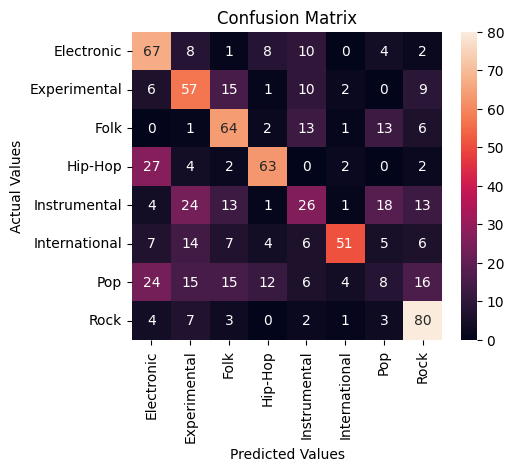

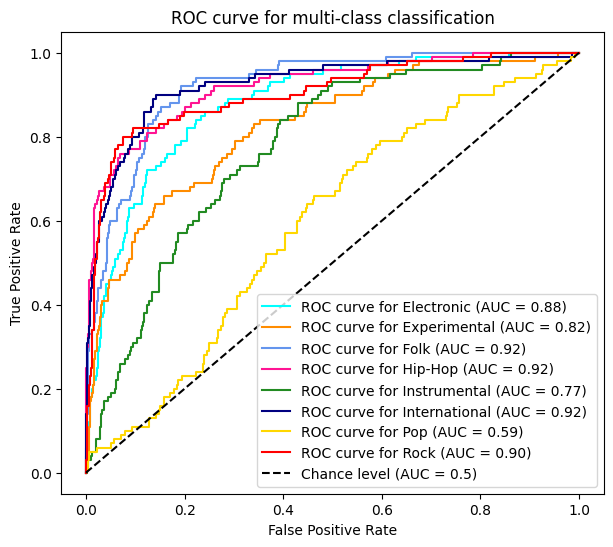

In [254]:
evaluate_network(val_dataloader, model, 'Validation Dataset', config['batch_size'], major_vote_val, true_val, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:27<00:00,  7.58it/s]




								 ------- Test Dataset ------- 
								   ------- Accuracy: 0.46125 ------- 


               precision    recall  f1-score   support

   Electronic       0.61      0.67      0.64       100
 Experimental       0.30      0.33      0.32       100
         Folk       0.24      0.30      0.27       100
      Hip-Hop       0.62      0.85      0.72       100
 Instrumental       0.33      0.30      0.31       100
International       0.68      0.45      0.54       100
          Pop       0.41      0.22      0.29       100
         Rock       0.52      0.57      0.55       100

     accuracy                           0.46       800
    macro avg       0.46      0.46      0.45       800
 weighted avg       0.46      0.46      0.45       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            67.000000     33.000000   30.000000   85.000000     30.000000   
TN           658.000000    624.000000  605.000000  648.000000    639.000000   
FP            42.000000     76.000000   95.000000   52.000000     61.000000   
FN            33.000000     67.000000   70.000000   15.000000     70.000000   
TPR            0.670000      0.330000    0.300000    0.850000      0.300000   
Recall         0.670000      0.330000    0.300000    0.850000      0.300000   
Sensitivity    0.670000      0.330000    0.300000    0.850000      0.300000   
TNR            0.940000      0.891429    0.864286    0.925714      0.912857   
Specificity    0.940000      0.891429    0.864286    0.925714      0.912857   
FPR            0.060000      0.108571    0.135714    0.074286      0.087143   
FNR            0.330000      0.670000    0.700000    0.150000      0.700000   
PPV            0.614679      0.302752    0.240000    0.620438      0.329670   
Precision      0.614679      0.302752    0.240000    0.620438      0.329670   
F1 Score       0.641148      0.315789    0.266667    0.717300      0.314136   

             International         Pop        Rock  
TP               45.000000   22.000000   57.000000  
TN              679.000000  668.000000  648.000000  
FP               21.000000   32.000000   52.000000  
FN               55.000000   78.000000   43.000000  
TPR               0.450000    0.220000    0.570000  
Recall            0.450000    0.220000    0.570000  
Sensitivity       0.450000    0.220000    0.570000  
TNR               0.970000    0.954286    0.925714  
Specificity       0.970000    0.954286    0.925714  
FPR               0.030000    0.045714    0.074286  
FNR               0.550000    0.780000    0.430000  
PPV               0.681818    0.407407    0.522936  
Precision         0.681818    0.407407    0.522936  
F1 Score          0.542169    0.285714    0.545455

micro     macro  weighted
Precision  0.46125  0.464963  0.464963
Recall     0.46125  0.461250  0.461250
F1 Score   0.46125  0.453547  0.453547

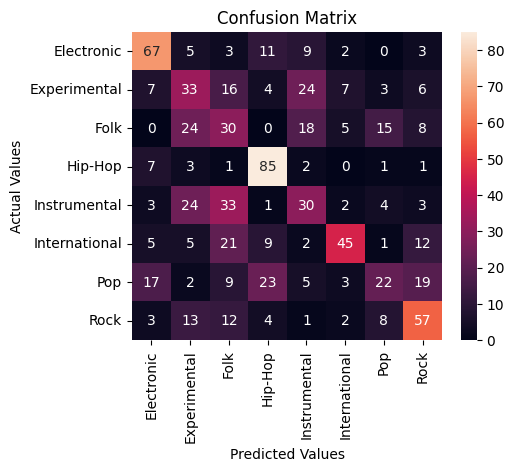

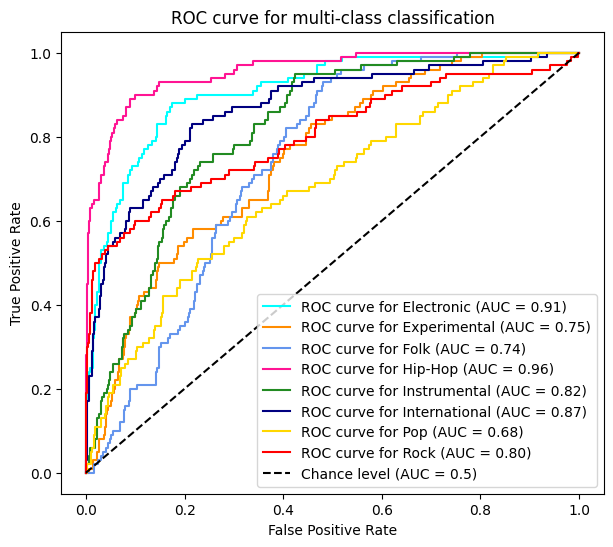

In [255]:
evaluate_network(test_dataloader, model, 'Test Dataset', config['batch_size'], major_vote_test, true_test, genres, figsize1=(5,4), figsize2=(7,6))

# Temporal ResNet1d

In [256]:
class Temporal_ResNet1d(Module):
    def __init__(self, drop=0.5, bias=False):
        super().__init__()
        self.network = Sequential(
            Conv1d(1, 128, kernel_size=3, stride=3, bias=bias),
            BatchNorm1d(128),

            Temporal_IdentityBlock1d(in_channels=128, filters=[128,128], kernel_size=3, dilation=2**0, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=128, filters=[128,128], kernel_size=3, dilation=2**1, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),

            Temporal_ConvolutionalBlock1d(in_channels=128, filters=[128,256], kernel_size=3, dilation=2**2, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**4, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**5, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**6, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**7, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),

            Temporal_ConvolutionalBlock1d(in_channels=256, filters=[256,512], kernel_size=3, dilation=2**8, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),

            Conv1d(512, 8, kernel_size=1, stride=1, bias=bias),
            Dropout(drop)
        )
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x)
        y = y.reshape((y.shape[0], -1))
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

## Training

In [257]:
run = wandb.init(project="NN&DL_project", entity="festaorlando", group="Temporal_ResNet1d")

config = dict(
    epochs=20,
    batch_size=50,
    learning_rate=0.004,
    weight_decay=1e-5,
    architecture="Temporal_ResNet1d")
wandb.config = config

In [258]:
# Wave data loader
train_dataloader = DataLoader(train_wave, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_wave, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_wave, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate the model, define the loss function and optimizer
model = Temporal_ResNet1d()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# true label tensors
true_tr = torch.tensor(labels_onehot_train.values)
true_val = torch.tensor(labels_onehot_val.values)
true_test = torch.tensor(labels_onehot_test.values)

cuda


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


best_val = 0
wandb.watch(model, log="all")   
for epoch in range(config['epochs']):
    print(f"\n\nEpoch: {epoch+1}")
    major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
    major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

    # Training
    model.train()
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_id in iterator:
        batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)
        wandb.log({'Running training loss':loss})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
        for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
    tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
    print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')
    wandb.log({'Training accuracy':tr_acc, 'Training error':1-tr_acc, 'Epoch':epoch+1})


    # Validation
    model.eval()
    with torch.no_grad():
        iterator = tqdm(val_dataloader)
        for batch_x, batch_y, batch_id in iterator:
            batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
            for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
    val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
    wandb.log({'Validation accuracy':val_acc, 'Validation error':1-val_acc, 'Epoch':epoch+1})
    print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

    if val_acc > best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "Temporal_ResNet1d.pt")
        best_val = val_acc

artifact = wandb.Artifact('Temporal_ResNet1d', type='model')
artifact.add_file('Temporal_ResNet1d.pt')
run.log_artifact(artifact)
run.finish()



Epoch: 1


Running training loss: 1.8475439548492432: 100%|██████████| 1664/1664 [07:44<00:00,  3.58it/s]


Training accuracy:0.29609376192092896   Training error:0.703906238079071


Running validation loss: 2.211027145385742: 100%|██████████| 208/208 [00:23<00:00,  8.81it/s]


Validation accuracy:0.29750001430511475   Validation error:0.7024999856948853
Saved Model


Epoch: 2


Running training loss: 1.8144545555114746: 100%|██████████| 1664/1664 [07:44<00:00,  3.58it/s]


Training accuracy:0.4104687571525574   Training error:0.5895312428474426


Running validation loss: 2.1599185466766357: 100%|██████████| 208/208 [00:23<00:00,  8.77it/s]


Validation accuracy:0.41999998688697815   Validation error:0.5800000429153442
Saved Model


Epoch: 3


Running training loss: 1.8996981382369995: 100%|██████████| 1664/1664 [07:45<00:00,  3.57it/s]


Training accuracy:0.46312499046325684   Training error:0.5368750095367432


Running validation loss: 1.9021999835968018: 100%|██████████| 208/208 [00:24<00:00,  8.34it/s]


Validation accuracy:0.3824999928474426   Validation error:0.6175000071525574


Epoch: 4


Running training loss: 1.7837748527526855: 100%|██████████| 1664/1664 [07:46<00:00,  3.57it/s]


Training accuracy:0.47062501311302185   Training error:0.5293749570846558


Running validation loss: 2.1261017322540283: 100%|██████████| 208/208 [00:25<00:00,  8.32it/s]


Validation accuracy:0.4387499988079071   Validation error:0.5612499713897705
Saved Model


Epoch: 5


Running training loss: 1.7704766988754272: 100%|██████████| 1664/1664 [07:45<00:00,  3.58it/s]


Training accuracy:0.4923437535762787   Training error:0.5076562166213989


Running validation loss: 2.1203572750091553: 100%|██████████| 208/208 [00:23<00:00,  8.78it/s]


Validation accuracy:0.42124998569488525   Validation error:0.5787500143051147


Epoch: 6


Running training loss: 1.765529751777649: 100%|██████████| 1664/1664 [07:43<00:00,  3.59it/s]


Training accuracy:0.5129687786102295   Training error:0.4870312213897705


Running validation loss: 2.319391965866089: 100%|██████████| 208/208 [00:23<00:00,  8.72it/s]


Validation accuracy:0.47874999046325684   Validation error:0.5212500095367432
Saved Model


Epoch: 7


Running training loss: 1.9081777334213257: 100%|██████████| 1664/1664 [07:44<00:00,  3.58it/s]


Training accuracy:0.5298437476158142   Training error:0.4701562523841858


Running validation loss: 1.9624340534210205: 100%|██████████| 208/208 [00:25<00:00,  8.31it/s]


Validation accuracy:0.4637500047683716   Validation error:0.5362499952316284


Epoch: 8


Running training loss: 1.7257039546966553: 100%|██████████| 1664/1664 [07:44<00:00,  3.58it/s]


Training accuracy:0.5384374856948853   Training error:0.46156251430511475


Running validation loss: 1.4145874977111816: 100%|██████████| 208/208 [00:23<00:00,  8.84it/s]


Validation accuracy:0.49125000834465027   Validation error:0.5087499618530273
Saved Model


Epoch: 9


Running training loss: 1.6700799465179443: 100%|██████████| 1664/1664 [07:44<00:00,  3.58it/s]


Training accuracy:0.5589062571525574   Training error:0.4410937428474426


Running validation loss: 2.1015846729278564: 100%|██████████| 208/208 [00:23<00:00,  8.72it/s]


Validation accuracy:0.4925000071525574   Validation error:0.5074999928474426
Saved Model


Epoch: 10


Running training loss: 1.9290695190429688: 100%|██████████| 1664/1664 [07:44<00:00,  3.58it/s]


Training accuracy:0.5653125047683716   Training error:0.4346874952316284


Running validation loss: 1.8215203285217285: 100%|██████████| 208/208 [00:23<00:00,  8.92it/s]


Validation accuracy:0.5024999976158142   Validation error:0.4975000023841858
Saved Model


Epoch: 11


Running training loss: 1.9402194023132324: 100%|██████████| 1664/1664 [07:46<00:00,  3.57it/s]


Training accuracy:0.5784375071525574   Training error:0.4215624928474426


Running validation loss: 1.9779396057128906: 100%|██████████| 208/208 [00:25<00:00,  8.23it/s]


Validation accuracy:0.5087500214576721   Validation error:0.4912499785423279
Saved Model


Epoch: 12


Running training loss: 1.8255642652511597: 100%|██████████| 1664/1664 [07:46<00:00,  3.56it/s]


Training accuracy:0.5790625214576721   Training error:0.4209374785423279


Running validation loss: 1.7497369050979614: 100%|██████████| 208/208 [00:24<00:00,  8.52it/s]


Validation accuracy:0.5087500214576721   Validation error:0.4912499785423279


Epoch: 13


Running training loss: 1.8776476383209229: 100%|██████████| 1664/1664 [07:44<00:00,  3.58it/s]


Training accuracy:0.5923437476158142   Training error:0.4076562523841858


Running validation loss: 1.8241868019104004: 100%|██████████| 208/208 [00:23<00:00,  8.95it/s]


Validation accuracy:0.53125   Validation error:0.46875
Saved Model


Epoch: 14


Running training loss: 1.71985924243927: 100%|██████████| 1664/1664 [07:45<00:00,  3.58it/s]


Training accuracy:0.598437488079071   Training error:0.40156251192092896


Running validation loss: 2.0095746517181396: 100%|██████████| 208/208 [00:26<00:00,  7.99it/s]


Validation accuracy:0.5087500214576721   Validation error:0.4912499785423279


Epoch: 15


Running training loss: 1.7268831729888916: 100%|██████████| 1664/1664 [07:47<00:00,  3.56it/s]


Training accuracy:0.6123437285423279   Training error:0.3876562714576721


Running validation loss: 1.8611414432525635: 100%|██████████| 208/208 [00:25<00:00,  8.19it/s]


Validation accuracy:0.5062500238418579   Validation error:0.4937499761581421


Epoch: 16


Running training loss: 1.7632176876068115: 100%|██████████| 1664/1664 [07:45<00:00,  3.57it/s]


Training accuracy:0.61328125   Training error:0.38671875


Running validation loss: 1.6420263051986694: 100%|██████████| 208/208 [00:25<00:00,  8.09it/s]


Validation accuracy:0.4937500059604645   Validation error:0.5062500238418579


Epoch: 17


Running training loss: 1.6172924041748047: 100%|██████████| 1664/1664 [07:46<00:00,  3.57it/s]


Training accuracy:0.6135937571525574   Training error:0.3864062428474426


Running validation loss: 1.799894094467163: 100%|██████████| 208/208 [00:25<00:00,  8.20it/s]


Validation accuracy:0.5337499976158142   Validation error:0.4662500023841858
Saved Model


Epoch: 18


Running training loss: 1.5352184772491455: 100%|██████████| 1664/1664 [07:46<00:00,  3.57it/s]


Training accuracy:0.6215624809265137   Training error:0.37843751907348633


Running validation loss: 1.931434154510498: 100%|██████████| 208/208 [00:25<00:00,  8.20it/s]


Validation accuracy:0.5074999928474426   Validation error:0.4925000071525574


Epoch: 19


Running training loss: 1.6876745223999023: 100%|██████████| 1664/1664 [07:43<00:00,  3.59it/s]


Training accuracy:0.6207812428474426   Training error:0.3792187571525574


Running validation loss: 1.6988672018051147: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Validation accuracy:0.48875001072883606   Validation error:0.5112500190734863


Epoch: 20


Running training loss: 1.8229241371154785: 100%|██████████| 1664/1664 [07:43<00:00,  3.59it/s]


Training accuracy:0.6268749833106995   Training error:0.37312501668930054


Running validation loss: 2.0820212364196777: 100%|██████████| 208/208 [00:22<00:00,  9.08it/s]


Validation accuracy:0.5199999809265137   Validation error:0.48000001907348633


## Evaluate & Testing

In [259]:
model = Temporal_ResNet1d()
model.to(device)
model.load_state_dict(torch.load("Temporal_ResNet1d.pt"))

major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))
major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))
major_vote_test = dict(zip(labels_onehot_test.reset_index().track_id, torch.zeros(labels_onehot_test.shape[0], len(genres))))

100%|██████████| 1664/1664 [03:46<00:00,  7.35it/s]




								 ------- Training Dataset ------- 
								   ------- Accuracy: 0.61515625 ------- 


               precision    recall  f1-score   support

   Electronic       0.75      0.68      0.71       800
 Experimental       0.61      0.34      0.44       800
         Folk       0.58      0.71      0.64       800
      Hip-Hop       0.88      0.79      0.83       800
 Instrumental       0.56      0.62      0.59       800
International       0.52      0.82      0.64       800
          Pop       0.66      0.16      0.26       800
         Rock       0.53      0.79      0.64       800

     accuracy                           0.62      6400
    macro avg       0.64      0.62      0.59      6400
 weighted avg       0.64      0.62      0.59      6400



Electronic  Experimental         Folk      Hip-Hop  \
TP            543.000000    276.000000   572.000000   629.000000   
TN           5418.000000   5427.000000  5191.000000  5514.000000   
FP            182.000000    173.000000   409.000000    86.000000   
FN            257.000000    524.000000   228.000000   171.000000   
TPR             0.678750      0.345000     0.715000     0.786250   
Recall          0.678750      0.345000     0.715000     0.786250   
Sensitivity     0.678750      0.345000     0.715000     0.786250   
TNR             0.967500      0.969107     0.926964     0.984643   
Specificity     0.967500      0.969107     0.926964     0.984643   
FPR             0.032500      0.030893     0.073036     0.015357   
FNR             0.321250      0.655000     0.285000     0.213750   
PPV             0.748966      0.614699     0.583078     0.879720   
Precision       0.748966      0.614699     0.583078     0.879720   
F1 Score        0.712131      0.441954     0.642336     0.830363   

             Instrumental  International          Pop         Rock  
TP             495.000000     657.000000   130.000000   635.000000  
TN            5216.000000    4990.000000  5534.000000  5047.000000  
FP             384.000000     610.000000    66.000000   553.000000  
FN             305.000000     143.000000   670.000000   165.000000  
TPR              0.618750       0.821250     0.162500     0.793750  
Recall           0.618750       0.821250     0.162500     0.793750  
Sensitivity      0.618750       0.821250     0.162500     0.793750  
TNR              0.931429       0.891071     0.988214     0.901250  
Specificity      0.931429       0.891071     0.988214     0.901250  
FPR              0.068571       0.108929     0.011786     0.098750  
FNR              0.381250       0.178750     0.837500     0.206250  
PPV              0.563140       0.518548     0.663265     0.534512  
Precision        0.563140       0.518548     0.663265     0.534512  
F1 Score         0.589637       0.635704     0.261044     0.638833

micro     macro  weighted
Precision  0.615156  0.638241  0.638241
Recall     0.615156  0.615156  0.615156
F1 Score   0.615156  0.594000  0.594000

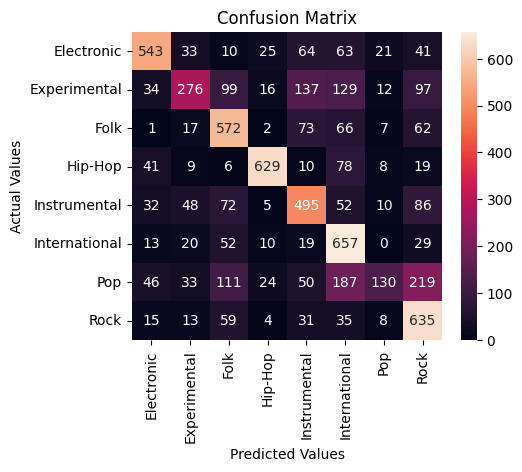

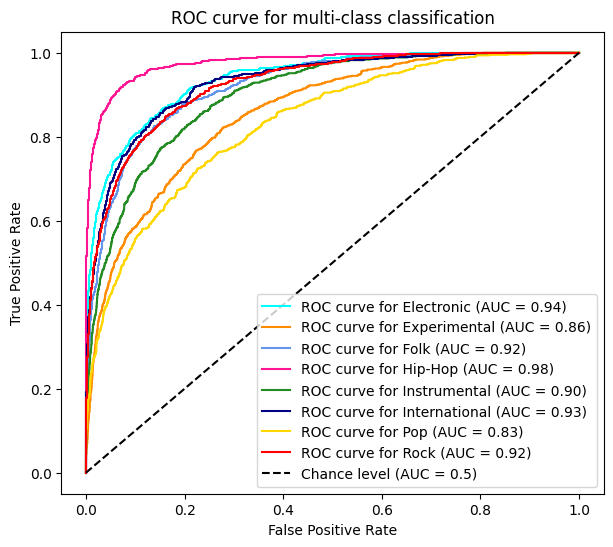

In [260]:
evaluate_network(train_dataloader, model, 'Training Dataset', config['batch_size'], major_vote_tr, true_tr, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:28<00:00,  7.36it/s]




								 ------- Validation Dataset ------- 
								   ------- Accuracy: 0.53375 ------- 


               precision    recall  f1-score   support

   Electronic       0.46      0.53      0.50       100
 Experimental       0.51      0.46      0.48       100
         Folk       0.60      0.79      0.68       100
      Hip-Hop       0.80      0.56      0.66       100
 Instrumental       0.40      0.38      0.39       100
International       0.53      0.69      0.60       100
          Pop       0.22      0.04      0.07       100
         Rock       0.55      0.82      0.66       100

     accuracy                           0.53       800
    macro avg       0.51      0.53      0.50       800
 weighted avg       0.51      0.53      0.50       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            53.000000     46.000000   79.000000   56.000000     38.000000   
TN           639.000000    655.000000  647.000000  686.000000    643.000000   
FP            61.000000     45.000000   53.000000   14.000000     57.000000   
FN            47.000000     54.000000   21.000000   44.000000     62.000000   
TPR            0.530000      0.460000    0.790000    0.560000      0.380000   
Recall         0.530000      0.460000    0.790000    0.560000      0.380000   
Sensitivity    0.530000      0.460000    0.790000    0.560000      0.380000   
TNR            0.912857      0.935714    0.924286    0.980000      0.918571   
Specificity    0.912857      0.935714    0.924286    0.980000      0.918571   
FPR            0.087143      0.064286    0.075714    0.020000      0.081429   
FNR            0.470000      0.540000    0.210000    0.440000      0.620000   
PPV            0.464912      0.505495    0.598485    0.800000      0.400000   
Precision      0.464912      0.505495    0.598485    0.800000      0.400000   
F1 Score       0.495327      0.481675    0.681034    0.658824      0.389744   

             International         Pop        Rock  
TP               69.000000    4.000000   82.000000  
TN              639.000000  686.000000  632.000000  
FP               61.000000   14.000000   68.000000  
FN               31.000000   96.000000   18.000000  
TPR               0.690000    0.040000    0.820000  
Recall            0.690000    0.040000    0.820000  
Sensitivity       0.690000    0.040000    0.820000  
TNR               0.912857    0.980000    0.902857  
Specificity       0.912857    0.980000    0.902857  
FPR               0.087143    0.020000    0.097143  
FNR               0.310000    0.960000    0.180000  
PPV               0.530769    0.222222    0.546667  
Precision         0.530769    0.222222    0.546667  
F1 Score          0.600000    0.067797    0.656000

micro     macro  weighted
Precision  0.53375  0.508569  0.508569
Recall     0.53375  0.533750  0.533750
F1 Score   0.53375  0.503800  0.503800

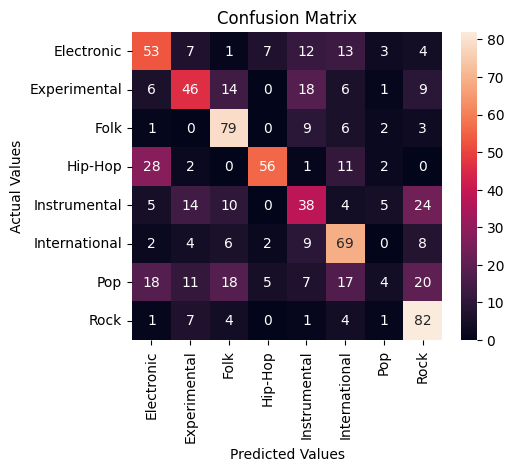

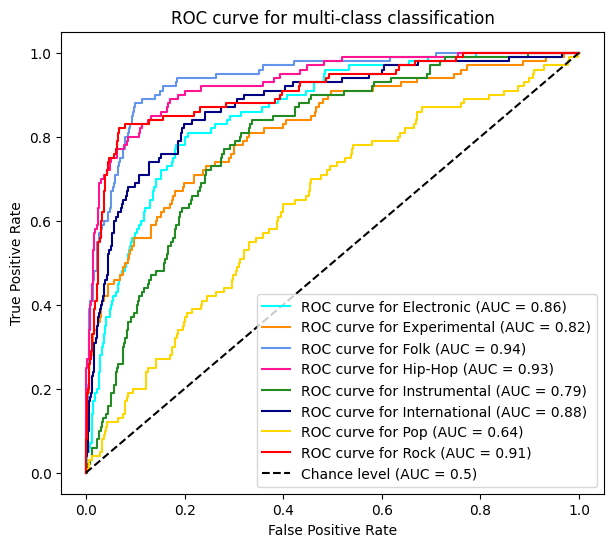

In [261]:
evaluate_network(val_dataloader, model, 'Validation Dataset', config['batch_size'], major_vote_val, true_val, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:27<00:00,  7.69it/s]



								 ------- Test Dataset ------- 
								   ------- Accuracy: 0.42875 ------- 


               precision    recall  f1-score   support

   Electronic       0.58      0.53      0.55       100
 Experimental       0.35      0.23      0.28       100
         Folk       0.25      0.36      0.30       100
      Hip-Hop       0.73      0.80      0.76       100
 Instrumental       0.29      0.27      0.28       100
International       0.40      0.61      0.48       100
          Pop       0.13      0.03      0.05       100
         Rock       0.49      0.60      0.54       100

     accuracy                           0.43       800
    macro avg       0.40      0.43      0.41       800
 weighted avg       0.40      0.43      0.41       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            53.000000     23.000000   36.000000   80.000000     27.000000   
TN           662.000000    658.000000  592.000000  670.000000    635.000000   
FP            38.000000     42.000000  108.000000   30.000000     65.000000   
FN            47.000000     77.000000   64.000000   20.000000     73.000000   
TPR            0.530000      0.230000    0.360000    0.800000      0.270000   
Recall         0.530000      0.230000    0.360000    0.800000      0.270000   
Sensitivity    0.530000      0.230000    0.360000    0.800000      0.270000   
TNR            0.945714      0.940000    0.845714    0.957143      0.907143   
Specificity    0.945714      0.940000    0.845714    0.957143      0.907143   
FPR            0.054286      0.060000    0.154286    0.042857      0.092857   
FNR            0.470000      0.770000    0.640000    0.200000      0.730000   
PPV            0.582418      0.353846    0.250000    0.727273      0.293478   
Precision      0.582418      0.353846    0.250000    0.727273      0.293478   
F1 Score       0.554974      0.278788    0.295082    0.761905      0.281250   

             International         Pop        Rock  
TP               61.000000    3.000000   60.000000  
TN              608.000000  680.000000  638.000000  
FP               92.000000   20.000000   62.000000  
FN               39.000000   97.000000   40.000000  
TPR               0.610000    0.030000    0.600000  
Recall            0.610000    0.030000    0.600000  
Sensitivity       0.610000    0.030000    0.600000  
TNR               0.868571    0.971429    0.911429  
Specificity       0.868571    0.971429    0.911429  
FPR               0.131429    0.028571    0.088571  
FNR               0.390000    0.970000    0.400000  
PPV               0.398693    0.130435    0.491803  
Precision         0.398693    0.130435    0.491803  
F1 Score          0.482213    0.048780    0.540541

micro     macro  weighted
Precision  0.42875  0.403493  0.403493
Recall     0.42875  0.428750  0.428750
F1 Score   0.42875  0.405442  0.405442

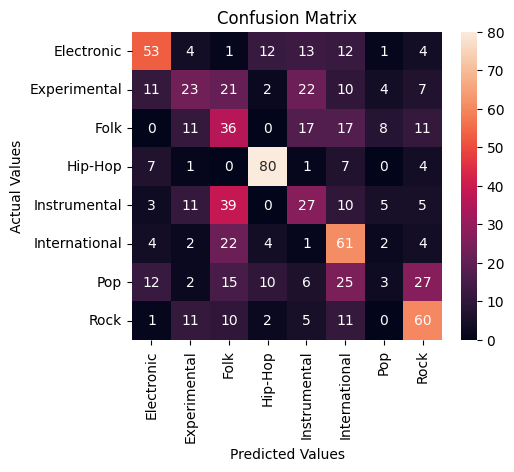

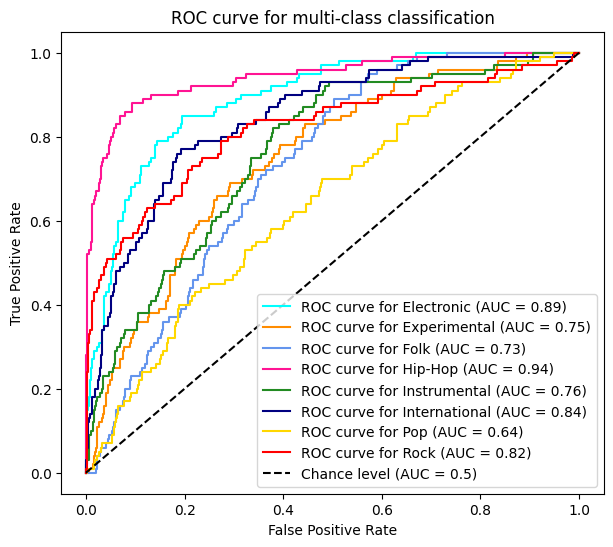

In [262]:
evaluate_network(test_dataloader, model, 'Test Dataset', config['batch_size'], major_vote_test, true_test, genres, figsize1=(5,4), figsize2=(7,6))

# Temporal ResNet1d + Sinc Conv filter

In [263]:
class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.
    Usage
    -----
    See `torch.nn.Conv1d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=50, min_band_hz=50):

        super(SincConv_fast,self).__init__()

        if in_channels != 1:
            #msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel)


        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        #self.window_ = torch.hamming_window(self.kernel_size)
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);


        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes




    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz  + torch.abs(self.low_hz_)

        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]

        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations.
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])


        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)


        band_pass = band_pass / (2*band[:,None])


        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)

In [264]:
class Temporal_ResNet1d_filt(Module):
    def __init__(self, drop=0.5, bias=False):
        super().__init__()
        self.network = Sequential(
            SincConv_fast(out_channels=128, kernel_size=251, stride=3, sample_rate=22050),
            BatchNorm1d(128),

            Temporal_IdentityBlock1d(in_channels=128, filters=[128,128], kernel_size=3, dilation=2**0, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=128, filters=[128,128], kernel_size=3, dilation=2**1, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),

            Temporal_ConvolutionalBlock1d(in_channels=128, filters=[128,256], kernel_size=3, dilation=2**2, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**3, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**4, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**5, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**6, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),
            Temporal_IdentityBlock1d(in_channels=256, filters=[256,256], kernel_size=3, dilation=2**7, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),

            Temporal_ConvolutionalBlock1d(in_channels=256, filters=[256,512], kernel_size=3, dilation=2**8, bias=bias),
            MixedPooling1d(kernel_size=3, stride=3),

            Conv1d(512, 8, kernel_size=1, stride=1, bias=bias),
            Dropout(drop),
        )
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x)
        y = y.reshape((y.shape[0], -1))
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv1d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

## Training

In [265]:
run = wandb.init(project="NN&DL_project", entity="festaorlando", group="Temporal_ResNet1d_filt")

config = dict(
    epochs=20,
    batch_size=50,
    learning_rate=0.004,
    weight_decay=1e-5,
    architecture="Temporal_ResNet1d_filt")
wandb.config = config

In [266]:
# Wave data loader
train_dataloader = DataLoader(train_wave, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_wave, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_wave, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate the model, define the loss function and optimizer
model = Temporal_ResNet1d_filt()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# true label tensors
true_tr = torch.tensor(labels_onehot_train.values)
true_val = torch.tensor(labels_onehot_val.values)
true_test = torch.tensor(labels_onehot_test.values)

cuda


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


best_val = 0
wandb.watch(model, log="all")  
for epoch in range(config['epochs']):
    print(f"\n\nEpoch: {epoch+1}")
    major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
    major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

    # Training
    model.train()
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_id in iterator:
        batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)
        wandb.log({'Running training loss':loss})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
        for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
    tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
    print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')
    wandb.log({'Training accuracy':tr_acc, 'Training error':1-tr_acc, 'Epoch':epoch+1})


    # Validation
    model.eval()
    with torch.no_grad():
        iterator = tqdm(val_dataloader)
        for batch_x, batch_y, batch_id in iterator:
            batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
            for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
    val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
    wandb.log({'Validation accuracy':val_acc, 'Validation error':1-val_acc, 'Epoch':epoch+1})
    print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

    if val_acc > best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "Temporal_ResNet1d_filt.pt")
        best_val = val_acc

artifact = wandb.Artifact('Temporal_ResNet1d_filt', type='model')
artifact.add_file('Temporal_ResNet1d_filt.pt')
run.log_artifact(artifact)
run.finish()



Epoch: 1


Running training loss: 1.869631052017212: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.30250000953674316   Training error:0.6974999904632568


Running validation loss: 2.227917432785034: 100%|██████████| 208/208 [00:23<00:00,  8.83it/s]


Validation accuracy:0.2737500071525574   Validation error:0.7262499928474426
Saved Model


Epoch: 2


Running training loss: 1.8337773084640503: 100%|██████████| 1664/1664 [08:42<00:00,  3.19it/s]


Training accuracy:0.41718751192092896   Training error:0.582812488079071


Running validation loss: 2.141260862350464: 100%|██████████| 208/208 [00:25<00:00,  8.02it/s]


Validation accuracy:0.4037500023841858   Validation error:0.5962499976158142
Saved Model


Epoch: 3


Running training loss: 1.8004122972488403: 100%|██████████| 1664/1664 [08:42<00:00,  3.18it/s]


Training accuracy:0.45249998569488525   Training error:0.5475000143051147


Running validation loss: 2.010467529296875: 100%|██████████| 208/208 [00:25<00:00,  8.08it/s]


Validation accuracy:0.4137499928474426   Validation error:0.5862500071525574
Saved Model


Epoch: 4


Running training loss: 1.7943836450576782: 100%|██████████| 1664/1664 [08:42<00:00,  3.19it/s]


Training accuracy:0.4820312559604645   Training error:0.5179687738418579


Running validation loss: 2.2729697227478027: 100%|██████████| 208/208 [00:24<00:00,  8.46it/s]


Validation accuracy:0.46000000834465027   Validation error:0.5399999618530273
Saved Model


Epoch: 5


Running training loss: 1.7367818355560303: 100%|██████████| 1664/1664 [08:42<00:00,  3.18it/s]


Training accuracy:0.4976562559604645   Training error:0.5023437738418579


Running validation loss: 2.1251237392425537: 100%|██████████| 208/208 [00:25<00:00,  8.14it/s]


Validation accuracy:0.4449999928474426   Validation error:0.5550000071525574


Epoch: 6


Running training loss: 1.7252804040908813: 100%|██████████| 1664/1664 [08:42<00:00,  3.18it/s]


Training accuracy:0.5199999809265137   Training error:0.48000001907348633


Running validation loss: 2.389880657196045: 100%|██████████| 208/208 [00:23<00:00,  8.78it/s]


Validation accuracy:0.4437499940395355   Validation error:0.5562499761581421


Epoch: 7


Running training loss: 1.9011847972869873: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.5325000286102295   Training error:0.4674999713897705


Running validation loss: 2.4009106159210205: 100%|██████████| 208/208 [00:24<00:00,  8.43it/s]


Validation accuracy:0.49125000834465027   Validation error:0.5087499618530273
Saved Model


Epoch: 8


Running training loss: 1.731990933418274: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.5496875047683716   Training error:0.4503124952316284


Running validation loss: 1.886108636856079: 100%|██████████| 208/208 [00:24<00:00,  8.64it/s]


Validation accuracy:0.4749999940395355   Validation error:0.5249999761581421


Epoch: 9


Running training loss: 1.6658755540847778: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.5628125071525574   Training error:0.4371874928474426


Running validation loss: 2.308972120285034: 100%|██████████| 208/208 [00:24<00:00,  8.61it/s]


Validation accuracy:0.5112500190734863   Validation error:0.48874998092651367
Saved Model


Epoch: 10


Running training loss: 1.8458529710769653: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.5753124952316284   Training error:0.4246875047683716


Running validation loss: 2.0836281776428223: 100%|██████████| 208/208 [00:24<00:00,  8.54it/s]


Validation accuracy:0.5074999928474426   Validation error:0.4925000071525574


Epoch: 11


Running training loss: 1.913530945777893: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.5803124904632568   Training error:0.41968750953674316


Running validation loss: 2.065433979034424: 100%|██████████| 208/208 [00:24<00:00,  8.50it/s]


Validation accuracy:0.5   Validation error:0.5


Epoch: 12


Running training loss: 1.8464168310165405: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.5848437547683716   Training error:0.4151562452316284


Running validation loss: 1.7777330875396729: 100%|██████████| 208/208 [00:25<00:00,  8.21it/s]


Validation accuracy:0.5024999976158142   Validation error:0.4975000023841858


Epoch: 13


Running training loss: 1.8419225215911865: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.5990625023841858   Training error:0.4009374976158142


Running validation loss: 1.781567096710205: 100%|██████████| 208/208 [00:24<00:00,  8.41it/s]


Validation accuracy:0.5137500166893005   Validation error:0.48624998331069946
Saved Model


Epoch: 14


Running training loss: 1.7096813917160034: 100%|██████████| 1664/1664 [08:41<00:00,  3.19it/s]


Training accuracy:0.6073437333106995   Training error:0.39265626668930054


Running validation loss: 2.186340570449829: 100%|██████████| 208/208 [00:24<00:00,  8.33it/s]


Validation accuracy:0.47999998927116394   Validation error:0.5199999809265137


Epoch: 15


Running training loss: 1.6478158235549927: 100%|██████████| 1664/1664 [08:40<00:00,  3.20it/s]


Training accuracy:0.6160937547683716   Training error:0.3839062452316284


Running validation loss: 1.7607488632202148: 100%|██████████| 208/208 [00:24<00:00,  8.35it/s]


Validation accuracy:0.5112500190734863   Validation error:0.48874998092651367


Epoch: 16


Running training loss: 1.7811832427978516: 100%|██████████| 1664/1664 [08:40<00:00,  3.20it/s]


Training accuracy:0.62109375   Training error:0.37890625


Running validation loss: 1.8763338327407837: 100%|██████████| 208/208 [00:25<00:00,  8.25it/s]


Validation accuracy:0.5099999904632568   Validation error:0.49000000953674316


Epoch: 17


Running training loss: 1.660199522972107: 100%|██████████| 1664/1664 [08:40<00:00,  3.20it/s]


Training accuracy:0.621874988079071   Training error:0.37812501192092896


Running validation loss: 1.8345692157745361: 100%|██████████| 208/208 [00:24<00:00,  8.56it/s]


Validation accuracy:0.5049999952316284   Validation error:0.4950000047683716


Epoch: 18


Running training loss: 1.5730782747268677: 100%|██████████| 1664/1664 [08:40<00:00,  3.20it/s]


Training accuracy:0.6314062476158142   Training error:0.3685937523841858


Running validation loss: 1.7912722826004028: 100%|██████████| 208/208 [00:24<00:00,  8.38it/s]


Validation accuracy:0.5199999809265137   Validation error:0.48000001907348633
Saved Model


Epoch: 19


Running training loss: 1.7657912969589233: 100%|██████████| 1664/1664 [08:42<00:00,  3.18it/s]


Training accuracy:0.6356250047683716   Training error:0.3643749952316284


Running validation loss: 1.6927340030670166: 100%|██████████| 208/208 [00:24<00:00,  8.33it/s]


Validation accuracy:0.47749999165534973   Validation error:0.5225000381469727


Epoch: 20


Running training loss: 1.7436683177947998: 100%|██████████| 1664/1664 [08:42<00:00,  3.19it/s]


Training accuracy:0.6318749785423279   Training error:0.3681250214576721


Running validation loss: 2.046627998352051: 100%|██████████| 208/208 [00:24<00:00,  8.42it/s]


Validation accuracy:0.4962500035762787   Validation error:0.5037499666213989


## Evaluate & Testing

In [267]:
model = Temporal_ResNet1d_filt()
model.to(device)
model.load_state_dict(torch.load("Temporal_ResNet1d_filt.pt"))

major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))
major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))
major_vote_test = dict(zip(labels_onehot_test.reset_index().track_id, torch.zeros(labels_onehot_test.shape[0], len(genres))))

100%|██████████| 1664/1664 [03:46<00:00,  7.36it/s]




								 ------- Training Dataset ------- 
								   ------- Accuracy: 0.62765625 ------- 


               precision    recall  f1-score   support

   Electronic       0.72      0.67      0.69       800
 Experimental       0.63      0.40      0.49       800
         Folk       0.56      0.67      0.61       800
      Hip-Hop       0.76      0.87      0.81       800
 Instrumental       0.44      0.75      0.55       800
International       0.71      0.69      0.70       800
          Pop       0.69      0.29      0.41       800
         Rock       0.69      0.70      0.70       800

     accuracy                           0.63      6400
    macro avg       0.65      0.63      0.62      6400
 weighted avg       0.65      0.63      0.62      6400



Electronic  Experimental         Folk      Hip-Hop  \
TP            533.000000    319.000000   533.000000   696.000000   
TN           5389.000000   5409.000000  5178.000000  5379.000000   
FP            211.000000    191.000000   422.000000   221.000000   
FN            267.000000    481.000000   267.000000   104.000000   
TPR             0.666250      0.398750     0.666250     0.870000   
Recall          0.666250      0.398750     0.666250     0.870000   
Sensitivity     0.666250      0.398750     0.666250     0.870000   
TNR             0.962321      0.965893     0.924643     0.960536   
Specificity     0.962321      0.965893     0.924643     0.960536   
FPR             0.037679      0.034107     0.075357     0.039464   
FNR             0.333750      0.601250     0.333750     0.130000   
PPV             0.716398      0.625490     0.558115     0.758997   
Precision       0.716398      0.625490     0.558115     0.758997   
F1 Score        0.690415      0.487023     0.607407     0.810716   

             Instrumental  International          Pop         Rock  
TP             598.000000     548.000000   230.000000   560.000000  
TN            4835.000000    5379.000000  5497.000000  5351.000000  
FP             765.000000     221.000000   103.000000   249.000000  
FN             202.000000     252.000000   570.000000   240.000000  
TPR              0.747500       0.685000     0.287500     0.700000  
Recall           0.747500       0.685000     0.287500     0.700000  
Sensitivity      0.747500       0.685000     0.287500     0.700000  
TNR              0.863393       0.960536     0.981607     0.955536  
Specificity      0.863393       0.960536     0.981607     0.955536  
FPR              0.136607       0.039464     0.018393     0.044464  
FNR              0.252500       0.315000     0.712500     0.300000  
PPV              0.438738       0.712614     0.690691     0.692213  
Precision        0.438738       0.712614     0.690691     0.692213  
F1 Score         0.552936       0.698534     0.406002     0.696085

micro     macro  weighted
Precision  0.627656  0.649157  0.649157
Recall     0.627656  0.627656  0.627656
F1 Score   0.627656  0.618640  0.618640

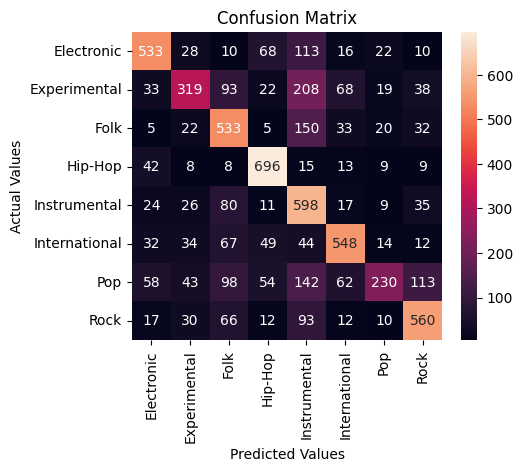

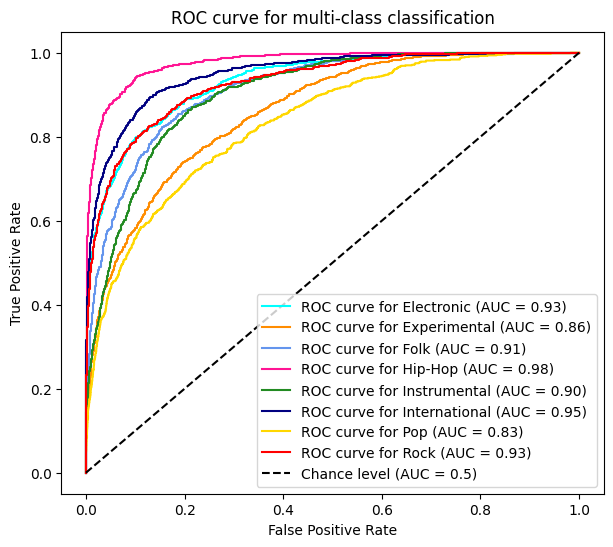

In [268]:
evaluate_network(train_dataloader, model, 'Training Dataset', config['batch_size'], major_vote_tr, true_tr, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:27<00:00,  7.49it/s]




								 ------- Validation Dataset ------- 
								   ------- Accuracy: 0.52 ------- 


               precision    recall  f1-score   support

   Electronic       0.43      0.57      0.49       100
 Experimental       0.40      0.49      0.44       100
         Folk       0.54      0.66      0.59       100
      Hip-Hop       0.72      0.63      0.67       100
 Instrumental       0.41      0.47      0.44       100
International       0.81      0.52      0.63       100
          Pop       0.25      0.14      0.18       100
         Rock       0.67      0.68      0.68       100

     accuracy                           0.52       800
    macro avg       0.53      0.52      0.52       800
 weighted avg       0.53      0.52      0.52       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            57.000000     49.000000   66.000000   63.000000     47.000000   
TN           625.000000    628.000000  644.000000  675.000000    632.000000   
FP            75.000000     72.000000   56.000000   25.000000     68.000000   
FN            43.000000     51.000000   34.000000   37.000000     53.000000   
TPR            0.570000      0.490000    0.660000    0.630000      0.470000   
Recall         0.570000      0.490000    0.660000    0.630000      0.470000   
Sensitivity    0.570000      0.490000    0.660000    0.630000      0.470000   
TNR            0.892857      0.897143    0.920000    0.964286      0.902857   
Specificity    0.892857      0.897143    0.920000    0.964286      0.902857   
FPR            0.107143      0.102857    0.080000    0.035714      0.097143   
FNR            0.430000      0.510000    0.340000    0.370000      0.530000   
PPV            0.431818      0.404959    0.540984    0.715909      0.408696   
Precision      0.431818      0.404959    0.540984    0.715909      0.408696   
F1 Score       0.491379      0.443439    0.594595    0.670213      0.437209   

             International         Pop        Rock  
TP               52.000000   14.000000   68.000000  
TN              688.000000  657.000000  667.000000  
FP               12.000000   43.000000   33.000000  
FN               48.000000   86.000000   32.000000  
TPR               0.520000    0.140000    0.680000  
Recall            0.520000    0.140000    0.680000  
Sensitivity       0.520000    0.140000    0.680000  
TNR               0.982857    0.938571    0.952857  
Specificity       0.982857    0.938571    0.952857  
FPR               0.017143    0.061429    0.047143  
FNR               0.480000    0.860000    0.320000  
PPV               0.812500    0.245614    0.673267  
Precision         0.812500    0.245614    0.673267  
F1 Score          0.634146    0.178344    0.676617

micro     macro  weighted
Precision   0.52  0.529218  0.529218
Recall      0.52  0.520000  0.520000
F1 Score    0.52  0.515743  0.515743

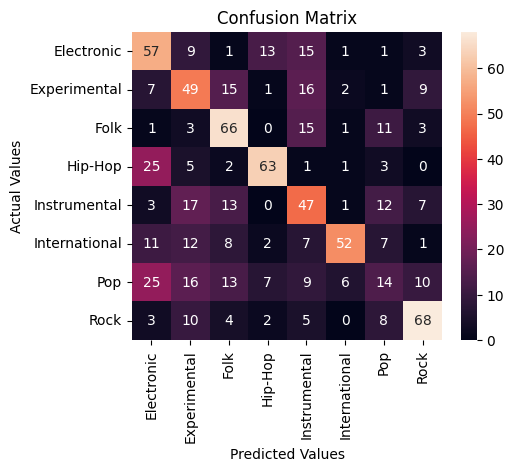

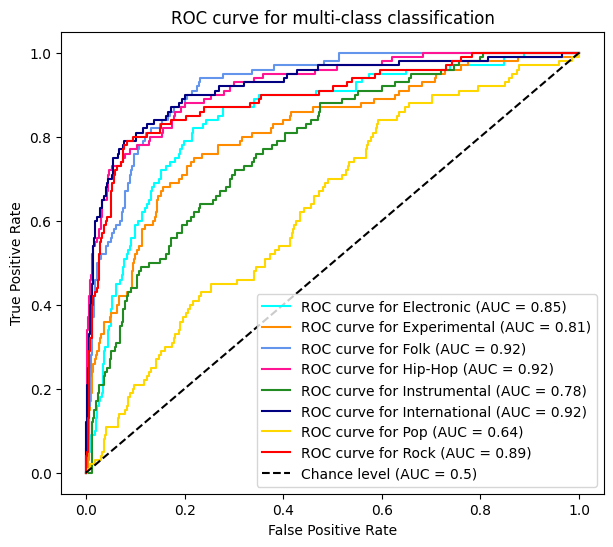

In [269]:
evaluate_network(val_dataloader, model, 'Validation Dataset', config['batch_size'], major_vote_val, true_val, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:27<00:00,  7.46it/s]



								 ------- Test Dataset ------- 
								   ------- Accuracy: 0.44125 ------- 


               precision    recall  f1-score   support

   Electronic       0.59      0.58      0.59       100
 Experimental       0.36      0.30      0.33       100
         Folk       0.32      0.35      0.33       100
      Hip-Hop       0.56      0.85      0.68       100
 Instrumental       0.26      0.34      0.29       100
International       0.63      0.46      0.53       100
          Pop       0.21      0.14      0.17       100
         Rock       0.59      0.51      0.55       100

     accuracy                           0.44       800
    macro avg       0.44      0.44      0.43       800
 weighted avg       0.44      0.44      0.43       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            58.000000     30.000000   35.000000   85.000000     34.000000   
TN           660.000000    647.000000  624.000000  634.000000    602.000000   
FP            40.000000     53.000000   76.000000   66.000000     98.000000   
FN            42.000000     70.000000   65.000000   15.000000     66.000000   
TPR            0.580000      0.300000    0.350000    0.850000      0.340000   
Recall         0.580000      0.300000    0.350000    0.850000      0.340000   
Sensitivity    0.580000      0.300000    0.350000    0.850000      0.340000   
TNR            0.942857      0.924286    0.891429    0.905714      0.860000   
Specificity    0.942857      0.924286    0.891429    0.905714      0.860000   
FPR            0.057143      0.075714    0.108571    0.094286      0.140000   
FNR            0.420000      0.700000    0.650000    0.150000      0.660000   
PPV            0.591837      0.361446    0.315315    0.562914      0.257576   
Precision      0.591837      0.361446    0.315315    0.562914      0.257576   
F1 Score       0.585859      0.327869    0.331754    0.677291      0.293103   

             International         Pop        Rock  
TP               46.000000   14.000000   51.000000  
TN              673.000000  648.000000  665.000000  
FP               27.000000   52.000000   35.000000  
FN               54.000000   86.000000   49.000000  
TPR               0.460000    0.140000    0.510000  
Recall            0.460000    0.140000    0.510000  
Sensitivity       0.460000    0.140000    0.510000  
TNR               0.961429    0.925714    0.950000  
Specificity       0.961429    0.925714    0.950000  
FPR               0.038571    0.074286    0.050000  
FNR               0.540000    0.860000    0.490000  
PPV               0.630137    0.212121    0.593023  
Precision         0.630137    0.212121    0.593023  
F1 Score          0.531792    0.168675    0.548387

micro     macro  weighted
Precision  0.44125  0.440546  0.440546
Recall     0.44125  0.441250  0.441250
F1 Score   0.44125  0.433091  0.433091

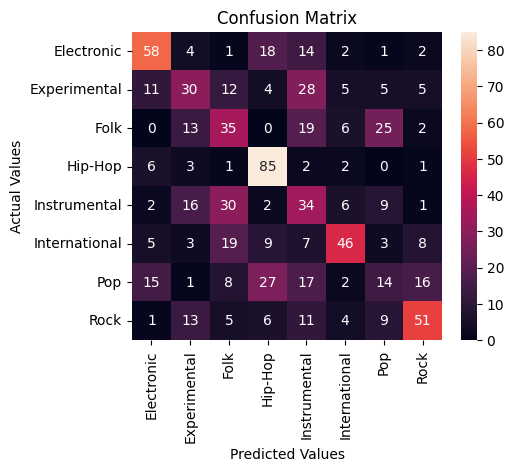

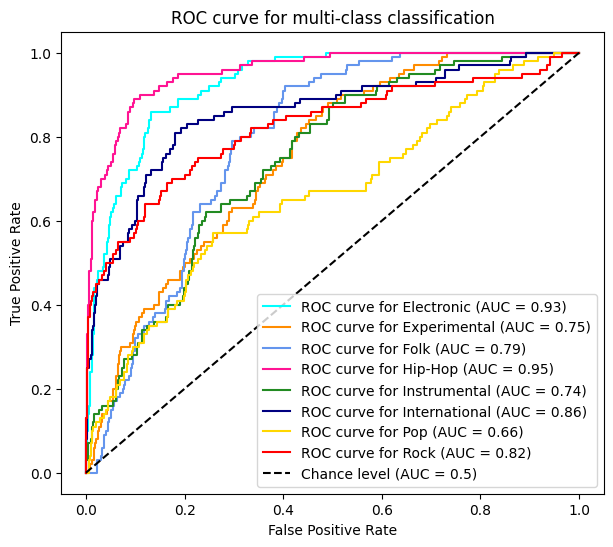

In [270]:
evaluate_network(test_dataloader, model, 'Test Dataset', config['batch_size'], major_vote_test, true_test, genres, figsize1=(5,4), figsize2=(7,6))

# Temporal ResNet2D_Mel

In [271]:
class Temporal_ResNet2d_Mel(Module):
    def __init__(self, drop=0.2, bias=False):
        super().__init__()
        self.network = Sequential(
            Conv2d(1, 64, kernel_size=7, stride=2, bias=bias),
            BatchNorm2d(64),
            MixedPooling2d(kernel_size=3, stride=2),

            Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**0, bias=bias),
            Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**1, bias=bias),
            Temporal_ConvolutionalBlock2d(in_freq_shape=30, in_channels=64, filters=[64,128], kernel_size=(3,3), stride=1, dilation=2**2, bias=bias),
            MixedPooling2d(kernel_size=3, stride=2),
            Dropout(drop),

            Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**3, bias=bias),
            Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**4, bias=bias),
            Temporal_ConvolutionalBlock2d(in_freq_shape=12, in_channels=128, filters=[128,256], kernel_size=(3,3), stride=1, dilation=2**5, bias=bias),
            MixedPooling2d(kernel_size=3, stride=2),
            Dropout(drop),
        )
        self.classification_layer = Sequential(
            Linear(6912, 8, bias=bias),
        )
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x)
        y = y.reshape((y.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

## Training

In [272]:
run = wandb.init(project="NN&DL_project", entity="festaorlando", group="Temporal_ResNet2d_Mel")

config = dict(
    epochs=20,
    batch_size=50,
    learning_rate=0.004,
    weight_decay=1e-3,
    architecture="Temporal_ResNet2d_Mel_weightdecay_001")
wandb.config = config

In [273]:
# Wave data loader
train_dataloader = DataLoader(train_spect, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate the model, define the loss function and optimizer
model = Temporal_ResNet2d_Mel()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# true label tensors
true_tr = torch.tensor(labels_onehot_train.values)
true_val = torch.tensor(labels_onehot_val.values)
true_test = torch.tensor(labels_onehot_test.values)

cuda


In [72]:
# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


best_val = 0
wandb.watch(model, log="all")   
for epoch in range(config['epochs']):
    print(f"\n\nEpoch: {epoch+1}")
    major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
    major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

    # Training
    model.train()
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_id in iterator:
        batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)
        wandb.log({'Running training loss':loss})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
        for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
    tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
    print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')
    wandb.log({'Training accuracy':tr_acc, 'Training error':1-tr_acc, 'Epoch':epoch+1})


    # Validation
    model.eval()
    with torch.no_grad():
        iterator = tqdm(val_dataloader)
        for batch_x, batch_y, batch_id in iterator:
            batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
            for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
    val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
    wandb.log({'Validation accuracy':val_acc, 'Validation error':1-val_acc, 'Epoch':epoch+1})
    print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

    if val_acc > best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "Temporal_ResNet2d_Mel_weightdecay_001.pt")
        best_val = val_acc

artifact = wandb.Artifact('Temporal_ResNet2d_Mel_weightdecay_001', type='model')
artifact.add_file('Temporal_ResNet2d_Mel_weightdecay_001.pt')
run.log_artifact(artifact)
run.finish()



Epoch: 1


Running training loss: 1.6472543478012085: 100%|██████████| 1664/1664 [04:35<00:00,  6.04it/s]


Training accuracy:0.5173437595367432   Training error:0.48265624046325684


Running validation loss: 1.0394179821014404: 100%|██████████| 208/208 [00:29<00:00,  6.98it/s]


Validation accuracy:0.5012500286102295   Validation error:0.4987499713897705
Saved Model


Epoch: 2


Running training loss: 1.2659480571746826: 100%|██████████| 1664/1664 [04:31<00:00,  6.13it/s]


Training accuracy:0.5878124833106995   Training error:0.41218751668930054


Running validation loss: 1.6706795692443848: 100%|██████████| 208/208 [00:34<00:00,  6.06it/s]


Validation accuracy:0.4625000059604645   Validation error:0.5375000238418579


Epoch: 3


Running training loss: 1.5611590147018433: 100%|██████████| 1664/1664 [04:33<00:00,  6.07it/s]


Training accuracy:0.6081249713897705   Training error:0.3918750286102295


Running validation loss: 2.0551095008850098: 100%|██████████| 208/208 [00:34<00:00,  5.99it/s]


Validation accuracy:0.5262500047683716   Validation error:0.4737499952316284
Saved Model


Epoch: 4


Running training loss: 1.124385952949524: 100%|██████████| 1664/1664 [04:30<00:00,  6.14it/s]


Training accuracy:0.6129687428474426   Training error:0.3870312571525574


Running validation loss: 2.081843614578247: 100%|██████████| 208/208 [00:30<00:00,  6.81it/s]


Validation accuracy:0.5162500143051147   Validation error:0.48374998569488525


Epoch: 5


Running training loss: 1.2307325601577759: 100%|██████████| 1664/1664 [04:23<00:00,  6.32it/s]


Training accuracy:0.6182812452316284   Training error:0.3817187547683716


Running validation loss: 0.7389849424362183: 100%|██████████| 208/208 [00:33<00:00,  6.22it/s]


Validation accuracy:0.5737500190734863   Validation error:0.42624998092651367
Saved Model


Epoch: 6


Running training loss: 1.123029351234436: 100%|██████████| 1664/1664 [04:28<00:00,  6.20it/s]


Training accuracy:0.6267187595367432   Training error:0.37328124046325684


Running validation loss: 1.8630290031433105: 100%|██████████| 208/208 [00:30<00:00,  6.92it/s]


Validation accuracy:0.5199999809265137   Validation error:0.48000001907348633


Epoch: 7


Running training loss: 1.514055609703064: 100%|██████████| 1664/1664 [04:04<00:00,  6.80it/s]


Training accuracy:0.6271874904632568   Training error:0.37281250953674316


Running validation loss: 1.5241373777389526: 100%|██████████| 208/208 [00:29<00:00,  7.09it/s]


Validation accuracy:0.5462499856948853   Validation error:0.45375001430511475


Epoch: 8


Running training loss: 1.1010035276412964: 100%|██████████| 1664/1664 [03:59<00:00,  6.94it/s]


Training accuracy:0.6321874856948853   Training error:0.36781251430511475


Running validation loss: 1.472096562385559: 100%|██████████| 208/208 [00:28<00:00,  7.34it/s]


Validation accuracy:0.5325000286102295   Validation error:0.4674999713897705


Epoch: 9


Running training loss: 1.3897531032562256: 100%|██████████| 1664/1664 [04:01<00:00,  6.89it/s]


Training accuracy:0.6354687213897705   Training error:0.3645312786102295


Running validation loss: 1.3093128204345703: 100%|██████████| 208/208 [00:28<00:00,  7.28it/s]


Validation accuracy:0.5950000286102295   Validation error:0.4049999713897705
Saved Model


Epoch: 10


Running training loss: 1.4147744178771973: 100%|██████████| 1664/1664 [03:59<00:00,  6.94it/s]


Training accuracy:0.6314062476158142   Training error:0.3685937523841858


Running validation loss: 1.4523571729660034: 100%|██████████| 208/208 [00:28<00:00,  7.28it/s]


Validation accuracy:0.4987500011920929   Validation error:0.5012500286102295


Epoch: 11


Running training loss: 1.4115567207336426: 100%|██████████| 1664/1664 [03:56<00:00,  7.03it/s]


Training accuracy:0.635937511920929   Training error:0.36406248807907104


Running validation loss: 1.5260648727416992: 100%|██████████| 208/208 [00:28<00:00,  7.21it/s]


Validation accuracy:0.49125000834465027   Validation error:0.5087499618530273


Epoch: 12


Running training loss: 1.4083340167999268: 100%|██████████| 1664/1664 [03:57<00:00,  6.99it/s]


Training accuracy:0.633593738079071   Training error:0.36640626192092896


Running validation loss: 1.2118457555770874: 100%|██████████| 208/208 [00:28<00:00,  7.24it/s]


Validation accuracy:0.5212500095367432   Validation error:0.47874999046325684


Epoch: 13


Running training loss: 1.3841464519500732: 100%|██████████| 1664/1664 [03:58<00:00,  6.97it/s]


Training accuracy:0.6323437690734863   Training error:0.36765623092651367


Running validation loss: 1.0153566598892212: 100%|██████████| 208/208 [00:28<00:00,  7.21it/s]


Validation accuracy:0.5625   Validation error:0.4375


Epoch: 14


Running training loss: 1.281152606010437: 100%|██████████| 1664/1664 [03:55<00:00,  7.05it/s]


Training accuracy:0.6390625238418579   Training error:0.3609374761581421


Running validation loss: 0.8840471506118774: 100%|██████████| 208/208 [00:28<00:00,  7.37it/s]


Validation accuracy:0.5862500071525574   Validation error:0.4137499928474426


Epoch: 15


Running training loss: 1.252027988433838: 100%|██████████| 1664/1664 [04:00<00:00,  6.92it/s]


Training accuracy:0.6343749761581421   Training error:0.3656250238418579


Running validation loss: 0.7109914422035217: 100%|██████████| 208/208 [00:29<00:00,  7.05it/s]


Validation accuracy:0.5575000047683716   Validation error:0.4424999952316284


Epoch: 16


Running training loss: 1.6484875679016113: 100%|██████████| 1664/1664 [04:02<00:00,  6.87it/s]


Training accuracy:0.6384375095367432   Training error:0.36156249046325684


Running validation loss: 0.9317711591720581: 100%|██████████| 208/208 [00:28<00:00,  7.21it/s]


Validation accuracy:0.5274999737739563   Validation error:0.4725000262260437


Epoch: 17


Running training loss: 1.2821786403656006: 100%|██████████| 1664/1664 [03:59<00:00,  6.95it/s]


Training accuracy:0.6373437643051147   Training error:0.36265623569488525


Running validation loss: 1.410237193107605: 100%|██████████| 208/208 [00:29<00:00,  7.17it/s]


Validation accuracy:0.5387499928474426   Validation error:0.4612500071525574


Epoch: 18


Running training loss: 1.2033334970474243: 100%|██████████| 1664/1664 [03:59<00:00,  6.94it/s]


Training accuracy:0.6392187476158142   Training error:0.3607812523841858


Running validation loss: 1.2941771745681763: 100%|██████████| 208/208 [00:27<00:00,  7.55it/s]


Validation accuracy:0.5074999928474426   Validation error:0.4925000071525574


Epoch: 19


Running training loss: 1.6350023746490479: 100%|██████████| 1664/1664 [03:57<00:00,  7.01it/s]


Training accuracy:0.6392187476158142   Training error:0.3607812523841858


Running validation loss: 1.1149667501449585: 100%|██████████| 208/208 [00:28<00:00,  7.31it/s]


Validation accuracy:0.5799999833106995   Validation error:0.42000001668930054


Epoch: 20


Running training loss: 1.190732717514038: 100%|██████████| 1664/1664 [04:00<00:00,  6.93it/s]


Training accuracy:0.6337500214576721   Training error:0.3662499785423279


Running validation loss: 1.4957621097564697: 100%|██████████| 208/208 [00:28<00:00,  7.34it/s]


Validation accuracy:0.5400000214576721   Validation error:0.4599999785423279


## Evaluate & Testing

In [274]:
model = Temporal_ResNet2d_Mel()
model.to(device)
model.load_state_dict(torch.load("Temporal_ResNet2d_Mel.pt"))

major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))
major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))
major_vote_test = dict(zip(labels_onehot_test.reset_index().track_id, torch.zeros(labels_onehot_test.shape[0], len(genres))))

100%|██████████| 1664/1664 [03:51<00:00,  7.19it/s]




								 ------- Training Dataset ------- 
								   ------- Accuracy: 0.61078125 ------- 


               precision    recall  f1-score   support

   Electronic       0.64      0.66      0.65       800
 Experimental       0.56      0.49      0.52       800
         Folk       0.54      0.77      0.64       800
      Hip-Hop       0.77      0.78      0.77       800
 Instrumental       0.51      0.69      0.59       800
International       0.67      0.68      0.67       800
          Pop       0.48      0.18      0.26       800
         Rock       0.70      0.64      0.67       800

     accuracy                           0.61      6400
    macro avg       0.61      0.61      0.60      6400
 weighted avg       0.61      0.61      0.60      6400



Electronic  Experimental         Folk      Hip-Hop  \
TP            528.000000    392.000000   619.000000   623.000000   
TN           5300.000000   5290.000000  5077.000000  5409.000000   
FP            300.000000    310.000000   523.000000   191.000000   
FN            272.000000    408.000000   181.000000   177.000000   
TPR             0.660000      0.490000     0.773750     0.778750   
Recall          0.660000      0.490000     0.773750     0.778750   
Sensitivity     0.660000      0.490000     0.773750     0.778750   
TNR             0.946429      0.944643     0.906607     0.965893   
Specificity     0.946429      0.944643     0.906607     0.965893   
FPR             0.053571      0.055357     0.093393     0.034107   
FNR             0.340000      0.510000     0.226250     0.221250   
PPV             0.637681      0.558405     0.542032     0.765356   
Precision       0.637681      0.558405     0.542032     0.765356   
F1 Score        0.648649      0.521971     0.637487     0.771995   

             Instrumental  International          Pop         Rock  
TP             552.000000     543.000000   144.000000   508.000000  
TN            5079.000000    5329.000000  5444.000000  5381.000000  
FP             521.000000     271.000000   156.000000   219.000000  
FN             248.000000     257.000000   656.000000   292.000000  
TPR              0.690000       0.678750     0.180000     0.635000  
Recall           0.690000       0.678750     0.180000     0.635000  
Sensitivity      0.690000       0.678750     0.180000     0.635000  
TNR              0.906964       0.951607     0.972143     0.960893  
Specificity      0.906964       0.951607     0.972143     0.960893  
FPR              0.093036       0.048393     0.027857     0.039107  
FNR              0.310000       0.321250     0.820000     0.365000  
PPV              0.514445       0.667076     0.480000     0.698762  
Precision        0.514445       0.667076     0.480000     0.698762  
F1 Score         0.589429       0.672862     0.261818     0.665357

micro     macro  weighted
Precision  0.610781  0.607970  0.607970
Recall     0.610781  0.610781  0.610781
F1 Score   0.610781  0.596196  0.596196

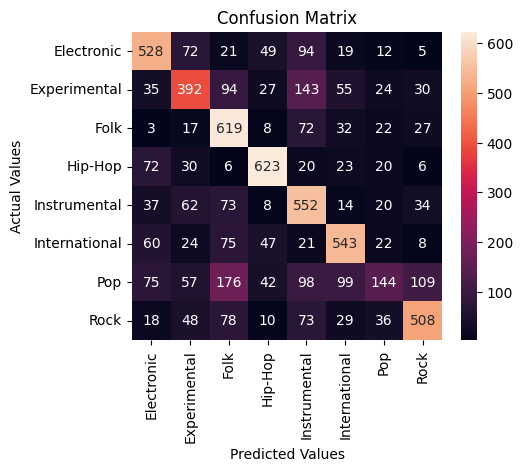

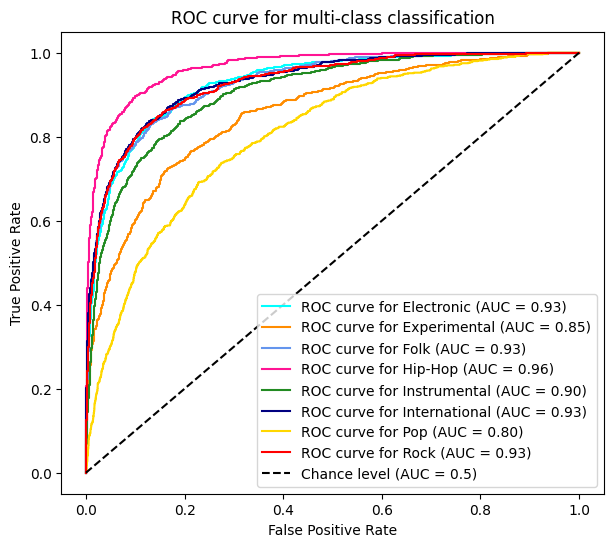

In [275]:
evaluate_network(train_dataloader, model, 'Training Dataset', config['batch_size'], major_vote_tr, true_tr, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:29<00:00,  7.12it/s]




								 ------- Validation Dataset ------- 
								   ------- Accuracy: 0.595 ------- 


               precision    recall  f1-score   support

   Electronic       0.47      0.52      0.50       100
 Experimental       0.50      0.60      0.55       100
         Folk       0.58      0.89      0.70       100
      Hip-Hop       0.72      0.76      0.74       100
 Instrumental       0.53      0.69      0.60       100
International       0.75      0.59      0.66       100
          Pop       0.26      0.05      0.08       100
         Rock       0.78      0.66      0.71       100

     accuracy                           0.59       800
    macro avg       0.57      0.59      0.57       800
 weighted avg       0.57      0.59      0.57       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            52.000000     60.000000   89.000000   76.000000     69.000000   
TN           642.000000    640.000000  636.000000  671.000000    640.000000   
FP            58.000000     60.000000   64.000000   29.000000     60.000000   
FN            48.000000     40.000000   11.000000   24.000000     31.000000   
TPR            0.520000      0.600000    0.890000    0.760000      0.690000   
Recall         0.520000      0.600000    0.890000    0.760000      0.690000   
Sensitivity    0.520000      0.600000    0.890000    0.760000      0.690000   
TNR            0.917143      0.914286    0.908571    0.958571      0.914286   
Specificity    0.917143      0.914286    0.908571    0.958571      0.914286   
FPR            0.082857      0.085714    0.091429    0.041429      0.085714   
FNR            0.480000      0.400000    0.110000    0.240000      0.310000   
PPV            0.472727      0.500000    0.581699    0.723810      0.534884   
Precision      0.472727      0.500000    0.581699    0.723810      0.534884   
F1 Score       0.495238      0.545455    0.703557    0.741463      0.602620   

             International         Pop        Rock  
TP               59.000000    5.000000   66.000000  
TN              680.000000  686.000000  681.000000  
FP               20.000000   14.000000   19.000000  
FN               41.000000   95.000000   34.000000  
TPR               0.590000    0.050000    0.660000  
Recall            0.590000    0.050000    0.660000  
Sensitivity       0.590000    0.050000    0.660000  
TNR               0.971429    0.980000    0.972857  
Specificity       0.971429    0.980000    0.972857  
FPR               0.028571    0.020000    0.027143  
FNR               0.410000    0.950000    0.340000  
PPV               0.746835    0.263158    0.776471  
Precision         0.746835    0.263158    0.776471  
F1 Score          0.659218    0.084034    0.713514

micro     macro  weighted
Precision  0.595  0.574948  0.574948
Recall     0.595  0.595000  0.595000
F1 Score   0.595  0.568137  0.568137

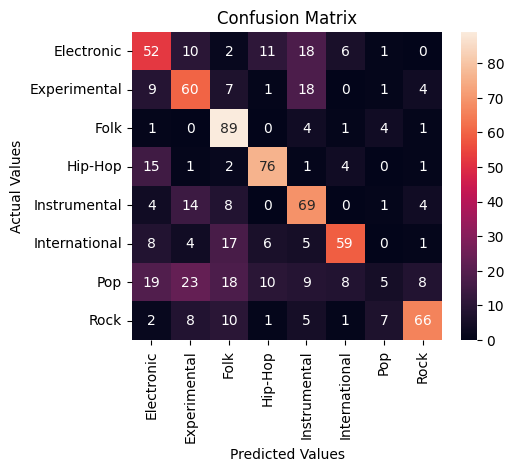

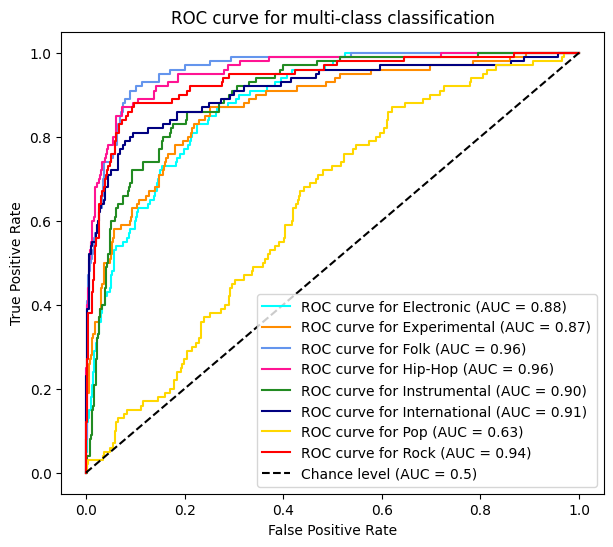

In [276]:
evaluate_network(val_dataloader, model, 'Validation Dataset', config['batch_size'], major_vote_val, true_val, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:29<00:00,  7.15it/s]




								 ------- Test Dataset ------- 
								   ------- Accuracy: 0.4675 ------- 


               precision    recall  f1-score   support

   Electronic       0.63      0.60      0.62       100
 Experimental       0.34      0.34      0.34       100
         Folk       0.24      0.37      0.29       100
      Hip-Hop       0.71      0.82      0.76       100
 Instrumental       0.30      0.37      0.33       100
International       0.52      0.59      0.55       100
          Pop       0.51      0.20      0.29       100
         Rock       0.75      0.45      0.56       100

     accuracy                           0.47       800
    macro avg       0.50      0.47      0.47       800
 weighted avg       0.50      0.47      0.47       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            60.000000     34.000000   37.000000   82.000000     37.000000   
TN           665.000000    635.000000  581.000000  667.000000    614.000000   
FP            35.000000     65.000000  119.000000   33.000000     86.000000   
FN            40.000000     66.000000   63.000000   18.000000     63.000000   
TPR            0.600000      0.340000    0.370000    0.820000      0.370000   
Recall         0.600000      0.340000    0.370000    0.820000      0.370000   
Sensitivity    0.600000      0.340000    0.370000    0.820000      0.370000   
TNR            0.950000      0.907143    0.830000    0.952857      0.877143   
Specificity    0.950000      0.907143    0.830000    0.952857      0.877143   
FPR            0.050000      0.092857    0.170000    0.047143      0.122857   
FNR            0.400000      0.660000    0.630000    0.180000      0.630000   
PPV            0.631579      0.343434    0.237179    0.713043      0.300813   
Precision      0.631579      0.343434    0.237179    0.713043      0.300813   
F1 Score       0.615385      0.341709    0.289062    0.762791      0.331839   

             International         Pop        Rock  
TP               59.000000   20.000000   45.000000  
TN              646.000000  681.000000  685.000000  
FP               54.000000   19.000000   15.000000  
FN               41.000000   80.000000   55.000000  
TPR               0.590000    0.200000    0.450000  
Recall            0.590000    0.200000    0.450000  
Sensitivity       0.590000    0.200000    0.450000  
TNR               0.922857    0.972857    0.978571  
Specificity       0.922857    0.972857    0.978571  
FPR               0.077143    0.027143    0.021429  
FNR               0.410000    0.800000    0.550000  
PPV               0.522124    0.512821    0.750000  
Precision         0.522124    0.512821    0.750000  
F1 Score          0.553991    0.287770    0.562500

micro     macro  weighted
Precision  0.4675  0.501374  0.501374
Recall     0.4675  0.467500  0.467500
F1 Score   0.4675  0.468131  0.468131

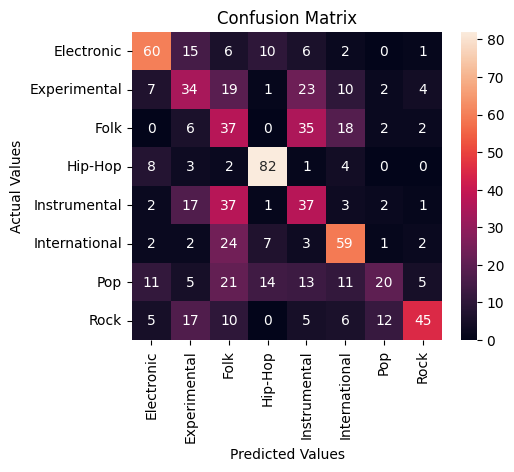

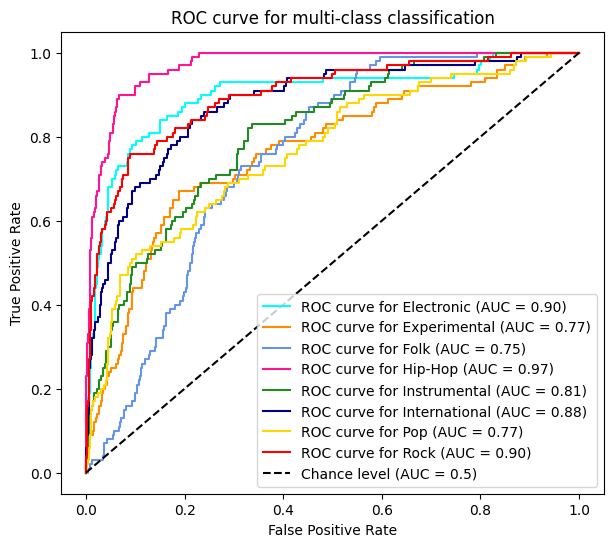

In [277]:
evaluate_network(test_dataloader, model, 'Test Dataset', config['batch_size'], major_vote_test, true_test, genres, figsize1=(5,4), figsize2=(7,6))

# Temporal ResNet2D - Image

In [278]:
class Temporal_ResNet2d_Img(Module):
    def __init__(self, drop=0.2, bias=False):
        super().__init__()
        self.network = Sequential(
            Conv2d(4, 64, kernel_size=7, stride=2, bias=bias),
            BatchNorm2d(64),
            MixedPooling2d(kernel_size=3, stride=2),

            Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**0, bias=bias),
            Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**1, bias=bias),
            Temporal_ConvolutionalBlock2d(in_freq_shape=30, in_channels=64, filters=[64,128], kernel_size=(3,3), stride=1, dilation=2**2, bias=bias),
            MixedPooling2d(kernel_size=3, stride=2),
            Dropout(drop),

            Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**3, bias=bias),
            Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**4, bias=bias),
            Temporal_ConvolutionalBlock2d(in_freq_shape=12, in_channels=128, filters=[128,256], kernel_size=(3,3), stride=1, dilation=2**5, bias=bias),
            MixedPooling2d(kernel_size=3, stride=2),
            Dropout(drop),
        )
        self.classification_layer = Sequential(
            Linear(6912, 8, bias=bias),
        )
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x)
        y = y.reshape((y.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

## Training

In [279]:
run = wandb.init(project="NN&DL_project", entity="festaorlando", group="Temporal_ResNet2d_Img")

config = dict(
    epochs=20,
    batch_size=50,
    learning_rate=0.004,
    weight_decay=1e-3,
    architecture="Temporal_ResNet2d_Img")
wandb.config = config

In [280]:
# Wave data loader
train_dataloader = DataLoader(train_spect_img, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_spect_img, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_spect_img, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate the model, define the loss function and optimizer
model = Temporal_ResNet2d_Img()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# true label tensors
true_tr = torch.tensor(labels_onehot_train.values)
true_val = torch.tensor(labels_onehot_val.values)
true_test = torch.tensor(labels_onehot_test.values)

cuda


In [100]:
# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


best_val = 0
wandb.watch(model, log="all")   
for epoch in range(config['epochs']):
    print(f"\n\nEpoch: {epoch+1}")
    major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
    major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

    # Training
    model.train()
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_id in iterator:
        batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)
        wandb.log({'Running training loss':loss})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
        for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
    tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
    print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')
    wandb.log({'Training accuracy':tr_acc, 'Training error':1-tr_acc, 'Epoch':epoch+1})


    # Validation
    model.eval()
    with torch.no_grad():
        iterator = tqdm(val_dataloader)
        for batch_x, batch_y, batch_id in iterator:
            batch_x, batch_y, batch_id = batch_x.float().to(device), batch_y.float().to(device), batch_id.to(device)

            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
            for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
    val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
    wandb.log({'Validation accuracy':val_acc, 'Validation error':1-val_acc, 'Epoch':epoch+1})
    print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

    if val_acc > best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "Temporal_ResNet2d_Img.pt")
        best_val = val_acc

artifact = wandb.Artifact('Temporal_ResNet2d_Img', type='model')
artifact.add_file('Temporal_ResNet2d_Img.pt')
run.log_artifact(artifact)
run.finish()



Epoch: 1


Running training loss: 1.7981830835342407: 100%|██████████| 1664/1664 [04:43<00:00,  5.86it/s]


Training accuracy:0.4270312488079071   Training error:0.5729687213897705


Running validation loss: 1.2316597700119019: 100%|██████████| 208/208 [00:34<00:00,  6.11it/s]


Validation accuracy:0.3812499940395355   Validation error:0.6187499761581421
Saved Model


Epoch: 2


Running training loss: 1.5197865962982178: 100%|██████████| 1664/1664 [04:53<00:00,  5.66it/s]


Training accuracy:0.48531249165534973   Training error:0.5146875381469727


Running validation loss: 1.7449102401733398: 100%|██████████| 208/208 [00:34<00:00,  6.05it/s]


Validation accuracy:0.21875   Validation error:0.78125


Epoch: 3


Running training loss: 1.5927459001541138: 100%|██████████| 1664/1664 [04:48<00:00,  5.77it/s]


Training accuracy:0.510937511920929   Training error:0.48906248807907104


Running validation loss: 0.9425106644630432: 100%|██████████| 208/208 [00:32<00:00,  6.32it/s]


Validation accuracy:0.4737499952316284   Validation error:0.5262500047683716
Saved Model


Epoch: 4


Running training loss: 1.3226450681686401: 100%|██████████| 1664/1664 [05:00<00:00,  5.53it/s]


Training accuracy:0.5237500071525574   Training error:0.4762499928474426


Running validation loss: 1.7778494358062744: 100%|██████████| 208/208 [00:33<00:00,  6.27it/s]


Validation accuracy:0.35874998569488525   Validation error:0.6412500143051147


Epoch: 5


Running training loss: 1.6527345180511475: 100%|██████████| 1664/1664 [04:45<00:00,  5.83it/s]


Training accuracy:0.530468761920929   Training error:0.46953123807907104


Running validation loss: 2.979185104370117: 100%|██████████| 208/208 [00:34<00:00,  6.09it/s]


Validation accuracy:0.26625001430511475   Validation error:0.7337499856948853


Epoch: 6


Running training loss: 1.297015905380249: 100%|██████████| 1664/1664 [04:48<00:00,  5.78it/s]


Training accuracy:0.5310937762260437   Training error:0.4689062237739563


Running validation loss: 1.932283639907837: 100%|██████████| 208/208 [00:34<00:00,  6.04it/s]


Validation accuracy:0.24500000476837158   Validation error:0.7549999952316284


Epoch: 7


Running training loss: 1.8413305282592773: 100%|██████████| 1664/1664 [04:48<00:00,  5.77it/s]


Training accuracy:0.5337499976158142   Training error:0.4662500023841858


Running validation loss: 0.7724793553352356: 100%|██████████| 208/208 [00:33<00:00,  6.12it/s]


Validation accuracy:0.3712500035762787   Validation error:0.6287499666213989


Epoch: 8


Running training loss: 1.4432412385940552: 100%|██████████| 1664/1664 [04:49<00:00,  5.75it/s]


Training accuracy:0.5356249809265137   Training error:0.46437501907348633


Running validation loss: 1.5336854457855225: 100%|██████████| 208/208 [00:34<00:00,  6.10it/s]


Validation accuracy:0.3512499928474426   Validation error:0.6487500071525574


Epoch: 9


Running training loss: 1.4006267786026: 100%|██████████| 1664/1664 [04:45<00:00,  5.82it/s]


Training accuracy:0.5410937666893005   Training error:0.45890623331069946


Running validation loss: 1.5819768905639648: 100%|██████████| 208/208 [00:33<00:00,  6.17it/s]


Validation accuracy:0.39250001311302185   Validation error:0.6074999570846558


Epoch: 10


Running training loss: 1.5739762783050537: 100%|██████████| 1664/1664 [04:46<00:00,  5.80it/s]


Training accuracy:0.5485937595367432   Training error:0.45140624046325684


Running validation loss: 0.9004961848258972: 100%|██████████| 208/208 [00:33<00:00,  6.18it/s]


Validation accuracy:0.4762499928474426   Validation error:0.5237500071525574
Saved Model


Epoch: 11


Running training loss: 1.6162759065628052: 100%|██████████| 1664/1664 [04:47<00:00,  5.80it/s]


Training accuracy:0.5395312309265137   Training error:0.46046876907348633


Running validation loss: 1.4470309019088745: 100%|██████████| 208/208 [00:34<00:00,  6.09it/s]


Validation accuracy:0.32499998807907104   Validation error:0.675000011920929


Epoch: 12


Running training loss: 1.5840004682540894: 100%|██████████| 1664/1664 [04:57<00:00,  5.59it/s]


Training accuracy:0.5432812571525574   Training error:0.4567187428474426


Running validation loss: 2.0466537475585938: 100%|██████████| 208/208 [00:34<00:00,  6.06it/s]


Validation accuracy:0.29750001430511475   Validation error:0.7024999856948853


Epoch: 13


Running training loss: 1.5596184730529785: 100%|██████████| 1664/1664 [04:48<00:00,  5.77it/s]


Training accuracy:0.5443750023841858   Training error:0.4556249976158142


Running validation loss: 3.178154945373535: 100%|██████████| 208/208 [00:34<00:00,  6.06it/s]


Validation accuracy:0.20374999940395355   Validation error:0.7962499856948853


Epoch: 14


Running training loss: 1.4922847747802734: 100%|██████████| 1664/1664 [04:49<00:00,  5.74it/s]


Training accuracy:0.5431249737739563   Training error:0.4568750262260437


Running validation loss: 2.18393874168396: 100%|██████████| 208/208 [00:33<00:00,  6.27it/s]


Validation accuracy:0.26875001192092896   Validation error:0.731249988079071


Epoch: 15


Running training loss: 1.4000012874603271: 100%|██████████| 1664/1664 [04:45<00:00,  5.82it/s]


Training accuracy:0.5434374809265137   Training error:0.45656251907348633


Running validation loss: 2.9456212520599365: 100%|██████████| 208/208 [00:33<00:00,  6.18it/s]


Validation accuracy:0.2150000035762787   Validation error:0.7849999666213989


Epoch: 16


Running training loss: 1.664918303489685: 100%|██████████| 1664/1664 [04:45<00:00,  5.83it/s]


Training accuracy:0.5459374785423279   Training error:0.4540625214576721


Running validation loss: 1.124451756477356: 100%|██████████| 208/208 [00:33<00:00,  6.17it/s]


Validation accuracy:0.44999998807907104   Validation error:0.550000011920929


Epoch: 17


Running training loss: 1.583715796470642: 100%|██████████| 1664/1664 [04:49<00:00,  5.75it/s]


Training accuracy:0.5448437333106995   Training error:0.45515626668930054


Running validation loss: 1.5451834201812744: 100%|██████████| 208/208 [00:34<00:00,  6.07it/s]


Validation accuracy:0.3824999928474426   Validation error:0.6175000071525574


Epoch: 18


Running training loss: 1.389886736869812: 100%|██████████| 1664/1664 [04:45<00:00,  5.82it/s]


Training accuracy:0.5418750047683716   Training error:0.4581249952316284


Running validation loss: 2.3025567531585693: 100%|██████████| 208/208 [00:33<00:00,  6.24it/s]


Validation accuracy:0.2199999988079071   Validation error:0.7799999713897705


Epoch: 19


Running training loss: 1.5505547523498535: 100%|██████████| 1664/1664 [04:41<00:00,  5.92it/s]


Training accuracy:0.5484374761581421   Training error:0.4515625238418579


Running validation loss: 1.185964584350586: 100%|██████████| 208/208 [00:32<00:00,  6.36it/s]


Validation accuracy:0.2787500023841858   Validation error:0.7212499976158142


Epoch: 20


Running training loss: 1.5162965059280396: 100%|██████████| 1664/1664 [04:42<00:00,  5.89it/s]


Training accuracy:0.5443750023841858   Training error:0.4556249976158142


Running validation loss: 1.400470495223999: 100%|██████████| 208/208 [00:33<00:00,  6.26it/s]


Validation accuracy:0.4412499964237213   Validation error:0.5587500333786011


## Evaluate & Testing

In [281]:
model = Temporal_ResNet2d_Img()
model.to(device)
model.load_state_dict(torch.load("Temporal_ResNet2d_Img.pt"))

major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))
major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))
major_vote_test = dict(zip(labels_onehot_test.reset_index().track_id, torch.zeros(labels_onehot_test.shape[0], len(genres))))

100%|██████████| 1664/1664 [04:47<00:00,  5.79it/s]




								 ------- Training Dataset ------- 
								   ------- Accuracy: 0.481875 ------- 


               precision    recall  f1-score   support

   Electronic       0.57      0.33      0.42       800
 Experimental       0.31      0.51      0.38       800
         Folk       0.64      0.60      0.62       800
      Hip-Hop       0.76      0.52      0.62       800
 Instrumental       0.55      0.56      0.55       800
International       0.62      0.50      0.55       800
          Pop       0.30      0.07      0.12       800
         Rock       0.37      0.76      0.50       800

     accuracy                           0.48      6400
    macro avg       0.51      0.48      0.47      6400
 weighted avg       0.51      0.48      0.47      6400



Electronic  Experimental         Folk      Hip-Hop  \
TP            263.000000    409.000000   477.000000   418.000000   
TN           5404.000000   4674.000000  5327.000000  5466.000000   
FP            196.000000    926.000000   273.000000   134.000000   
FN            537.000000    391.000000   323.000000   382.000000   
TPR             0.328750      0.511250     0.596250     0.522500   
Recall          0.328750      0.511250     0.596250     0.522500   
Sensitivity     0.328750      0.511250     0.596250     0.522500   
TNR             0.965000      0.834643     0.951250     0.976071   
Specificity     0.965000      0.834643     0.951250     0.976071   
FPR             0.035000      0.165357     0.048750     0.023929   
FNR             0.671250      0.488750     0.403750     0.477500   
PPV             0.572985      0.306367     0.636000     0.757246   
Precision       0.572985      0.306367     0.636000     0.757246   
F1 Score        0.417792      0.383138     0.615484     0.618343   

             Instrumental  International          Pop         Rock  
TP             447.000000     400.000000    60.000000   610.000000  
TN            5230.000000    5351.000000  5462.000000  4570.000000  
FP             370.000000     249.000000   138.000000  1030.000000  
FN             353.000000     400.000000   740.000000   190.000000  
TPR              0.558750       0.500000     0.075000     0.762500  
Recall           0.558750       0.500000     0.075000     0.762500  
Sensitivity      0.558750       0.500000     0.075000     0.762500  
TNR              0.933929       0.955536     0.975357     0.816071  
Specificity      0.933929       0.955536     0.975357     0.816071  
FPR              0.066071       0.044464     0.024643     0.183929  
FNR              0.441250       0.500000     0.925000     0.237500  
PPV              0.547124       0.616333     0.303030     0.371951  
Precision        0.547124       0.616333     0.303030     0.371951  
F1 Score         0.552876       0.552105     0.120240     0.500000

micro     macro  weighted
Precision  0.481875  0.513880  0.513880
Recall     0.481875  0.481875  0.481875
F1 Score   0.481875  0.469997  0.469997

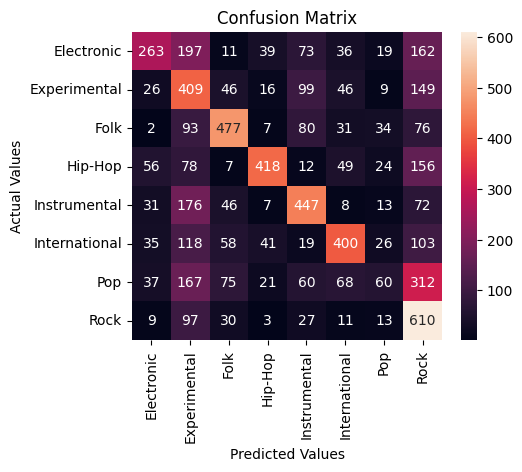

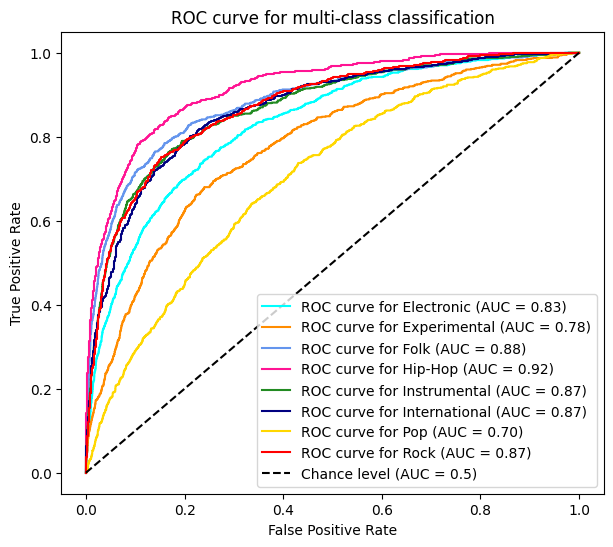

In [282]:
evaluate_network(train_dataloader, model, 'Training Dataset', config['batch_size'], major_vote_tr, true_tr, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:34<00:00,  5.96it/s]




								 ------- Validation Dataset ------- 
								   ------- Accuracy: 0.47625 ------- 


               precision    recall  f1-score   support

   Electronic       0.56      0.49      0.52       100
 Experimental       0.35      0.54      0.42       100
         Folk       0.66      0.79      0.72       100
      Hip-Hop       0.70      0.28      0.40       100
 Instrumental       0.43      0.45      0.44       100
International       0.62      0.45      0.52       100
          Pop       0.13      0.05      0.07       100
         Rock       0.42      0.76      0.54       100

     accuracy                           0.48       800
    macro avg       0.48      0.48      0.45       800
 weighted avg       0.48      0.48      0.45       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            49.000000     54.000000   79.000000   28.000000     45.000000   
TN           662.000000    599.000000  660.000000  688.000000    640.000000   
FP            38.000000    101.000000   40.000000   12.000000     60.000000   
FN            51.000000     46.000000   21.000000   72.000000     55.000000   
TPR            0.490000      0.540000    0.790000    0.280000      0.450000   
Recall         0.490000      0.540000    0.790000    0.280000      0.450000   
Sensitivity    0.490000      0.540000    0.790000    0.280000      0.450000   
TNR            0.945714      0.855714    0.942857    0.982857      0.914286   
Specificity    0.945714      0.855714    0.942857    0.982857      0.914286   
FPR            0.054286      0.144286    0.057143    0.017143      0.085714   
FNR            0.510000      0.460000    0.210000    0.720000      0.550000   
PPV            0.563218      0.348387    0.663866    0.700000      0.428571   
Precision      0.563218      0.348387    0.663866    0.700000      0.428571   
F1 Score       0.524064      0.423529    0.721461    0.400000      0.439024   

             International         Pop        Rock  
TP               45.000000    5.000000   76.000000  
TN              672.000000  667.000000  593.000000  
FP               28.000000   33.000000  107.000000  
FN               55.000000   95.000000   24.000000  
TPR               0.450000    0.050000    0.760000  
Recall            0.450000    0.050000    0.760000  
Sensitivity       0.450000    0.050000    0.760000  
TNR               0.960000    0.952857    0.847143  
Specificity       0.960000    0.952857    0.847143  
FPR               0.040000    0.047143    0.152857  
FNR               0.550000    0.950000    0.240000  
PPV               0.616438    0.131579    0.415301  
Precision         0.616438    0.131579    0.415301  
F1 Score          0.520231    0.072464    0.537102

micro     macro  weighted
Precision  0.47625  0.483420  0.483420
Recall     0.47625  0.476250  0.476250
F1 Score   0.47625  0.454735  0.454735

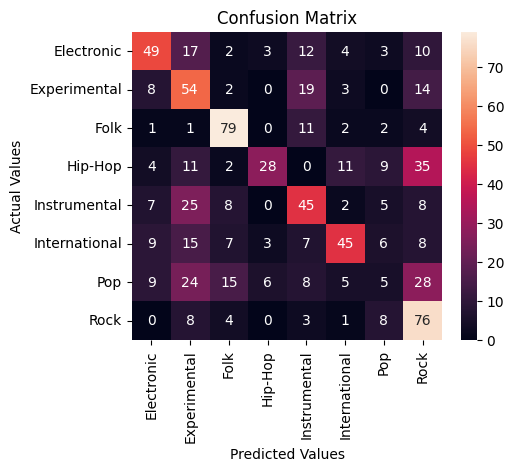

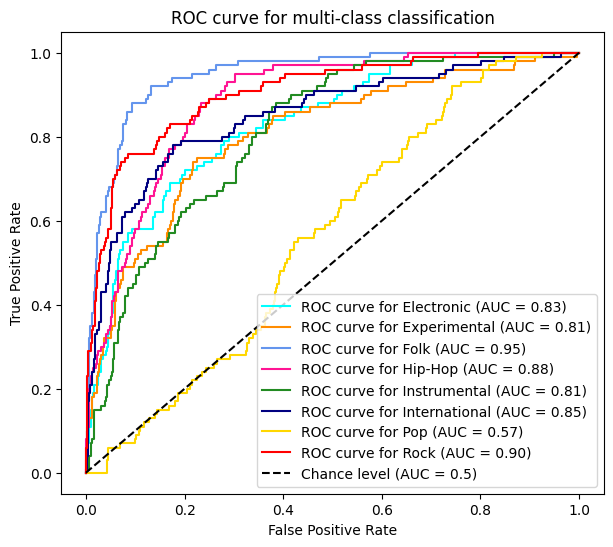

In [283]:
evaluate_network(val_dataloader, model, 'Validation Dataset', config['batch_size'], major_vote_val, true_val, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:34<00:00,  5.96it/s]



								 ------- Test Dataset ------- 
								   ------- Accuracy: 0.3625 ------- 


               precision    recall  f1-score   support

   Electronic       0.56      0.45      0.50       100
 Experimental       0.20      0.34      0.25       100
         Folk       0.18      0.22      0.20       100
      Hip-Hop       0.82      0.54      0.65       100
 Instrumental       0.40      0.37      0.39       100
International       0.38      0.24      0.29       100
          Pop       0.40      0.16      0.23       100
         Rock       0.36      0.58      0.44       100

     accuracy                           0.36       800
    macro avg       0.41      0.36      0.37       800
 weighted avg       0.41      0.36      0.37       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP              45.0000     34.000000   22.000000   54.000000     37.000000   
TN             665.0000    561.000000  597.000000  688.000000    645.000000   
FP              35.0000    139.000000  103.000000   12.000000     55.000000   
FN              55.0000     66.000000   78.000000   46.000000     63.000000   
TPR              0.4500      0.340000    0.220000    0.540000      0.370000   
Recall           0.4500      0.340000    0.220000    0.540000      0.370000   
Sensitivity      0.4500      0.340000    0.220000    0.540000      0.370000   
TNR              0.9500      0.801429    0.852857    0.982857      0.921429   
Specificity      0.9500      0.801429    0.852857    0.982857      0.921429   
FPR              0.0500      0.198571    0.147143    0.017143      0.078571   
FNR              0.5500      0.660000    0.780000    0.460000      0.630000   
PPV              0.5625      0.196532    0.176000    0.818182      0.402174   
Precision        0.5625      0.196532    0.176000    0.818182      0.402174   
F1 Score         0.5000      0.249084    0.195556    0.650602      0.385417   

             International         Pop        Rock  
TP               24.000000   16.000000   58.000000  
TN              661.000000  676.000000  597.000000  
FP               39.000000   24.000000  103.000000  
FN               76.000000   84.000000   42.000000  
TPR               0.240000    0.160000    0.580000  
Recall            0.240000    0.160000    0.580000  
Sensitivity       0.240000    0.160000    0.580000  
TNR               0.944286    0.965714    0.852857  
Specificity       0.944286    0.965714    0.852857  
FPR               0.055714    0.034286    0.147143  
FNR               0.760000    0.840000    0.420000  
PPV               0.380952    0.400000    0.360248  
Precision         0.380952    0.400000    0.360248  
F1 Score          0.294479    0.228571    0.444444

micro     macro  weighted
Precision  0.3625  0.412074  0.412074
Recall     0.3625  0.362500  0.362500
F1 Score   0.3625  0.368519  0.368519

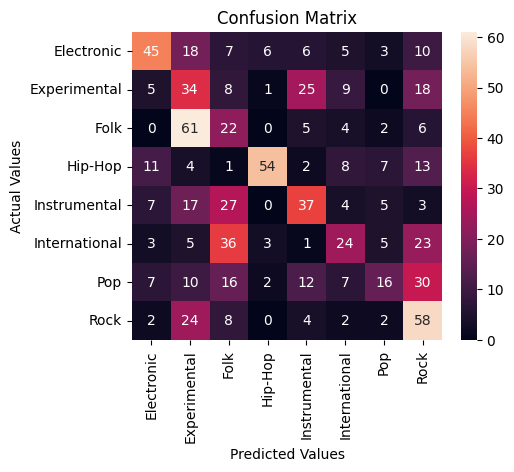

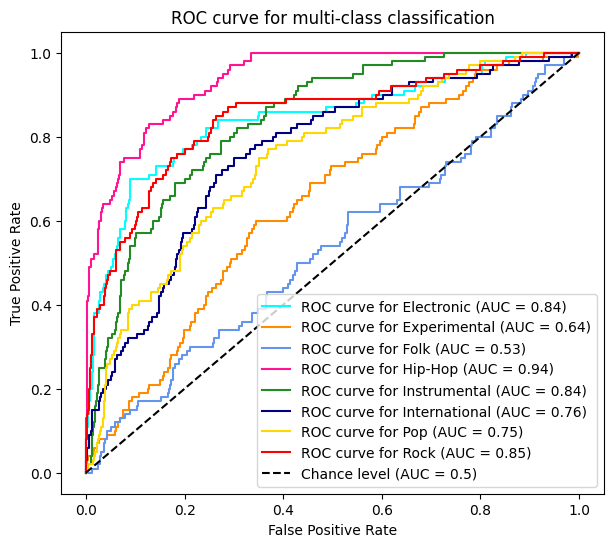

In [284]:
evaluate_network(test_dataloader, model, 'Test Dataset', config['batch_size'], major_vote_test, true_test, genres, figsize1=(5,4), figsize2=(7,6))

# Bottleneck

In [285]:
class Temporal_Bottleneck2d(Module):
    def __init__(self, drop=0.2, bias=False):
        super().__init__()
        self.network = Sequential(
            Conv2d(1, 64, kernel_size=7, stride=2, bias=bias),
            BatchNorm2d(64),
            MixedPooling2d(kernel_size=3, stride=2),

            Temporal_BottleneckIdentityBlock2d(in_channels=64, filters=[16,64], kernel_size=(3,3), stride=1, dilation=2**0, bias=bias),
            Temporal_BottleneckIdentityBlock2d(in_channels=64, filters=[16,64], kernel_size=(3,3), stride=1, dilation=2**1, bias=bias),
            Temporal_BottleneckConvolutionalBlock2d(in_freq_shape=30, in_channels=64, filters=[16,128], kernel_size=(3,3), stride=1, dilation=2**2, bias=bias),
            MixedPooling2d(kernel_size=3, stride=2),
            Dropout(drop),

            Temporal_BottleneckIdentityBlock2d(in_channels=128, filters=[32,128], kernel_size=(3,3), stride=1, dilation=2**3, bias=bias),
            Temporal_BottleneckIdentityBlock2d(in_channels=128, filters=[32,128], kernel_size=(3,3), stride=1, dilation=2**4, bias=bias),
            Temporal_BottleneckConvolutionalBlock2d(in_freq_shape=13, in_channels=128, filters=[32,256], kernel_size=(3,3), stride=1, dilation=2**5, bias=bias),
            MixedPooling2d(kernel_size=3, stride=2),
            Dropout(drop),

            Temporal_BottleneckIdentityBlock2d(in_channels=256, filters=[64,256], kernel_size=(3,3), stride=1, dilation=2**6, bias=bias),
            Temporal_BottleneckIdentityBlock2d(in_channels=256, filters=[64,256], kernel_size=(3,3), stride=1, dilation=2**7, bias=bias),
            Temporal_BottleneckConvolutionalBlock2d(in_freq_shape=5, in_channels=256, filters=[64,512], kernel_size=(3,3), stride=1, dilation=2**8, bias=bias),
            MixedPooling2d(kernel_size=3, stride=2),
            Dropout(drop),
        )
        self.classification_layer = Sequential(
            Linear(2048, 8, bias=bias),
        )
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x)
        y = y.reshape((y.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is True:
                module.bias.data.zero_()

## Hyperparameters optimization

In [216]:
config = dict(
    epochs=8,
    batch_size=50,
    architecture="Temporal_Bottleneck2d")

In [217]:
# Spectrogram data loader
train_dataloader = DataLoader(train_spect, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_fn = nn.CrossEntropyLoss()

# true label tensors
true_tr = torch.tensor(labels_onehot_train.values)
true_val = torch.tensor(labels_onehot_val.values)
true_test = torch.tensor(labels_onehot_test.values)

cuda


In [218]:
def objective(trial):
    model = Temporal_Bottleneck2d().to(device)
    lr = trial.suggest_float("lr", 1e-4, 5e-3)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(config['epochs']):
        print(f"\nEpoch: {epoch+1}")
        major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
        major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

        # Training
        model.train()
        iterator = tqdm(train_dataloader)
        for batch_x, batch_y, batch_id in iterator:
            batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
            for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
        pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
        tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
        print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')


        # Validation
        model.eval()
        with torch.no_grad():
            iterator = tqdm(val_dataloader)
            for batch_x, batch_y, batch_id in iterator:
                batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

                y_pred = model(batch_x)
                loss = loss_fn(y_pred, batch_y)

                iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
                for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
        pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
        val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
        print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

        # Handle pruning based on the intermediate value
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return val_acc

In [219]:
# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

study = optuna.create_study(sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(), direction='maximize')
study.sampler.__class__.__name__, study.pruner.__class__.__name__

[I 2023-09-12 17:09:02,509] A new study created in memory with name: no-name-1e9c0c15-802e-4a60-8722-a7065dfcda20


('TPESampler', 'HyperbandPruner')

In [220]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

study.optimize(objective, n_trials=5)


Epoch: 1


Running training loss: 1.5673716068267822: 100%|██████████| 1664/1664 [04:04<00:00,  6.82it/s]


Training accuracy:0.5510937571525574   Training error:0.4489062428474426


Running validation loss: 1.1316814422607422: 100%|██████████| 208/208 [00:29<00:00,  6.96it/s]


Validation accuracy:0.48750001192092896   Validation error:0.512499988079071

Epoch: 2


Running training loss: 1.538568377494812: 100%|██████████| 1664/1664 [04:04<00:00,  6.80it/s]


Training accuracy:0.5973437428474426   Training error:0.4026562571525574


Running validation loss: 1.8417773246765137: 100%|██████████| 208/208 [00:30<00:00,  6.81it/s]


Validation accuracy:0.47999998927116394   Validation error:0.5199999809265137

Epoch: 3


Running training loss: 1.2933684587478638: 100%|██████████| 1664/1664 [04:03<00:00,  6.83it/s]


Training accuracy:0.612500011920929   Training error:0.38749998807907104


Running validation loss: 1.4030990600585938: 100%|██████████| 208/208 [00:30<00:00,  6.93it/s]


Validation accuracy:0.5112500190734863   Validation error:0.48874998092651367

Epoch: 4


Running training loss: 1.3067899942398071: 100%|██████████| 1664/1664 [04:02<00:00,  6.86it/s]


Training accuracy:0.6214062571525574   Training error:0.3785937428474426


Running validation loss: 2.0578277111053467: 100%|██████████| 208/208 [00:30<00:00,  6.86it/s]


Validation accuracy:0.46000000834465027   Validation error:0.5399999618530273

Epoch: 5


Running training loss: 1.4367589950561523: 100%|██████████| 1664/1664 [04:04<00:00,  6.80it/s]


Training accuracy:0.6270312666893005   Training error:0.37296873331069946


Running validation loss: 1.1172024011611938: 100%|██████████| 208/208 [00:30<00:00,  6.86it/s]


Validation accuracy:0.5262500047683716   Validation error:0.4737499952316284

Epoch: 6


Running training loss: 1.5704354047775269: 100%|██████████| 1664/1664 [04:03<00:00,  6.84it/s]


Training accuracy:0.6387500166893005   Training error:0.36124998331069946


Running validation loss: 1.2196999788284302: 100%|██████████| 208/208 [00:29<00:00,  6.97it/s]


Validation accuracy:0.5062500238418579   Validation error:0.4937499761581421

Epoch: 7


Running training loss: 1.3012621402740479: 100%|██████████| 1664/1664 [04:04<00:00,  6.81it/s]


Training accuracy:0.6393749713897705   Training error:0.3606250286102295


Running validation loss: 1.4177627563476562: 100%|██████████| 208/208 [00:29<00:00,  6.97it/s]


Validation accuracy:0.5649999976158142   Validation error:0.4350000023841858

Epoch: 8


Running training loss: 1.4013919830322266: 100%|██████████| 1664/1664 [04:01<00:00,  6.90it/s]


Training accuracy:0.6373437643051147   Training error:0.36265623569488525


Running validation loss: 2.1422455310821533: 100%|██████████| 208/208 [00:29<00:00,  7.02it/s]
[I 2023-09-12 17:45:59,995] Trial 0 finished with value: 0.4950000047683716 and parameters: {'lr': 0.00320908952929977, 'weight_decay': 0.000921784435602697}. Best is trial 0 with value: 0.4950000047683716.


Validation accuracy:0.4950000047683716   Validation error:0.5049999952316284
Trial 0 finished with value: 0.4950000047683716 and parameters: {'lr': 0.00320908952929977, 'weight_decay': 0.000921784435602697}. Best is trial 0 with value: 0.4950000047683716.

Epoch: 1


Running training loss: 1.6200404167175293: 100%|██████████| 1664/1664 [04:03<00:00,  6.84it/s]


Training accuracy:0.5426562428474426   Training error:0.4573437571525574


Running validation loss: 1.4322013854980469: 100%|██████████| 208/208 [00:30<00:00,  6.85it/s]


Validation accuracy:0.45625001192092896   Validation error:0.543749988079071

Epoch: 2


Running training loss: 1.2780369520187378: 100%|██████████| 1664/1664 [04:01<00:00,  6.88it/s]


Training accuracy:0.6107812523841858   Training error:0.3892187476158142


Running validation loss: 0.793027400970459: 100%|██████████| 208/208 [00:29<00:00,  7.00it/s]


Validation accuracy:0.5012500286102295   Validation error:0.4987499713897705

Epoch: 3


Running training loss: 0.9564222693443298: 100%|██████████| 1664/1664 [04:01<00:00,  6.88it/s]


Training accuracy:0.6282812356948853   Training error:0.37171876430511475


Running validation loss: 1.201413869857788: 100%|██████████| 208/208 [00:30<00:00,  6.76it/s]


Validation accuracy:0.4937500059604645   Validation error:0.5062500238418579

Epoch: 4


Running training loss: 1.298561930656433: 100%|██████████| 1664/1664 [04:01<00:00,  6.88it/s]


Training accuracy:0.6442187428474426   Training error:0.3557812571525574


Running validation loss: 1.2805688381195068: 100%|██████████| 208/208 [00:30<00:00,  6.93it/s]


Validation accuracy:0.5587499737739563   Validation error:0.4412500262260437

Epoch: 5


Running training loss: 1.0917357206344604: 100%|██████████| 1664/1664 [04:02<00:00,  6.87it/s]


Training accuracy:0.657031238079071   Training error:0.34296876192092896


Running validation loss: 1.0466612577438354: 100%|██████████| 208/208 [00:30<00:00,  6.86it/s]


Validation accuracy:0.5162500143051147   Validation error:0.48374998569488525

Epoch: 6


Running training loss: 1.3740038871765137: 100%|██████████| 1664/1664 [04:02<00:00,  6.85it/s]


Training accuracy:0.660937488079071   Training error:0.33906251192092896


Running validation loss: 1.6265329122543335: 100%|██████████| 208/208 [00:30<00:00,  6.80it/s]


Validation accuracy:0.5612499713897705   Validation error:0.4387500286102295

Epoch: 7


Running training loss: 1.0527921915054321: 100%|██████████| 1664/1664 [04:03<00:00,  6.83it/s]


Training accuracy:0.6698437333106995   Training error:0.33015626668930054


Running validation loss: 0.9052898287773132: 100%|██████████| 208/208 [00:29<00:00,  7.01it/s]


Validation accuracy:0.5837500095367432   Validation error:0.41624999046325684

Epoch: 8


Running training loss: 1.2308229207992554: 100%|██████████| 1664/1664 [04:03<00:00,  6.84it/s]


Training accuracy:0.6737499833106995   Training error:0.32625001668930054


Running validation loss: 1.530157446861267: 100%|██████████| 208/208 [00:30<00:00,  6.88it/s]
[I 2023-09-12 18:22:23,593] Trial 1 finished with value: 0.5699999928474426 and parameters: {'lr': 0.0029109082159235423, 'weight_decay': 0.0003319642052517766}. Best is trial 1 with value: 0.5699999928474426.


Validation accuracy:0.5699999928474426   Validation error:0.4300000071525574
Trial 1 finished with value: 0.5699999928474426 and parameters: {'lr': 0.0029109082159235423, 'weight_decay': 0.0003319642052517766}. Best is trial 1 with value: 0.5699999928474426.

Epoch: 1


Running training loss: 1.4533381462097168: 100%|██████████| 1664/1664 [04:05<00:00,  6.78it/s]


Training accuracy:0.5199999809265137   Training error:0.48000001907348633


Running validation loss: 1.9573380947113037: 100%|██████████| 208/208 [00:30<00:00,  6.80it/s]


Validation accuracy:0.49125000834465027   Validation error:0.5087499618530273

Epoch: 2


Running training loss: 1.3296988010406494: 100%|██████████| 1664/1664 [04:02<00:00,  6.86it/s]


Training accuracy:0.6035937666893005   Training error:0.39640623331069946


Running validation loss: 1.3999139070510864: 100%|██████████| 208/208 [00:30<00:00,  6.82it/s]


Validation accuracy:0.5249999761581421   Validation error:0.4750000238418579

Epoch: 3


Running training loss: 1.251713752746582: 100%|██████████| 1664/1664 [04:04<00:00,  6.81it/s]


Training accuracy:0.616406261920929   Training error:0.38359373807907104


Running validation loss: 1.863985538482666: 100%|██████████| 208/208 [00:30<00:00,  6.92it/s]


Validation accuracy:0.4662500023841858   Validation error:0.5337499976158142

Epoch: 4


Running training loss: 1.3598052263259888: 100%|██████████| 1664/1664 [04:03<00:00,  6.83it/s]


Training accuracy:0.624218761920929   Training error:0.37578123807907104


Running validation loss: 1.700471043586731: 100%|██████████| 208/208 [00:30<00:00,  6.79it/s]


Validation accuracy:0.5237500071525574   Validation error:0.4762499928474426

Epoch: 5


Running training loss: 1.593843698501587: 100%|██████████| 1664/1664 [04:05<00:00,  6.79it/s]


Training accuracy:0.6390625238418579   Training error:0.3609374761581421


Running validation loss: 1.4396425485610962: 100%|██████████| 208/208 [00:30<00:00,  6.85it/s]


Validation accuracy:0.5375000238418579   Validation error:0.4624999761581421

Epoch: 6


Running training loss: 1.3684800863265991: 100%|██████████| 1664/1664 [04:04<00:00,  6.81it/s]


Training accuracy:0.6285937428474426   Training error:0.3714062571525574


Running validation loss: 1.3162740468978882: 100%|██████████| 208/208 [00:30<00:00,  6.86it/s]


Validation accuracy:0.5475000143051147   Validation error:0.45249998569488525

Epoch: 7


Running training loss: 1.3430367708206177: 100%|██████████| 1664/1664 [04:05<00:00,  6.79it/s]


Training accuracy:0.6382812261581421   Training error:0.3617187738418579


Running validation loss: 1.3911694288253784: 100%|██████████| 208/208 [00:29<00:00,  7.11it/s]


Validation accuracy:0.5149999856948853   Validation error:0.48500001430511475

Epoch: 8


Running training loss: 1.3205899000167847: 100%|██████████| 1664/1664 [03:57<00:00,  7.00it/s]


Training accuracy:0.6446874737739563   Training error:0.3553125262260437


Running validation loss: 1.112722396850586: 100%|██████████| 208/208 [00:30<00:00,  6.85it/s]
[I 2023-09-12 18:58:55,650] Trial 2 finished with value: 0.518750011920929 and parameters: {'lr': 0.004923667136041602, 'weight_decay': 0.0002126168254919806}. Best is trial 1 with value: 0.5699999928474426.


Validation accuracy:0.518750011920929   Validation error:0.48124998807907104
Trial 2 finished with value: 0.518750011920929 and parameters: {'lr': 0.004923667136041602, 'weight_decay': 0.0002126168254919806}. Best is trial 1 with value: 0.5699999928474426.

Epoch: 1


Running training loss: 1.2947975397109985: 100%|██████████| 1664/1664 [03:58<00:00,  6.97it/s]


Training accuracy:0.5375000238418579   Training error:0.4624999761581421


Running validation loss: 1.2631151676177979: 100%|██████████| 208/208 [00:29<00:00,  7.07it/s]


Validation accuracy:0.4987500011920929   Validation error:0.5012500286102295

Epoch: 2


Running training loss: 1.17490816116333: 100%|██████████| 1664/1664 [03:59<00:00,  6.96it/s]


Training accuracy:0.6100000143051147   Training error:0.38999998569488525


Running validation loss: 1.6035947799682617: 100%|██████████| 208/208 [00:29<00:00,  6.97it/s]
[I 2023-09-12 19:07:53,197] Trial 3 pruned. 


Validation accuracy:0.4975000023841858   Validation error:0.5024999976158142
Trial 3 pruned. 

Epoch: 1


Running training loss: 1.293644666671753: 100%|██████████| 1664/1664 [03:58<00:00,  6.97it/s]


Training accuracy:0.5479687452316284   Training error:0.4520312547683716


Running validation loss: 0.9984011650085449: 100%|██████████| 208/208 [00:29<00:00,  7.11it/s]


Validation accuracy:0.5375000238418579   Validation error:0.4624999761581421

Epoch: 2


Running training loss: 1.312041163444519: 100%|██████████| 1664/1664 [03:58<00:00,  6.97it/s]


Training accuracy:0.6176562309265137   Training error:0.38234376907348633


Running validation loss: 0.687998354434967: 100%|██████████| 208/208 [00:29<00:00,  7.00it/s]


Validation accuracy:0.5699999928474426   Validation error:0.4300000071525574

Epoch: 3


Running training loss: 1.5206012725830078: 100%|██████████| 1664/1664 [04:00<00:00,  6.92it/s]


Training accuracy:0.6446874737739563   Training error:0.3553125262260437


Running validation loss: 1.2787953615188599: 100%|██████████| 208/208 [00:29<00:00,  6.99it/s]


Validation accuracy:0.5674999952316284   Validation error:0.4325000047683716

Epoch: 4


Running training loss: 1.1227049827575684: 100%|██████████| 1664/1664 [03:58<00:00,  6.97it/s]


Training accuracy:0.6598437428474426   Training error:0.3401562571525574


Running validation loss: 1.137820839881897: 100%|██████████| 208/208 [00:29<00:00,  7.09it/s]


Validation accuracy:0.5587499737739563   Validation error:0.4412500262260437

Epoch: 5


Running training loss: 1.4496668577194214: 100%|██████████| 1664/1664 [03:59<00:00,  6.95it/s]


Training accuracy:0.6743749976158142   Training error:0.3256250023841858


Running validation loss: 1.2715619802474976: 100%|██████████| 208/208 [00:30<00:00,  6.93it/s]


Validation accuracy:0.5962499976158142   Validation error:0.4037500023841858

Epoch: 6


Running training loss: 1.2815351486206055: 100%|██████████| 1664/1664 [03:59<00:00,  6.94it/s]


Training accuracy:0.6814062595367432   Training error:0.31859374046325684


Running validation loss: 1.2730251550674438: 100%|██████████| 208/208 [00:29<00:00,  7.02it/s]


Validation accuracy:0.5362499952316284   Validation error:0.4637500047683716

Epoch: 7


Running training loss: 1.1308693885803223: 100%|██████████| 1664/1664 [03:59<00:00,  6.95it/s]


Training accuracy:0.6967187523841858   Training error:0.3032812476158142


Running validation loss: 1.626711130142212: 100%|██████████| 208/208 [00:29<00:00,  6.93it/s]


Validation accuracy:0.5612499713897705   Validation error:0.4387500286102295

Epoch: 8


Running training loss: 1.1380406618118286: 100%|██████████| 1664/1664 [04:00<00:00,  6.91it/s]


Training accuracy:0.703906238079071   Training error:0.29609376192092896


Running validation loss: 1.8049172163009644: 100%|██████████| 208/208 [00:29<00:00,  7.05it/s]
[I 2023-09-12 19:43:47,917] Trial 4 finished with value: 0.5849999785423279 and parameters: {'lr': 0.0026347572971318002, 'weight_decay': 0.00016489731630836934}. Best is trial 4 with value: 0.5849999785423279.


Validation accuracy:0.5849999785423279   Validation error:0.4150000214576721
Trial 4 finished with value: 0.5849999785423279 and parameters: {'lr': 0.0026347572971318002, 'weight_decay': 0.00016489731630836934}. Best is trial 4 with value: 0.5849999785423279.


In [221]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.5849999785423279
Best hyperparameters: {'lr': 0.0026347572971318002, 'weight_decay': 0.00016489731630836934}


In [222]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df

value  params_lr  params_weight_decay  system_attrs_completed_rung_0  \
0  0.49500   0.003209             0.000922                            NaN   
1  0.57000   0.002911             0.000332                        0.50125   
2  0.51875   0.004924             0.000213                        0.52375   
3  0.49750   0.003212             0.000194                        0.49750   
4  0.58500   0.002635             0.000165                        0.57000   

   system_attrs_completed_rung_1  
0                            NaN  
1                        0.55875  
2                            NaN  
3                            NaN  
4                        0.55875

In [223]:
optuna.visualization.plot_optimization_history(study)

In [224]:
optuna.visualization.plot_contour(study, params=['weight_decay', 'lr'])

In [225]:
optuna.visualization.plot_parallel_coordinate(study)

In [226]:
optuna.visualization.plot_param_importances(study)

## Training

In [286]:
run = wandb.init(project="NN&DL_project", entity="festaorlando", group='Temporal_Bottleneck2d')

config = dict(
    epochs=20,
    batch_size=50,
    learning_rate=0.0026,
    weight_decay=0.000165,
    architecture="Temporal_Bottleneck2d")
wandb.config = config

In [287]:
# Spectrogram data loader
train_dataloader = DataLoader(train_spect, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_dataloader = DataLoader(val_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate the model, define the loss function and optimizer
model = Temporal_Bottleneck2d()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# true label tensors
true_tr = torch.tensor(labels_onehot_train.values)
true_val = torch.tensor(labels_onehot_val.values)
true_test = torch.tensor(labels_onehot_test.values)

cuda


In [229]:
# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


best_val = 0
wandb.watch(model, log="all")   
for epoch in range(config['epochs']):
    print(f"\n\nEpoch: {epoch+1}")
    major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
    major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

    # Training
    model.train()
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_id in iterator:
        batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)
        wandb.log({'Running training loss':loss})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
        for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
    tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
    print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')
    wandb.log({'Training accuracy':tr_acc, 'Training error':1-tr_acc, 'Epoch':epoch+1})


    # Validation
    model.eval()
    with torch.no_grad():
        iterator = tqdm(val_dataloader)
        for batch_x, batch_y, batch_id in iterator:
            batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
            for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += F.softmax(y_pred[i], dim=0).detach().cpu()     # Majority voting
    pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
    val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
    wandb.log({'Validation accuracy':val_acc, 'Validation error':1-val_acc, 'Epoch':epoch+1})
    print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

    if val_acc > best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "Temporal_Bottleneck2d.pt")
        best_val = val_acc

artifact = wandb.Artifact('Temporal_Bottleneck2d', type='model')
artifact.add_file('Temporal_Bottleneck2d.pt')
run.log_artifact(artifact)
run.finish()



Epoch: 1


Running training loss: 1.5800102949142456: 100%|██████████| 1664/1664 [04:06<00:00,  6.75it/s]


Training accuracy:0.5501562356948853   Training error:0.44984376430511475


Running validation loss: 1.2665857076644897: 100%|██████████| 208/208 [00:29<00:00,  6.95it/s]


Validation accuracy:0.48249998688697815   Validation error:0.5175000429153442
Saved Model


Epoch: 2


Running training loss: 1.037241816520691: 100%|██████████| 1664/1664 [04:17<00:00,  6.46it/s]


Training accuracy:0.6259375214576721   Training error:0.3740624785423279


Running validation loss: 1.274368405342102: 100%|██████████| 208/208 [00:29<00:00,  6.95it/s]


Validation accuracy:0.5249999761581421   Validation error:0.4750000238418579
Saved Model


Epoch: 3


Running training loss: 1.3599457740783691: 100%|██████████| 1664/1664 [04:17<00:00,  6.47it/s]


Training accuracy:0.6503124833106995   Training error:0.34968751668930054


Running validation loss: 2.015756368637085: 100%|██████████| 208/208 [00:29<00:00,  7.02it/s]


Validation accuracy:0.53125   Validation error:0.46875
Saved Model


Epoch: 4


Running training loss: 0.9928913712501526: 100%|██████████| 1664/1664 [04:16<00:00,  6.49it/s]


Training accuracy:0.6595312356948853   Training error:0.34046876430511475


Running validation loss: 1.797937273979187: 100%|██████████| 208/208 [00:29<00:00,  7.01it/s]


Validation accuracy:0.5199999809265137   Validation error:0.48000001907348633


Epoch: 5


Running training loss: 1.1409467458724976: 100%|██████████| 1664/1664 [04:16<00:00,  6.49it/s]


Training accuracy:0.67578125   Training error:0.32421875


Running validation loss: 1.3306652307510376: 100%|██████████| 208/208 [00:29<00:00,  6.96it/s]


Validation accuracy:0.5824999809265137   Validation error:0.41750001907348633
Saved Model


Epoch: 6


Running training loss: 0.8918159008026123: 100%|██████████| 1664/1664 [04:16<00:00,  6.48it/s]


Training accuracy:0.6864062547683716   Training error:0.3135937452316284


Running validation loss: 1.041700005531311: 100%|██████████| 208/208 [00:30<00:00,  6.83it/s]


Validation accuracy:0.5662500262260437   Validation error:0.4337499737739563


Epoch: 7


Running training loss: 1.3469396829605103: 100%|██████████| 1664/1664 [04:14<00:00,  6.53it/s]


Training accuracy:0.7006250023841858   Training error:0.2993749976158142


Running validation loss: 1.1735954284667969: 100%|██████████| 208/208 [00:30<00:00,  6.92it/s]


Validation accuracy:0.5362499952316284   Validation error:0.4637500047683716


Epoch: 8


Running training loss: 1.033111572265625: 100%|██████████| 1664/1664 [04:15<00:00,  6.51it/s]


Training accuracy:0.703125   Training error:0.296875


Running validation loss: 1.1133575439453125: 100%|██████████| 208/208 [00:29<00:00,  7.05it/s]


Validation accuracy:0.6087499856948853   Validation error:0.39125001430511475
Saved Model


Epoch: 9


Running training loss: 1.1477371454238892: 100%|██████████| 1664/1664 [04:14<00:00,  6.55it/s]


Training accuracy:0.7151562571525574   Training error:0.2848437428474426


Running validation loss: 1.9278581142425537: 100%|██████████| 208/208 [00:29<00:00,  6.95it/s]


Validation accuracy:0.5274999737739563   Validation error:0.4725000262260437


Epoch: 10


Running training loss: 1.107219934463501: 100%|██████████| 1664/1664 [04:16<00:00,  6.48it/s]


Training accuracy:0.7260937690734863   Training error:0.27390623092651367


Running validation loss: 1.824196696281433: 100%|██████████| 208/208 [00:29<00:00,  7.02it/s]


Validation accuracy:0.5475000143051147   Validation error:0.45249998569488525


Epoch: 11


Running training loss: 1.1525453329086304: 100%|██████████| 1664/1664 [04:15<00:00,  6.50it/s]


Training accuracy:0.7332812547683716   Training error:0.2667187452316284


Running validation loss: 1.6682090759277344: 100%|██████████| 208/208 [00:30<00:00,  6.89it/s]


Validation accuracy:0.6150000095367432   Validation error:0.38499999046325684
Saved Model


Epoch: 12


Running training loss: 1.09723699092865: 100%|██████████| 1664/1664 [04:16<00:00,  6.48it/s]


Training accuracy:0.7295312285423279   Training error:0.2704687714576721


Running validation loss: 1.0932700634002686: 100%|██████████| 208/208 [00:30<00:00,  6.93it/s]


Validation accuracy:0.581250011920929   Validation error:0.41874998807907104


Epoch: 13


Running training loss: 1.014315128326416: 100%|██████████| 1664/1664 [04:16<00:00,  6.49it/s]


Training accuracy:0.7392187714576721   Training error:0.2607812285423279


Running validation loss: 1.1267802715301514: 100%|██████████| 208/208 [00:29<00:00,  7.01it/s]


Validation accuracy:0.5950000286102295   Validation error:0.4049999713897705


Epoch: 14


Running training loss: 1.1862945556640625: 100%|██████████| 1664/1664 [04:17<00:00,  6.47it/s]


Training accuracy:0.7478125095367432   Training error:0.25218749046325684


Running validation loss: 1.5301827192306519: 100%|██████████| 208/208 [00:29<00:00,  6.98it/s]


Validation accuracy:0.5699999928474426   Validation error:0.4300000071525574


Epoch: 15


Running training loss: 0.9532716274261475: 100%|██████████| 1664/1664 [04:16<00:00,  6.49it/s]


Training accuracy:0.7523437738418579   Training error:0.2476562261581421


Running validation loss: 1.6933242082595825: 100%|██████████| 208/208 [00:30<00:00,  6.85it/s]


Validation accuracy:0.5824999809265137   Validation error:0.41750001907348633


Epoch: 16


Running training loss: 1.300057053565979: 100%|██████████| 1664/1664 [04:16<00:00,  6.49it/s]


Training accuracy:0.7559375166893005   Training error:0.24406248331069946


Running validation loss: 1.4707528352737427: 100%|██████████| 208/208 [00:30<00:00,  6.81it/s]


Validation accuracy:0.5562499761581421   Validation error:0.4437500238418579


Epoch: 17


Running training loss: 1.0677595138549805: 100%|██████████| 1664/1664 [04:15<00:00,  6.50it/s]


Training accuracy:0.760937511920929   Training error:0.23906248807907104


Running validation loss: 1.2307970523834229: 100%|██████████| 208/208 [00:29<00:00,  6.95it/s]


Validation accuracy:0.5625   Validation error:0.4375


Epoch: 18


Running training loss: 0.9607427716255188: 100%|██████████| 1664/1664 [04:15<00:00,  6.51it/s]


Training accuracy:0.7649999856948853   Training error:0.23500001430511475


Running validation loss: 1.6353100538253784: 100%|██████████| 208/208 [00:30<00:00,  6.91it/s]


Validation accuracy:0.5350000262260437   Validation error:0.4649999737739563


Epoch: 19


Running training loss: 1.2014110088348389: 100%|██████████| 1664/1664 [04:15<00:00,  6.52it/s]


Training accuracy:0.7673437595367432   Training error:0.23265624046325684


Running validation loss: 1.4351463317871094: 100%|██████████| 208/208 [00:29<00:00,  7.11it/s]


Validation accuracy:0.5799999833106995   Validation error:0.42000001668930054


Epoch: 20


Running training loss: 0.9127908945083618: 100%|██████████| 1664/1664 [04:16<00:00,  6.48it/s]


Training accuracy:0.7699999809265137   Training error:0.23000001907348633


Running validation loss: 1.3395733833312988: 100%|██████████| 208/208 [00:29<00:00,  7.00it/s]


Validation accuracy:0.5849999785423279   Validation error:0.4150000214576721


## Evaluate & Testing

In [288]:
model = Temporal_Bottleneck2d()
model.to(device)
model.load_state_dict(torch.load("Temporal_Bottleneck2d.pt"))

major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))
major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))
major_vote_test = dict(zip(labels_onehot_test.reset_index().track_id, torch.zeros(labels_onehot_test.shape[0], len(genres))))

100%|██████████| 1664/1664 [03:51<00:00,  7.19it/s]




								 ------- Training Dataset ------- 
								   ------- Accuracy: 0.70828125 ------- 


               precision    recall  f1-score   support

   Electronic       0.81      0.64      0.71       800
 Experimental       0.67      0.62      0.64       800
         Folk       0.61      0.81      0.70       800
      Hip-Hop       0.76      0.91      0.83       800
 Instrumental       0.61      0.79      0.69       800
International       0.90      0.77      0.83       800
          Pop       0.64      0.36      0.46       800
         Rock       0.73      0.77      0.75       800

     accuracy                           0.71      6400
    macro avg       0.72      0.71      0.70      6400
 weighted avg       0.72      0.71      0.70      6400



Electronic  Experimental         Folk      Hip-Hop  \
TP            508.000000    497.000000   649.000000   731.000000   
TN           5484.000000   5355.000000  5189.000000  5363.000000   
FP            116.000000    245.000000   411.000000   237.000000   
FN            292.000000    303.000000   151.000000    69.000000   
TPR             0.635000      0.621250     0.811250     0.913750   
Recall          0.635000      0.621250     0.811250     0.913750   
Sensitivity     0.635000      0.621250     0.811250     0.913750   
TNR             0.979286      0.956250     0.926607     0.957679   
Specificity     0.979286      0.956250     0.926607     0.957679   
FPR             0.020714      0.043750     0.073393     0.042321   
FNR             0.365000      0.378750     0.188750     0.086250   
PPV             0.814103      0.669811     0.612264     0.755165   
Precision       0.814103      0.669811     0.612264     0.755165   
F1 Score        0.713483      0.644617     0.697849     0.826923   

             Instrumental  International          Pop         Rock  
TP             630.000000     615.000000   290.000000   613.000000  
TN            5204.000000    5531.000000  5438.000000  5369.000000  
FP             396.000000      69.000000   162.000000   231.000000  
FN             170.000000     185.000000   510.000000   187.000000  
TPR              0.787500       0.768750     0.362500     0.766250  
Recall           0.787500       0.768750     0.362500     0.766250  
Sensitivity      0.787500       0.768750     0.362500     0.766250  
TNR              0.929286       0.987679     0.971071     0.958750  
Specificity      0.929286       0.987679     0.971071     0.958750  
FPR              0.070714       0.012321     0.028929     0.041250  
FNR              0.212500       0.231250     0.637500     0.233750  
PPV              0.614035       0.899123     0.641593     0.726303  
Precision        0.614035       0.899123     0.641593     0.726303  
F1 Score         0.690033       0.828841     0.463259     0.745742

micro     macro  weighted
Precision  0.708281  0.716550  0.716550
Recall     0.708281  0.708281  0.708281
F1 Score   0.708281  0.701343  0.701343

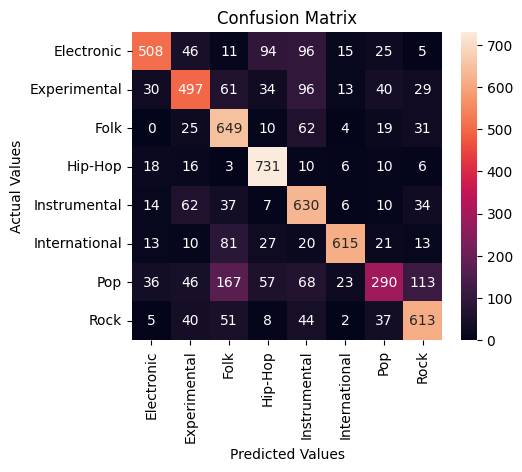

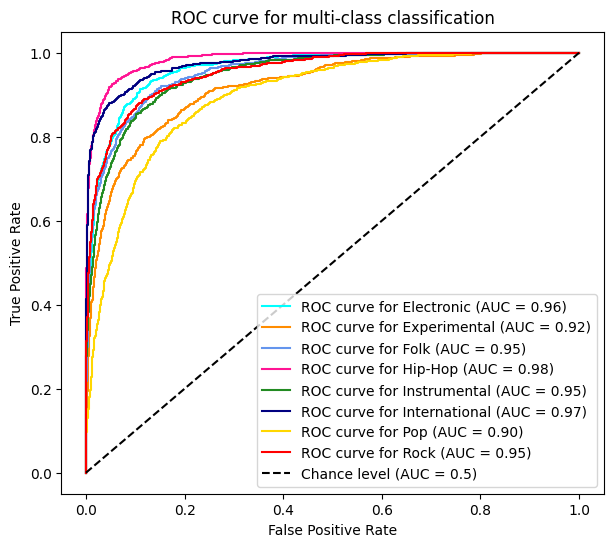

In [289]:
evaluate_network(train_dataloader, model, 'Training Dataset', config['batch_size'], major_vote_tr, true_tr, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:29<00:00,  7.15it/s]




								 ------- Validation Dataset ------- 
								   ------- Accuracy: 0.615 ------- 


               precision    recall  f1-score   support

   Electronic       0.60      0.56      0.58       100
 Experimental       0.55      0.65      0.59       100
         Folk       0.63      0.86      0.73       100
      Hip-Hop       0.66      0.76      0.71       100
 Instrumental       0.52      0.64      0.57       100
International       0.84      0.59      0.69       100
          Pop       0.32      0.12      0.17       100
         Rock       0.71      0.74      0.73       100

     accuracy                           0.61       800
    macro avg       0.60      0.61      0.60       800
 weighted avg       0.60      0.61      0.60       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            56.000000     65.000000   86.000000   76.000000     64.000000   
TN           663.000000    646.000000  649.000000  661.000000    640.000000   
FP            37.000000     54.000000   51.000000   39.000000     60.000000   
FN            44.000000     35.000000   14.000000   24.000000     36.000000   
TPR            0.560000      0.650000    0.860000    0.760000      0.640000   
Recall         0.560000      0.650000    0.860000    0.760000      0.640000   
Sensitivity    0.560000      0.650000    0.860000    0.760000      0.640000   
TNR            0.947143      0.922857    0.927143    0.944286      0.914286   
Specificity    0.947143      0.922857    0.927143    0.944286      0.914286   
FPR            0.052857      0.077143    0.072857    0.055714      0.085714   
FNR            0.440000      0.350000    0.140000    0.240000      0.360000   
PPV            0.602151      0.546218    0.627737    0.660870      0.516129   
Precision      0.602151      0.546218    0.627737    0.660870      0.516129   
F1 Score       0.580311      0.593607    0.725738    0.706977      0.571429   

             International         Pop        Rock  
TP               59.000000   12.000000   74.000000  
TN              689.000000  674.000000  670.000000  
FP               11.000000   26.000000   30.000000  
FN               41.000000   88.000000   26.000000  
TPR               0.590000    0.120000    0.740000  
Recall            0.590000    0.120000    0.740000  
Sensitivity       0.590000    0.120000    0.740000  
TNR               0.984286    0.962857    0.957143  
Specificity       0.984286    0.962857    0.957143  
FPR               0.015714    0.037143    0.042857  
FNR               0.410000    0.880000    0.260000  
PPV               0.842857    0.315789    0.711538  
Precision         0.842857    0.315789    0.711538  
F1 Score          0.694118    0.173913    0.725490

micro     macro  weighted
Precision  0.615  0.602911  0.602911
Recall     0.615  0.615000  0.615000
F1 Score   0.615  0.596448  0.596448

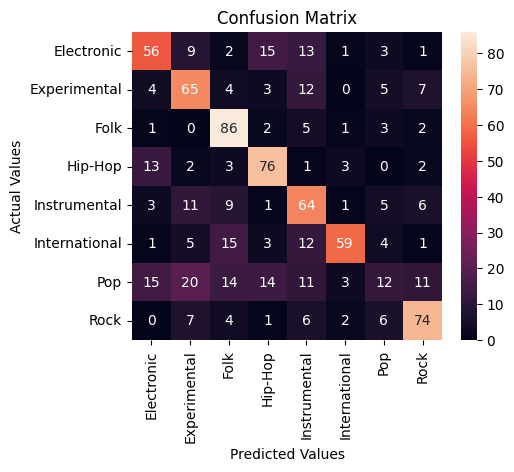

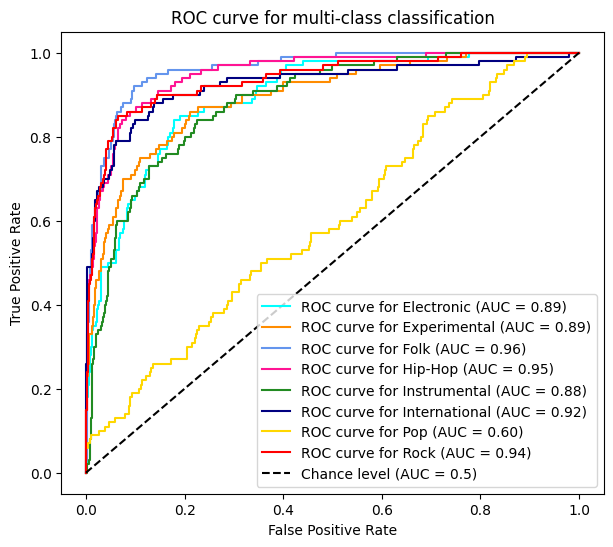

In [290]:
evaluate_network(val_dataloader, model, 'Validation Dataset', config['batch_size'], major_vote_val, true_val, genres, figsize1=(5,4), figsize2=(7,6))

100%|██████████| 208/208 [00:29<00:00,  7.09it/s]




								 ------- Test Dataset ------- 
								   ------- Accuracy: 0.4825 ------- 


               precision    recall  f1-score   support

   Electronic       0.66      0.58      0.62       100
 Experimental       0.40      0.40      0.40       100
         Folk       0.25      0.29      0.27       100
      Hip-Hop       0.62      0.91      0.74       100
 Instrumental       0.33      0.45      0.38       100
International       0.69      0.50      0.58       100
          Pop       0.29      0.15      0.20       100
         Rock       0.64      0.58      0.61       100

     accuracy                           0.48       800
    macro avg       0.49      0.48      0.47       800
 weighted avg       0.49      0.48      0.47       800



Electronic  Experimental        Folk     Hip-Hop  Instrumental  \
TP            58.000000     40.000000   29.000000   91.000000     45.000000   
TN           670.000000    639.000000  615.000000  644.000000    610.000000   
FP            30.000000     61.000000   85.000000   56.000000     90.000000   
FN            42.000000     60.000000   71.000000    9.000000     55.000000   
TPR            0.580000      0.400000    0.290000    0.910000      0.450000   
Recall         0.580000      0.400000    0.290000    0.910000      0.450000   
Sensitivity    0.580000      0.400000    0.290000    0.910000      0.450000   
TNR            0.957143      0.912857    0.878571    0.920000      0.871429   
Specificity    0.957143      0.912857    0.878571    0.920000      0.871429   
FPR            0.042857      0.087143    0.121429    0.080000      0.128571   
FNR            0.420000      0.600000    0.710000    0.090000      0.550000   
PPV            0.659091      0.396040    0.254386    0.619048      0.333333   
Precision      0.659091      0.396040    0.254386    0.619048      0.333333   
F1 Score       0.617021      0.398010    0.271028    0.736842      0.382979   

             International         Pop        Rock  
TP               50.000000   15.000000   58.000000  
TN              678.000000  663.000000  667.000000  
FP               22.000000   37.000000   33.000000  
FN               50.000000   85.000000   42.000000  
TPR               0.500000    0.150000    0.580000  
Recall            0.500000    0.150000    0.580000  
Sensitivity       0.500000    0.150000    0.580000  
TNR               0.968571    0.947143    0.952857  
Specificity       0.968571    0.947143    0.952857  
FPR               0.031429    0.052857    0.047143  
FNR               0.500000    0.850000    0.420000  
PPV               0.694444    0.288462    0.637363  
Precision         0.694444    0.288462    0.637363  
F1 Score          0.581395    0.197368    0.607330

micro     macro  weighted
Precision  0.4825  0.485271  0.485271
Recall     0.4825  0.482500  0.482500
F1 Score   0.4825  0.473997  0.473997

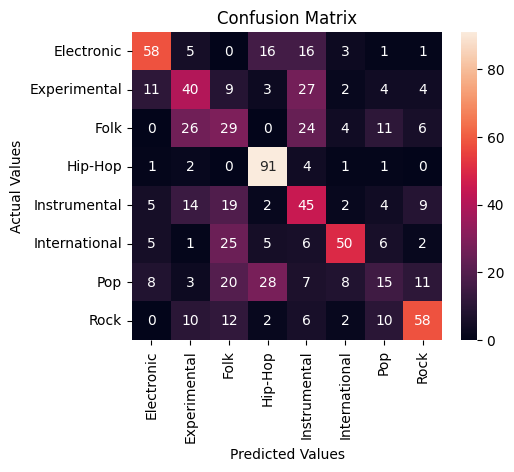

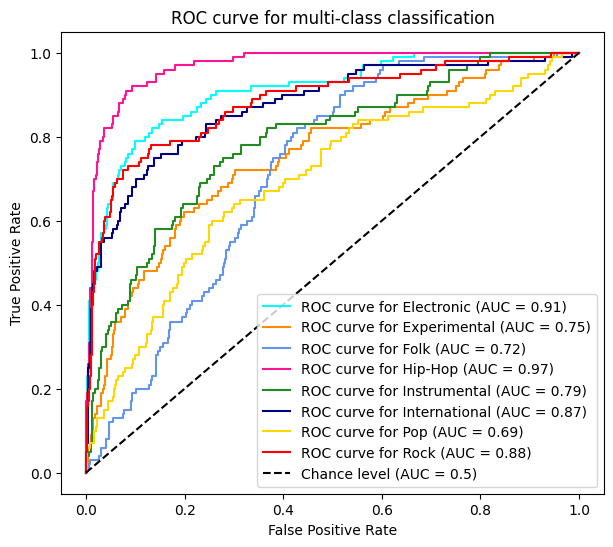

In [291]:
evaluate_network(test_dataloader, model, 'Test Dataset', config['batch_size'], major_vote_test, true_test, genres, figsize1=(5,4), figsize2=(7,6))

<br><br><br><br>

The next lines of code contain some of the functions and test networks used in the construction of this project. They are all commented and not essential to reproduce the results achieved and presented in the paper. We put them here for the sake of completeness.
<br>

# Network Trials

## ResNet1d - second version

In [ ]:
# class ResNet1d(Module):
#     def __init__(self, drop=0.2, bias=False):
#         super().__init__()
#         self.network = Sequential(
#             Conv1d(1, 8, kernel_size=7, stride=2, bias=bias),
#             BatchNorm1d(8),
#             MixedPooling1d(kernel_size=3, stride=2),

#             IdentityBlock1d(in_channels=8, filters=[8,8], kernel_size=3, bias=bias),
#             IdentityBlock1d(in_channels=8, filters=[8,8], kernel_size=3, bias=bias),
#             ConvoltuionalBlock1d(in_shape=22048, in_channels=8, filters=[8,16], kernel_size=3, stride=1, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4),
#             Dropout(drop),

#             IdentityBlock1d(in_channels=16, filters=[16,16], kernel_size=3, bias=bias),
#             IdentityBlock1d(in_channels=16, filters=[16,16], kernel_size=3, bias=bias),
#             ConvoltuionalBlock1d(in_shape=5510, in_channels=16, filters=[16,32], kernel_size=3, stride=1, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4),
#             Dropout(drop),

#             IdentityBlock1d(in_channels=32, filters=[32,32], kernel_size=3, bias=bias),
#             IdentityBlock1d(in_channels=32, filters=[32,32], kernel_size=3, bias=bias),
#             ConvoltuionalBlock1d(in_shape=1376, in_channels=32, filters=[32,64], kernel_size=3, stride=1, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4),
#             Dropout(drop),

#             IdentityBlock1d(in_channels=64, filters=[64,64], kernel_size=3, bias=bias),
#             IdentityBlock1d(in_channels=64, filters=[64,64], kernel_size=3, bias=bias),
#             ConvoltuionalBlock1d(in_shape=342, in_channels=64, filters=[64,128], kernel_size=3, stride=1, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4),
#             Dropout(drop),

#             IdentityBlock1d(in_channels=128, filters=[128,128], kernel_size=3, bias=bias),
#             IdentityBlock1d(in_channels=128, filters=[128,128], kernel_size=3, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4)
#         )
#         self.classification_layer = Sequential(
#             Linear(2560, 8, bias=bias),
#         )
#         self.apply(self._init_weights)

#     def forward(self, x):
#         y = self.network(x)
#         y = y.reshape((y.shape[0], -1))
#         y = self.classification_layer(y)
#         return y

#     def _init_weights(self, module):
#         if isinstance(module, torch.nn.Linear):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()
#         if isinstance(module, torch.nn.Conv1d):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()


## Temporal ResNet1d - second version

In [ ]:
# class Temporal_ResNet1d(Module):
#     def __init__(self, drop=0.2, bias=False):
#         super().__init__()
#         self.network = Sequential(
#             Conv1d(1, 2, kernel_size=8, stride=1, bias=bias),
#             BatchNorm1d(2),
#             MixedPooling1d(kernel_size=5, stride=4),

#             Temporal_IdentityBlock1d(in_channels=2, filters=[2,2], kernel_size=3, dilation=2**0, bias=bias),
#             Temporal_IdentityBlock1d(in_channels=2, filters=[2,2], kernel_size=3, dilation=2**1, bias=bias),
#             Temporal_ConvolutionalBlock1d(in_channels=2, filters=[2,4], kernel_size=3, dilation=2**2, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4),
#             # Dropout(drop),

#             Temporal_IdentityBlock1d(in_channels=4, filters=[4,4], kernel_size=3, dilation=2**3, bias=bias),
#             Temporal_IdentityBlock1d(in_channels=4, filters=[4,4], kernel_size=3, dilation=2**4, bias=bias),
#             Temporal_ConvolutionalBlock1d(in_channels=4, filters=[4,16], kernel_size=3, dilation=2**5, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4),
#             # Dropout(drop),

#             Temporal_IdentityBlock1d(in_channels=16, filters=[16,16], kernel_size=3, dilation=2**6, bias=bias),
#             Temporal_IdentityBlock1d(in_channels=16, filters=[16,16], kernel_size=3, dilation=2**7, bias=bias),
#             Temporal_ConvolutionalBlock1d(in_channels=16, filters=[16,32], kernel_size=3, dilation=2**8, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4),
#             # Dropout(drop),

#             Temporal_IdentityBlock1d(in_channels=32, filters=[32,32], kernel_size=3, dilation=2**9, bias=bias),
#             Temporal_IdentityBlock1d(in_channels=32, filters=[32,32], kernel_size=3, dilation=2**10, bias=bias),
#             MixedPooling1d(kernel_size=5, stride=4),
#             # Dropout(drop),
#         )
#         self.classification_layer = Sequential(
#             Linear(2720, 8, bias=bias),
#         )
#         self.apply(self._init_weights)

#     def forward(self, x):
#         y = self.network(x)
#         y = y.reshape((y.shape[0], -1))
#         y = self.classification_layer(y)
#         return y

#     def _init_weights(self, module):
#         if isinstance(module, torch.nn.Linear):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()
#         if isinstance(module, torch.nn.Conv1d):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()

## ResNet2d

In [ ]:
# class ResNet2d(Module):
#     def __init__(self, drop=0.2, bias=False):
#         super().__init__()
#         self.network = Sequential(
#             Conv2d(1, 64, kernel_size=7, stride=2, bias=bias),
#             BatchNorm2d(64),
#             MixedPooling2d(kernel_size=3, stride=2),

#             IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=3, bias=bias),
#             IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=3, bias=bias),
#             ConvoltuionalBlock2d(in_shape=[30, 41], in_channels=64, filters=[64,128], kernel_size=(3,3), stride=(1,1), bias=bias),
#             MixedPooling2d(kernel_size=3, stride=2),
#             Dropout(drop),

#             IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=3, bias=bias),
#             IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=3, bias=bias),
#             ConvoltuionalBlock2d(in_shape=[12, 18], in_channels=128, filters=[128,256], kernel_size=(3,3), stride=(1,1), bias=bias),
#             MixedPooling2d(kernel_size=3, stride=2),
#             Dropout(drop)
#         )
#         self.classification_layer = Sequential(
#             Linear(4608, 8, bias=bias),
#         )
#         self.apply(self._init_weights)

#     def forward(self, x):
#         y = self.network(x)
#         y = y.reshape((y.shape[0], -1))
#         y = self.classification_layer(y)
#         return y

#     def _init_weights(self, module):
#         if isinstance(module, torch.nn.Linear):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()
#         if isinstance(module, torch.nn.Conv1d):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()

## Temporal ResNet2d - second version

In [ ]:
# class Temporal_ResNet2d(Module):
#     def __init__(self, drop=0.2, bias=False):
#         super().__init__()
#         self.network = Sequential(
#             Conv2d(1, 64, kernel_size=7, stride=2, bias=bias),
#             BatchNorm2d(64),
#             MixedPooling2d(kernel_size=3, stride=2),

#             Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**0, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**1, bias=bias),
#             Temporal_ConvolutionalBlock2d(in_freq_shape=30, in_channels=64, filters=[64,128], kernel_size=(3,3), stride=1, dilation=2**2, bias=bias),
#             MixedPooling2d(kernel_size=3, stride=2),
#             Dropout(drop),

#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**3, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**4, bias=bias),
#             Temporal_ConvolutionalBlock2d(in_freq_shape=12, in_channels=128, filters=[128,256], kernel_size=(3,3), stride=1, dilation=2**5, bias=bias),
#             MixedPooling2d(kernel_size=(8,20)),
#             Dropout(drop),

#             Conv2d(256, 8, kernel_size=1, stride=1, bias=bias),
#             Dropout(drop)
#         )
#         self.apply(self._init_weights)

#     def forward(self, x):
#         y = self.network(x)
#         y = y.reshape((y.shape[0], -1))
#         return y

#     def _init_weights(self, module):
#         if isinstance(module, torch.nn.Linear):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()
#         if isinstance(module, torch.nn.Conv1d):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()

## Temporal ResNet2d (++IdentityBlocks) - third version

In [ ]:
# class Temporal_ResNet2d(Module):
#     def __init__(self, drop=0.2, bias=False):
#         super().__init__()
#         self.network = Sequential(
#             Conv2d(1, 64, kernel_size=7, stride=2, bias=bias),
#             BatchNorm2d(64),
#             MixedPooling2d(kernel_size=3, stride=2),

#             Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**0, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**1, bias=bias),
#             Temporal_ConvolutionalBlock2d(in_freq_shape=30, in_channels=64, filters=[64,128], kernel_size=(3,3), stride=1, dilation=2**2, bias=bias),
#             MixedPooling2d(kernel_size=3, stride=2),
#             Dropout(drop),

#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**3, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**4, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**5, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**6, bias=bias),
#             Temporal_ConvolutionalBlock2d(in_freq_shape=12, in_channels=128, filters=[128,256], kernel_size=(3,3), stride=1, dilation=2**7, bias=bias),
#             MixedPooling2d(kernel_size=3, stride=2),
#             Dropout(drop),
#         )
#         self.classification_layer = Sequential(
#             Linear(6912, 8, bias=bias),
#         )
#         self.apply(self._init_weights)

#     def forward(self, x):
#         y = self.network(x)
#         y = y.reshape((y.shape[0], -1))
#         y = self.classification_layer(y)
#         return y

#     def _init_weights(self, module):
#         if isinstance(module, torch.nn.Linear):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()
#         if isinstance(module, torch.nn.Conv1d):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()

## Temporal ResNet2d (++allBlocks) - fourth version

In [ ]:
# class Temporal_ResNet2d(Module):
#     def __init__(self, drop=0.2, bias=False):
#         super().__init__()
#         self.network = Sequential(
#             Conv2d(1, 64, kernel_size=7, stride=2, bias=bias),
#             BatchNorm2d(64),
#             MixedPooling2d(kernel_size=3, stride=2),

#             Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**0, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=64, filters=[64,64], kernel_size=(3,3), dilation=2**1, bias=bias),
#             Temporal_ConvolutionalBlock2d(in_freq_shape=30, in_channels=64, filters=[64,128], kernel_size=(3,3), stride=1, dilation=2**2, bias=bias),
#             MixedPooling2d(kernel_size=3, stride=2),
#             Dropout(drop),

#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**2, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**3, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**4, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=128, filters=[128,128], kernel_size=(3,3), dilation=2**5, bias=bias),
#             Temporal_ConvolutionalBlock2d(in_freq_shape=12, in_channels=128, filters=[128,256], kernel_size=(3,3), stride=1, dilation=2**6, bias=bias),
#             Dropout(drop),

#             Temporal_IdentityBlock2d(in_channels=256, filters=[256,256], kernel_size=(3,3), dilation=2**7, bias=bias),
#             Temporal_IdentityBlock2d(in_channels=256, filters=[256,256], kernel_size=(3,3), dilation=2**8, bias=bias),
#             Temporal_ConvolutionalBlock2d(in_freq_shape=8, in_channels=256, filters=[256,512], kernel_size=(3,3), stride=1, dilation=2**9, bias=bias),
#             MixedPooling2d(kernel_size=3, stride=2),
#             Dropout(drop),
#         )
#         self.classification_layer = Sequential(
#             Linear(4608, 8, bias=bias),
#         )
#         self.apply(self._init_weights)

#     def forward(self, x):
#         y = self.network(x)
#         y = y.reshape((y.shape[0], -1))
#         y = self.classification_layer(y)
#         return y

#     def _init_weights(self, module):
#         if isinstance(module, torch.nn.Linear):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()
#         if isinstance(module, torch.nn.Conv1d):
#             torch.nn.init.kaiming_uniform_(module.weight)
#             if module.bias is True:
#                 module.bias.data.zero_()

# Training + Validation

## Normal Version

In [5]:
# epochs = 1
# batch_size = 50

# # Wave spectrogram data loader
# train_dataloader_wave = DataLoader(train_wave, batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
# val_dataloader_wave = DataLoader(val_wave, batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
# test_dataloader_wave = DataLoader(test_wave, batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# train_dataloader = train_dataloader_wave
# test_dataloader = test_dataloader_wave
# val_dataloader = val_dataloader_wave

# # Set device (GPU if available, else CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# # Instantiate the model, define the loss function and optimizer
# model = ResNetTrial()
# model.to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adadelta(model.parameters(), lr=1.0)       # Adam(model.parameters(), lr=0.001, weight_decay = 0)

In [6]:
# # Set random seed for reproducibility
# # torch.manual_seed(0)

# best_val = np.inf
# for epoch in range(epochs):
#     print(f"\nEpoch: {epoch+1}")

#     # Training
#     model.train()
#     true, pred = [], []
#     iterator = tqdm(train_dataloader)
#     for batch_x, batch_y, _ in iterator:
#         batch_x, batch_y = batch_x.to(device), batch_y.float().to(device)

#         y_pred = model(batch_x)
#         loss = loss_fn(y_pred, batch_y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
#         pred.append(y_pred)
#         true.append(batch_y)
#     pred = torch.cat(pred, axis=0)
#     true = torch.cat(true, axis=0)
#     tr_loss = loss_fn(pred, true)
#     tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true, axis=1)).float().mean()


#     # Validation
#     model.eval()
#     with torch.no_grad():
#         true, pred = [], []
#         iterator = tqdm(val_dataloader)
#         for batch_x, batch_y, _ in iterator:
#             batch_x, batch_y = batch_x.to(device), batch_y.float().to(device)

#             y_pred = model(batch_x)
#             loss = loss_fn(y_pred, batch_y)
#             iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")

#             pred.append(y_pred)
#             true.append(batch_y)
#     pred = torch.cat(pred, axis=0)
#     true = torch.cat(true, axis=0)
#     val_loss = loss_fn(pred, true)
#     val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true, axis=1)).float().mean()
#     print(f"\nloss: {val_loss}, accuracy: {val_acc}")

#     if val_loss < best_val:
#         print("Saved Model")
#         torch.save(model.state_dict(), "model.pt")
#         best_val = val_loss

## Majority vote version

In [7]:
# epochs = 1
# batch_size = 50

# # Image spectrogram data loader
# train_dataloader_wave = DataLoader(train_wave, batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
# val_dataloader_wave = DataLoader(val_wave, batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
# test_dataloader_wave = DataLoader(test_wave, batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# train_dataloader = train_dataloader_wave
# test_dataloader = test_dataloader_wave
# val_dataloader = val_dataloader_wave

# # Set device (GPU if available, else CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# # Instantiate the model, define the loss function and optimizer
# model = ResNetTrial()
# model.to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adadelta(model.parameters(), lr=1.0)       # Adam(model.parameters(), lr=0.001, weight_decay = 0)

# # true label tensors
# true_tr = torch.tensor(labels_onehot_train.values)
# true_val = torch.tensor(labels_onehot_val.values)

In [8]:
# # Set random seed for reproducibility
# # torch.manual_seed(0)

# best_val = 0
# for epoch in range(epochs):
#     print(f"\nEpoch: {epoch+1}")
#     major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
#     major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

#     # Training
#     model.train()
#     iterator = tqdm(train_dataloader)
#     for batch_x, batch_y, batch_id in iterator:
#         batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

#         y_pred = model(batch_x)
#         loss = loss_fn(y_pred, batch_y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
#         for i in range(batch_size): major_vote_tr[batch_id[i].item()] += y_pred.detach().cpu()[i]    # Majority voting
#     pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
#     tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
#     print(f'Training accuracy:{tr_acc}     Training error:{1-tr_acc}\n')


#     # Validation
#     model.eval()
#     with torch.no_grad():
#         iterator = tqdm(val_dataloader)
#         for batch_x, batch_y, batch_id in iterator:
#             batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

#             y_pred = model(batch_x)
#             loss = loss_fn(y_pred, batch_y)

#             iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
#             for i in range(batch_size): major_vote_val[batch_id[i].item()] += y_pred.detach().cpu()[i]    # Majority voting
#     pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
#     val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
#     print(f'Validation accuracy:{val_acc}     Validation error:{1-val_acc}\n')

#     if val_acc > best_val:
#         print("Saved Model")
#         torch.save(model.state_dict(), "model.pt")
#         best_val = val_acc

## Wandb integration

In [9]:
# group_name = "Trial"
# wandb.init(project="wandb_trial", entity="festaorlando", group=group_name)

# config = dict(
#     epochs=6,
#     batch_size=50,
#     learning_rate=1.0,
#     architecture="nnet2-spectrogram")
# wandb.config = config

In [10]:
# # Spectrogram data loader
# train_dataloader_spec = DataLoader(train_spect, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
# val_dataloader_spec = DataLoader(val_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
# test_dataloader_spec = DataLoader(test_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# train_dataloader = train_dataloader_spec
# test_dataloader = test_dataloader_spec
# val_dataloader = val_dataloader_spec

# # Set device (GPU if available, else CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# # Instantiate the model, define the loss function and optimizer
# model = nnet2_2d()
# model.to(device)

# loss_fn = nn.CrossEntropyLoss()

# optimizer = optim.Adadelta(model.parameters(), lr=config['learning_rate'])
# # Adam(model.parameters(), lr=0.001, weight_decay = 0)

In [11]:
# # Set random seed for reproducibility
# # torch.manual_seed(0)

# best_val = np.inf
# wandb.watch(model, log="all")   # log_freq=10
# for epoch in range(config['epochs']):
#     print(f"\nEpoch: {epoch+1}")

#     # Training
#     model.train()
#     true, pred = [], []
#     iterator = tqdm(train_dataloader)
#     for batch_x, batch_y, _ in iterator:
#         batch_x, batch_y = batch_x.to(device), batch_y.float().to(device)

#         y_pred = model(batch_x)
#         loss = loss_fn(y_pred, batch_y)
#         wandb.log({'Running training loss':loss, 'Epoch':epoch+1})

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
#         pred.append(y_pred)
#         true.append(batch_y)
#     pred = torch.cat(pred, axis=0)
#     true = torch.cat(true, axis=0)
#     tr_loss = loss_fn(pred, true)
#     tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true, axis=1)).float().mean()
#     wandb.log({'Training loss':tr_loss, 'Training accuracy':tr_acc, 'Training error':1-tr_acc})


#     # Validation
#     model.eval()
#     with torch.no_grad():
#         true, pred = [], []
#         iterator = tqdm(val_dataloader)
#         for batch_x, batch_y, _ in iterator:
#             batch_x, batch_y = batch_x.to(device), batch_y.float().to(device)

#             y_pred = model(batch_x)
#             loss = loss_fn(y_pred, batch_y)
#             iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")

#             pred.append(y_pred)
#             true.append(batch_y)
#     pred = torch.cat(pred, axis=0)
#     true = torch.cat(true, axis=0)
#     val_loss = loss_fn(pred, true)
#     val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true, axis=1)).float().mean()
#     wandb.log({'Validation loss':val_loss, 'Validation accuracy':val_acc, 'Validation error':1-val_acc})
#     print(f"\nloss: {val_loss}, accuracy: {val_acc}")

#     if val_loss < best_val:
#         print("Saved Model")
#         torch.save(model.state_dict(), "model.pt")
#         best_val = val_loss
# wandb.finish()

## Wandb integration + Majority vote

In [12]:
# # group_name = "Augment"
# run = wandb.init(project="Temporal_ResNet2d(version2)", entity="festaorlando")      # , group=group_name

# config = dict(
#     epochs=15,
#     batch_size=50,
#     learning_rate=0.004,
#     weight_decay=0,
#     architecture="Temporal_ResNet2d-Mel")
# wandb.config = config

In [13]:
# # Spectrogram data loader
# train_dataloader_spec = DataLoader(train_spect, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
# val_dataloader_spec = DataLoader(val_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
# test_dataloader_spec = DataLoader(test_spect, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# train_dataloader = train_dataloader_spec
# test_dataloader = test_dataloader_spec
# val_dataloader = val_dataloader_spec

# # Set device (GPU if available, else CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# # Instantiate the model, define the loss function and optimizer
# model = Temporal_ResNet2d()
# model.to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# # true label tensors
# true_tr = torch.tensor(labels_onehot_train.values)
# true_val = torch.tensor(labels_onehot_val.values)

In [14]:
# # Set random seeds for reproducibility
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)


# best_val = 0
# wandb.watch(model, log="all")   # log_freq=10
# for epoch in range(config['epochs']):
#     print(f"\n\nEpoch: {epoch+1}")
#     major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
#     major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

#     # Training
#     model.train()
#     iterator = tqdm(train_dataloader)
#     for batch_x, batch_y, batch_id in iterator:
#         batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

#         y_pred = model(batch_x)
#         loss = loss_fn(y_pred, batch_y)
#         wandb.log({'Running training loss':loss})

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
#         for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += y_pred.detach().cpu()[i]    # Majority voting
#     pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
#     tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
#     print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')
#     wandb.log({'Training accuracy':tr_acc, 'Training error':1-tr_acc, 'Epoch':epoch+1})


#     # Validation
#     model.eval()
#     with torch.no_grad():
#         iterator = tqdm(val_dataloader)
#         for batch_x, batch_y, batch_id in iterator:
#             batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

#             y_pred = model(batch_x)
#             loss = loss_fn(y_pred, batch_y)

#             iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
#             for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += y_pred.detach().cpu()[i]    # Majority voting
#     pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
#     val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
#     wandb.log({'Validation accuracy':val_acc, 'Validation error':1-val_acc, 'Epoch':epoch+1})
#     print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

#     if val_acc > best_val:
#         print("Saved Model")
#         torch.save(model.state_dict(), "model.pt")
#         best_val = val_acc

# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('model.pt')
# run.log_artifact(artifact)
# run.finish()

# Optuna Integration


In [15]:
# config = dict(
#     epochs=5,
#     batch_size=50,
#     learning_rate=0.004,
#     # weight_decay=0,
#     architecture="Temporal_paper1d-wave")

In [16]:
# # Wave spectrogram data loader
# train_dataloader_wave = DataLoader(train_wave, config['batch_size'], shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
# val_dataloader_wave = DataLoader(val_wave, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
# test_dataloader_wave = DataLoader(test_wave, config['batch_size'], shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# train_dataloader = train_dataloader_wave
# test_dataloader = test_dataloader_wave
# val_dataloader = val_dataloader_wave



# # Set device (GPU if available, else CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# # Define the loss function and optimizer
# loss_fn = nn.CrossEntropyLoss()

# # true label tensors
# true_tr = torch.tensor(labels_onehot_train.values)
# true_val = torch.tensor(labels_onehot_val.values)

In [17]:
# def objective(trial):
#     model = Temporal_paper1d().to(device)
#     weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1)  # , log=True
#     optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=weight_decay)


#     for epoch in range(config['epochs']):
#         print(f"\n\nEpoch: {epoch+1}")
#         major_vote_tr = dict(zip(labels_onehot_train.reset_index().track_id, torch.zeros(labels_onehot_train.shape[0], len(genres))))           # majority voting dictionaries
#         major_vote_val = dict(zip(labels_onehot_val.reset_index().track_id, torch.zeros(labels_onehot_val.shape[0], len(genres))))

#         # Training
#         model.train()
#         iterator = tqdm(train_dataloader)
#         for batch_x, batch_y, batch_id in iterator:
#             batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

#             y_pred = model(batch_x)
#             loss = loss_fn(y_pred, batch_y)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             iterator.set_description(f"Running training loss: {loss.detach().cpu().numpy()}")
#             for i in range(config['batch_size']): major_vote_tr[batch_id[i].item()] += y_pred.detach().cpu()[i]    # Majority voting
#         pred = torch.tensor(pd.DataFrame(major_vote_tr).T.values)
#         tr_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_tr, axis=1)).float().mean()
#         print(f'Training accuracy:{tr_acc}   Training error:{1-tr_acc}')


#         # Validation
#         model.eval()
#         with torch.no_grad():
#             iterator = tqdm(val_dataloader)
#             for batch_x, batch_y, batch_id in iterator:
#                 batch_x, batch_y, batch_id = batch_x.to(device), batch_y.float().to(device), batch_id.to(device)

#                 y_pred = model(batch_x)
#                 loss = loss_fn(y_pred, batch_y)

#                 iterator.set_description(f"Running validation loss: {loss.detach().cpu().numpy()}")
#                 for i in range(config['batch_size']): major_vote_val[batch_id[i].item()] += y_pred.detach().cpu()[i]    # Majority voting
#         pred = torch.tensor(pd.DataFrame(major_vote_val).T.values)
#         val_acc = (torch.argmax(pred, axis=1)==torch.argmax(true_val, axis=1)).float().mean()
#         print(f'Validation accuracy:{val_acc}   Validation error:{1-val_acc}')

#         # Handle pruning based on the intermediate value
#         trial.report(val_acc, epoch)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return val_acc

In [18]:
# # Set random seeds for reproducibility
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

# study = optuna.create_study(sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner(), direction='maximize')
# study.sampler.__class__.__name__, study.pruner.__class__.__name__

In [19]:
# # Add stream handler of stdout to show the messages
# import logging
# import sys
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# study.optimize(objective, n_trials=4)

In [20]:
# trial = study.best_trial

In [21]:
# print('Accuracy: {}'.format(trial.value))
# print("Best hyperparameters: {}".format(trial.params))

In [22]:
# df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
# df

In [23]:
# optuna.visualization.plot_optimization_history(study)

In [24]:
# optuna.visualization.plot_contour(study, params=['weight_decay'])

In [25]:
# optuna.visualization.plot_parallel_coordinate(study)

In [26]:
# optuna.visualization.plot_param_importances(study)